In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from math import e, sqrt
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from scipy.misc import derivative
import scipy
from shapely import affinity
from shapely.geometry import Polygon

In [2]:
class Vehicle:
    def __init__(self, id, pos, vel, accel=[0,0], dim=[4.5, 1.7]):
        self.id = id
        self.pos = pos
        self.vel = vel
        self.accel = accel
        self.dim = dim
        # define a vehicle type
        self.istruck = 1 if dim[0]>=7.2 else 0
        # define a lc status
        self.islc = 1 if abs(vel[1])>0.1 else 0

In [11]:
tracks = pd.read_csv(r"E:\Data\highd-dataset-v1.0\data\01_tracks.csv")
tracks

,frame,id,x,y,width,height,xVelocity,yVelocity,xAcceleration,yAcceleration,...,precedingXVelocity,precedingId,followingId,leftPrecedingId,leftAlongsideId,leftFollowingId,rightPrecedingId,rightAlongsideId,rightFollowingId,laneId
0,1,1,362.26,21.68,4.85,2.12,40.85,0.00,0.30,0.00,...,0.00,0,3,0,0,0,0,0,6,5
1,2,1,363.73,21.68,4.85,2.12,40.87,0.00,0.30,0.00,...,0.00,0,14,0,0,0,0,0,6,5
2,3,1,365.27,21.68,4.85,2.12,40.88,0.00,0.31,0.00,...,0.00,0,14,0,0,0,0,0,6,5
3,4,1,366.83,21.68,4.85,2.12,40.89,0.00,0.32,0.00,...,0.00,0,14,0,0,0,0,0,6,5
4,5,1,368.42,21.68,4.85,2.12,40.90,0.01,0.32,0.00,...,0.00,0,14,0,0,0,0,0,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348745,22535,1047,366.97,12.54,6.37,3.13,-35.63,0.19,-0.74,0.11,...,-34.18,1045,0,0,0,0,1039,0,0,3
348746,22536,1047,365.55,12.55,6.37,3.13,-35.66,0.20,-0.74,0.11,...,-34.19,1045,0,0,0,0,1039,0,0,3
348747,22537,1047,364.12,12.56,6.37,3.13,-35.69,0.20,-0.74,0.11,...,-34.19,1045,0,0,0,0,1039,0,0,3
348748,22538,1047,362.69,12.57,6.37,3.13,-35.72,0.21,-0.74,0.11,...,-34.20,1045,0,0,0,0,1039,0,0,3


In [17]:
tracks.groupby('id').get_group(2)

,frame,id,x,y,width,height,xVelocity,yVelocity,xAcceleration,yAcceleration,...,precedingXVelocity,precedingId,followingId,leftPrecedingId,leftAlongsideId,leftFollowingId,rightPrecedingId,rightAlongsideId,rightFollowingId,laneId
33,1,2,162.75,9.39,4.24,1.92,-32.04,0.00,-0.26,-0.00,...,0.00,0,8,0,0,4,0,0,0,2
34,2,2,161.58,9.39,4.24,1.92,-32.06,0.00,-0.27,-0.00,...,-38.53,13,8,0,0,4,0,0,0,2
35,3,2,160.36,9.39,4.24,1.92,-32.07,0.00,-0.27,-0.00,...,-38.55,13,8,0,0,4,0,0,0,2
36,4,2,159.13,9.39,4.24,1.92,-32.08,0.00,-0.27,-0.01,...,-38.58,13,8,0,0,4,0,0,0,2
37,5,2,157.86,9.39,4.24,1.92,-32.09,0.00,-0.27,-0.01,...,-38.60,13,8,0,0,4,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,126,2,0.57,9.19,4.24,1.92,-32.87,0.04,-0.22,0.07,...,0.00,0,8,0,0,4,0,0,0,2
159,127,2,-0.75,9.19,4.24,1.92,-32.88,0.05,-0.22,0.07,...,0.00,0,8,0,0,4,0,0,0,2
160,128,2,-2.06,9.19,4.24,1.92,-32.89,0.05,-0.22,0.07,...,0.00,0,8,0,0,4,0,0,0,2
161,129,2,-3.38,9.19,4.24,1.92,-32.89,0.05,-0.22,0.07,...,0.00,0,8,0,0,4,0,0,0,2


In [4]:
tracks.columns

Index(['frame', 'id', 'x', 'y', 'width', 'height', 'xVelocity', 'yVelocity',
       'xAcceleration', 'yAcceleration', 'frontSightDistance',
       'backSightDistance', 'dhw', 'thw', 'ttc', 'precedingXVelocity',
       'precedingId', 'followingId', 'leftPrecedingId', 'leftAlongsideId',
       'leftFollowingId', 'rightPrecedingId', 'rightAlongsideId',
       'rightFollowingId', 'laneId'],
      dtype='object')

In [5]:
meta = pd.read_csv(r"E:\Data\highd-dataset-v1.0\data\01_recordingMeta.csv")
meta

,id,frameRate,locationId,speedLimit,month,weekDay,startTime,duration,totalDrivenDistance,totalDrivenTime,numVehicles,numCars,numTrucks,upperLaneMarkings,lowerLaneMarkings
0,1,25,2,-1.0,9.2017,Tue,08:38,901.56,418549.19,13908.12,1047,863,184,8.51;12.59;16.43,21.00;24.96;28.80


In [6]:
lcstatus = tracks.groupby('id').laneId.nunique()

In [9]:
len(tracks.id.unique())

1047

In [11]:
lcstatus[54]

1

In [3]:
from calibrate import HighD, Vehicle

In [4]:
highd = HighD()

In [7]:
spacings = highd.compile_spacing_data(recordingIDs=[5])

  0%|          | 0/1 [00:13<?, ?it/s]


KeyboardInterrupt: 

In [9]:
spacings

NameError: name 'spacings' is not defined

In [60]:
velRange = [20,22]

In [61]:
spacings[(abs(spacings.ego_vel)<velRange[1])&(abs(spacings.ego_vel)>=velRange[0])]

,ego_x,ego_y,foe_x,foe_y,ego_vel,ego_truck,ego_lc,foe_vel,foe_truck,foe_lc,ego_length,ego_width,foe_length,foe_width,y_marker1,y_marker2,y_bound1,y_bound2
198,121.27,14.81,133.680,19.18,-21.05,1.0,0.0,-23.96,1.0,0.0,7.58,2.5,17.08,2.50,0.0,0.0,0.0,NaN
199,117.07,14.82,128.910,19.19,-21.05,1.0,0.0,-23.98,1.0,0.0,7.58,2.5,17.08,2.50,0.0,0.0,0.0,NaN
200,112.82,14.83,124.100,19.21,-21.05,1.0,0.0,-24.01,1.0,0.0,7.58,2.5,17.08,2.50,0.0,0.0,0.0,NaN
201,108.59,14.83,119.310,19.22,-21.04,1.0,0.0,-24.04,1.0,0.0,7.58,2.5,17.08,2.50,0.0,0.0,0.0,NaN
202,104.41,14.84,114.500,19.24,-21.03,1.0,0.0,-24.07,1.0,0.0,7.58,2.5,17.08,2.50,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26923,75.58,36.24,253.375,31.99,21.98,1.0,0.0,36.48,0.0,0.0,17.08,2.5,4.35,1.92,0.0,0.0,0.0,NaN
26924,79.97,36.22,260.685,31.98,21.97,1.0,0.0,36.40,0.0,0.0,17.08,2.5,4.35,1.92,0.0,0.0,0.0,NaN
26925,84.34,36.21,267.985,31.98,21.96,1.0,0.0,36.31,0.0,0.0,17.08,2.5,4.35,1.92,0.0,0.0,0.0,NaN
26926,88.75,36.20,275.225,31.97,21.95,1.0,0.0,36.22,0.0,0.0,17.08,2.5,4.35,1.92,0.0,0.0,0.0,NaN


In [ ]:
_r = 56
args = spacings.iloc[_r]
ego = Vehicle(0, [args.ego_x, args.ego_y], [args.ego_vel, 0], [0,0], [args.ego_length, args.ego_width])
foe = Vehicle(1, [args.foe_x, args.foe_y], [args.foe_vel, 0], [0,0], [args.foe_length, args.foe_width])



In [38]:
x = [1,1,1,1,0,0]
params = x
params[4] = 2+e**x[4]
params[4] = 2+e**x[5]

risk = ego.get_subjective_risk(foe, *params)
likelihood = 1 - risk
likelihood

0.9999999999999993

In [46]:
# compress in one line
# get parameters
x = [1,1,1,1,0,0]
params = x
params[4] = 2+e**x[4]
params[4] = 2+e**x[5]
# get input
input = spacings
_x = input.ego_x - input.foe_x
_y = input.ego_y - input.foe_y
gx = params[0] + params[1]*input.ego_vel + input.ego_length/2 + input.foe_length/2
gy = params[2] + params[3]*input.ego_vel + input.ego_width/2 + input.foe_width/2
bx = params[4]
by = params[5]
risks = e**(-abs(_x/gx)**bx-abs(_y/gy)**by)
logjll = np.sum(np.log(1+1e-4-risks))

In [47]:
logjll

-3005.180304545768

In [64]:
np.array_split(np.arange(1,61), 9)[5]

array([36, 37, 38, 39, 40, 41, 42])

In [70]:
pd.read_csv(f"../data/new_01_spacings.csv", index_col=0)

,ego_id,foe_id,recording_id,frame,ego_x,ego_y,foe_x,foe_y,ego_vel,ego_truck,...,foe_truck,foe_lc,ego_length,ego_width,foe_length,foe_width,y_marker1,y_marker2,y_bound1,y_bound2
0,3.0,10.0,1.0,13.0,200.910,22.60,217.010,26.92,35.78,0.0,...,1.0,0.0,3.94,1.92,9.20,2.50,0.0,0.0,0.0,0.0
1,3.0,6.0,1.0,38.0,236.860,22.57,281.990,26.85,35.98,0.0,...,1.0,0.0,3.94,1.92,11.82,2.50,0.0,0.0,0.0,0.0
2,3.0,10.0,1.0,38.0,236.860,22.57,240.410,26.80,35.98,0.0,...,1.0,0.0,3.94,1.92,9.20,2.50,0.0,0.0,0.0,0.0
3,3.0,6.0,1.0,63.0,272.930,22.53,305.340,26.70,36.10,0.0,...,1.0,0.0,3.94,1.92,11.82,2.50,0.0,0.0,0.0,0.0
4,3.0,6.0,1.0,88.0,309.060,22.49,328.650,26.55,36.18,0.0,...,1.0,0.0,3.94,1.92,11.82,2.50,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,1044.0,1040.0,1.0,22431.0,82.465,22.93,153.095,22.46,37.44,0.0,...,0.0,0.0,5.15,2.02,4.35,1.92,0.0,0.0,0.0,0.0
890,1044.0,1040.0,1.0,22456.0,119.975,22.82,191.245,22.63,37.62,0.0,...,0.0,0.0,5.15,2.02,4.35,1.92,0.0,0.0,0.0,0.0
891,1044.0,1040.0,1.0,22481.0,157.725,22.88,229.235,22.76,37.81,0.0,...,0.0,0.0,5.15,2.02,4.35,1.92,0.0,0.0,0.0,0.0
892,1044.0,1040.0,1.0,22506.0,195.675,23.00,267.055,22.80,38.15,0.0,...,0.0,0.0,5.15,2.02,4.35,1.92,0.0,0.0,0.0,0.0


In [9]:
# read spacing data from all recordings
spacings = pd.concat([ pd.read_csv(f"../data/{r:02}_spacings_1.csv",index_col=0) for r in np.arange(1,61)])

In [10]:
spacings

,ego_id,foe_id,recording_id,frame,ego_x,ego_y,foe_x,foe_y,ego_vel,ego_truck,...,y_bound1,y_bound2,ego_xAccel,ego_xVel,ego_yAccel,ego_yVel,foe_xAccel,foe_xVel,foe_yAccel,foe_yVel
0,3.0,10.0,1.0,3.0,186.720,22.60,207.690,26.88,NaN,0.0,...,0.0,0.0,0.18,35.70,-0.01,-0.00,0.17,23.22,-0.04,0.15
1,3.0,10.0,1.0,8.0,193.760,22.60,212.330,26.92,NaN,0.0,...,0.0,0.0,0.20,35.74,-0.01,-0.01,0.17,23.26,-0.10,0.09
2,3.0,10.0,1.0,13.0,200.910,22.60,217.010,26.92,NaN,0.0,...,0.0,0.0,0.21,35.78,-0.02,-0.02,0.16,23.29,-0.12,0.03
3,3.0,10.0,1.0,18.0,208.080,22.60,221.620,26.91,NaN,0.0,...,0.0,0.0,0.21,35.82,-0.02,-0.02,0.14,23.32,-0.12,-0.03
4,3.0,10.0,1.0,23.0,215.280,22.59,226.290,26.89,NaN,0.0,...,0.0,0.0,0.21,35.86,-0.02,-0.03,0.11,23.35,-0.10,-0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39379,1466.0,1465.0,60.0,24002.0,90.335,33.02,80.085,29.21,NaN,1.0,...,0.0,0.0,-0.36,22.51,-0.07,-0.18,0.26,34.19,-0.07,-0.08
39380,1466.0,1465.0,60.0,24007.0,94.805,32.98,86.925,29.20,NaN,1.0,...,0.0,0.0,-0.35,22.44,-0.08,-0.20,0.25,34.24,-0.08,-0.10
39381,1466.0,1465.0,60.0,24012.0,99.295,32.93,93.785,29.18,NaN,1.0,...,0.0,0.0,-0.35,22.37,-0.08,-0.22,0.25,34.29,-0.08,-0.11
39382,1466.0,1465.0,60.0,24017.0,103.755,32.89,100.635,29.15,NaN,1.0,...,0.0,0.0,-0.35,22.30,-0.08,-0.23,0.25,34.34,-0.08,-0.13


In [8]:
spacings.columns

Index(['ego_id', 'foe_id', 'recording_id', 'frame', 'ego_x', 'ego_y', 'foe_x',
       'foe_y', 'ego_vel', 'ego_truck', 'ego_lc', 'foe_vel', 'foe_truck',
       'foe_lc', 'ego_length', 'ego_width', 'foe_length', 'foe_width',
       'y_marker1', 'y_marker2', 'y_bound1', 'y_bound2'],
      dtype='object')

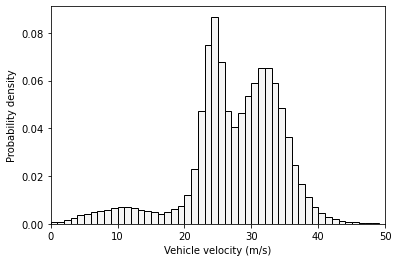

In [21]:
# angle = np.arcsin(track01.yVelocity/np.sqrt(track01.xVelocity**2+track01.yVelocity**2) )*180/np.pi
plt.hist(spacings.ego_vel.abs(), bins=np.arange(0, 50, 1), facecolor='whitesmoke', edgecolor='black', density=True)
# plt.grid()
plt.xlabel(r'Vehicle velocity (m/s)')
plt.ylabel('Probability density')
# plt.title('Velocity')
plt.savefig(r'..\results\aap-figures\velocity.png', dpi=300)
plt.xlim(0, 50)
plt.show()

In [12]:
spacings[spacings['recording_id']==45]

,ego_id,foe_id,recording_id,frame,ego_x,ego_y,foe_x,foe_y,ego_vel,ego_truck,...,foe_truck,foe_lc,ego_length,ego_width,foe_length,foe_width,y_marker1,y_marker2,y_bound1,y_bound2
0,4.0,22.0,45.0,15.0,384.595,36.78,376.955,32.51,27.05,1.0,...,0.0,0.0,17.79,2.5,5.15,1.92,0.0,0.0,0.0,0.0
1,4.0,22.0,45.0,20.0,390.075,36.79,383.325,32.53,27.17,1.0,...,0.0,0.0,17.79,2.5,5.15,1.92,0.0,0.0,0.0,0.0
2,4.0,22.0,45.0,25.0,395.575,36.79,389.685,32.54,27.30,1.0,...,0.0,0.0,17.79,2.5,5.15,1.92,0.0,0.0,0.0,0.0
3,4.0,22.0,45.0,30.0,401.015,36.79,396.045,32.55,27.42,1.0,...,0.0,0.0,17.79,2.5,5.15,1.92,0.0,0.0,0.0,0.0
4,4.0,22.0,45.0,35.0,406.515,36.80,402.485,32.57,27.54,1.0,...,0.0,0.0,17.79,2.5,5.15,1.92,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69196,2446.0,2430.0,45.0,27802.0,360.215,15.44,233.095,15.27,-27.19,1.0,...,1.0,0.0,18.39,2.5,17.63,2.50,0.0,0.0,0.0,0.0
69197,2446.0,2430.0,45.0,27807.0,354.775,15.43,228.535,15.26,-27.15,1.0,...,1.0,0.0,18.39,2.5,17.63,2.50,0.0,0.0,0.0,0.0
69198,2446.0,2430.0,45.0,27812.0,349.355,15.43,223.965,15.25,-27.11,1.0,...,1.0,0.0,18.39,2.5,17.63,2.50,0.0,0.0,0.0,0.0
69199,2446.0,2430.0,45.0,27817.0,343.955,15.42,219.445,15.25,-27.07,1.0,...,1.0,0.0,18.39,2.5,17.63,2.50,0.0,0.0,0.0,0.0


In [13]:
spacings[spacings.ego_lc==0]

,ego_id,foe_id,recording_id,frame,ego_x,ego_y,foe_x,foe_y,ego_vel,ego_truck,...,foe_truck,foe_lc,ego_length,ego_width,foe_length,foe_width,y_marker1,y_marker2,y_bound1,y_bound2
0,3.0,10.0,1.0,3.0,186.720,22.60,207.690,26.88,35.70,0.0,...,1.0,0.0,3.94,1.92,9.20,2.50,0.0,0.0,0.0,0.0
1,3.0,10.0,1.0,8.0,193.760,22.60,212.330,26.92,35.74,0.0,...,1.0,0.0,3.94,1.92,9.20,2.50,0.0,0.0,0.0,0.0
2,3.0,10.0,1.0,13.0,200.910,22.60,217.010,26.92,35.78,0.0,...,1.0,0.0,3.94,1.92,9.20,2.50,0.0,0.0,0.0,0.0
3,3.0,10.0,1.0,18.0,208.080,22.60,221.620,26.91,35.82,0.0,...,1.0,0.0,3.94,1.92,9.20,2.50,0.0,0.0,0.0,0.0
4,3.0,10.0,1.0,23.0,215.280,22.59,226.290,26.89,35.86,0.0,...,1.0,0.0,3.94,1.92,9.20,2.50,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39379,1466.0,1465.0,60.0,24002.0,90.335,33.02,80.085,29.21,22.51,1.0,...,0.0,0.0,16.37,2.50,4.95,2.02,0.0,0.0,0.0,0.0
39380,1466.0,1465.0,60.0,24007.0,94.805,32.98,86.925,29.20,22.44,1.0,...,0.0,0.0,16.37,2.50,4.95,2.02,0.0,0.0,0.0,0.0
39381,1466.0,1465.0,60.0,24012.0,99.295,32.93,93.785,29.18,22.37,1.0,...,0.0,0.0,16.37,2.50,4.95,2.02,0.0,0.0,0.0,0.0
39382,1466.0,1465.0,60.0,24017.0,103.755,32.89,100.635,29.15,22.30,1.0,...,0.0,0.0,16.37,2.50,4.95,2.02,0.0,0.0,0.0,0.0


In [22]:
spacings[(spacings.ego_lc==0)&(spacings.foe_lc==0)]

,ego_id,foe_id,recording_id,frame,ego_x,ego_y,foe_x,foe_y,ego_vel,ego_truck,...,foe_truck,foe_lc,ego_length,ego_width,foe_length,foe_width,y_marker1,y_marker2,y_bound1,y_bound2
0,3.0,10.0,1.0,3.0,186.720,22.60,207.690,26.88,35.70,0.0,...,1.0,0.0,3.94,1.92,9.20,2.50,0.0,0.0,0.0,0.0
1,3.0,10.0,1.0,8.0,193.760,22.60,212.330,26.92,35.74,0.0,...,1.0,0.0,3.94,1.92,9.20,2.50,0.0,0.0,0.0,0.0
2,3.0,10.0,1.0,13.0,200.910,22.60,217.010,26.92,35.78,0.0,...,1.0,0.0,3.94,1.92,9.20,2.50,0.0,0.0,0.0,0.0
3,3.0,10.0,1.0,18.0,208.080,22.60,221.620,26.91,35.82,0.0,...,1.0,0.0,3.94,1.92,9.20,2.50,0.0,0.0,0.0,0.0
4,3.0,10.0,1.0,23.0,215.280,22.59,226.290,26.89,35.86,0.0,...,1.0,0.0,3.94,1.92,9.20,2.50,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39379,1466.0,1465.0,60.0,24002.0,90.335,33.02,80.085,29.21,22.51,1.0,...,0.0,0.0,16.37,2.50,4.95,2.02,0.0,0.0,0.0,0.0
39380,1466.0,1465.0,60.0,24007.0,94.805,32.98,86.925,29.20,22.44,1.0,...,0.0,0.0,16.37,2.50,4.95,2.02,0.0,0.0,0.0,0.0
39381,1466.0,1465.0,60.0,24012.0,99.295,32.93,93.785,29.18,22.37,1.0,...,0.0,0.0,16.37,2.50,4.95,2.02,0.0,0.0,0.0,0.0
39382,1466.0,1465.0,60.0,24017.0,103.755,32.89,100.635,29.15,22.30,1.0,...,0.0,0.0,16.37,2.50,4.95,2.02,0.0,0.0,0.0,0.0


In [7]:
_data = spacings[(spacings.ego_lc==0)&(spacings.foe_lc==0)&(spacings.ego_vel<10)&(spacings.ego_vel>=8)]

In [ ]:
_params = np.array([0, 0, 0, 0])
_gx, _gy, _bx, _by = np.exp(_params)
input = _data

_x = abs(input.ego_x - input.foe_x) - (input.ego_length/2 + input.foe_length/2)
_y = abs(input.ego_y - input.foe_y) - (input.ego_width/2 + input.foe_width/2)
_x = _x.clip(0)
_y = _y.clip(0) 

gx = _gx + input.ego_length/2 + input.foe_length/2
gy = _gy + input.ego_width/2 + input.foe_width/2
bx = _bx + 2
by = _by + 2

risks = e**(-abs(_x/gx)**bx -abs(_y/gy)**by)-1e-4

dlnL_gamma_x_2nd = ( abs(_x)**bx *bx *(((bx+1)*(1/risks)-(bx+1))*abs(gx)**bx - abs(_x)**bx *bx *(1/risks)  )   )  / (gx**2 * (1/risks-1)**2 * abs(gx)**(2*bx))
dlnL_gamma_y_2nd = ( abs(_y)**by *by *(((by+1)*(1/risks)-(by+1))*abs(gy)**by - abs(_y)**by *by *(1/risks)  )   )  / (gy**2 * (1/risks-1)**2 * abs(gy)**(2*by))

jlll = np.sum(np.log(1-risks))

obj_gamma = np.sum(dlnL_gamma_x_2nd) + np.sum(dlnL_gamma_y_2nd)
obj_beta = jlll



In [162]:
dlnL_gamma_x_2nd, dlnL_gamma_y_2nd

(7843    0.000000
 7844    0.000000
 7845    0.000000
 7846    0.000000
 7872   -0.014809
           ...   
 546     0.003209
 547     0.006275
 675     0.000798
 683    -0.000375
 719     0.000000
 Length: 189, dtype: float64,
 7843   -0.150989
 7844   -0.105056
 7845   -0.090652
 7846   -0.112222
 7872   -0.000579
           ...   
 546    -0.000000
 547    -0.000000
 675    -0.000035
 683     0.000000
 719     0.088923
 Length: 189, dtype: float64)

In [163]:
obj_gamma, obj_beta

(332.61478852017785, -96.05529578164325)

In [9]:
def calibrate_subjective_field(data, gx=3, gy=3, bx=0, by=0, method='SLSQP'):
    input = data
    _x = abs(input.ego_x - input.foe_x) - (input.ego_length/2 + input.foe_length/2) + 1e-4
    _y = abs(input.ego_y - input.foe_y) - (input.ego_width/2 + input.foe_width/2) + 1e-4
    _x = _x.clip(0)
    _y = _y.clip(0)
    # risks = e**(-abs(_x/gx)**bx -abs(_y/gy)**by)-1e-4
    # dlnL_gamma_x_2nd = ( abs(_x)**bx *bx *(((bx+1)*(1/risks)-(bx+1))*abs(gx)**bx - abs(_x)**bx *bx *(1/risks)  )   )  / (gx**2 * (1/risks-1)**2 * abs(gx)**(2*bx))
    # dlnL_gamma_y_2nd = ( abs(_y)**by *by *(((by+1)*(1/risks)-(by+1))*abs(gy)**by - abs(_y)**by *by *(1/risks)  )   )  / (gy**2 * (1/risks-1)**2 * abs(gy)**(2*by))
    def get_objective_gamma(Gamma, Beta):
        # gx, gy = np.exp(np.array(Gamma))
        # bx, by = np.exp(np.array(Beta)) + 2
        gx, gy = Gamma
        bx, by = Beta
        risks = e**(-abs(_x/gx)**bx -abs(_y/gy)**by)
        dlnL_gamma_x_2nd = ( abs(_x)**bx *bx *(((bx+1)*(1/risks)-(bx+1))*abs(gx)**bx - abs(_x)**bx *bx *(1/risks)  )   )  / (gx**2 * (1/risks-1)**2 * abs(gx)**(2*bx))
        dlnL_gamma_y_2nd = ( abs(_y)**by *by *(((by+1)*(1/risks)-(by+1))*abs(gy)**by - abs(_y)**by *by *(1/risks)  )   )  / (gy**2 * (1/risks-1)**2 * abs(gy)**(2*by))
        minimize_obj = np.sum(dlnL_gamma_x_2nd) + np.sum(dlnL_gamma_y_2nd)
        return minimize_obj
    
    def get_objective_beta(Beta, Gamma):
        # gx, gy = np.exp(np.array(Gamma))
        # bx, by = np.exp(np.array(Beta)) + 2
        gx, gy = Gamma
        bx, by = Beta
        risks = e**(-abs(_x/gx)**bx -abs(_y/gy)**by)-1e-4
        minimize_obj = - np.sum(np.log(1-risks))
        return minimize_obj
    
    def con_gamma_x(gx):
        return gx-1e-3
    
    def con_gamma_y(gy):
        return gy-1e-3
    
    def con_beta_x_low(bx):
        return bx-2
    
    def con_beta_y_low(by):
        return by-2
    
    def con_beta_x_up(bx):
        return 10-bx
    
    def con_beta_y_up(by):
        return 10-by

    for it in trange(100):
        res_gamma = minimize(get_objective_gamma, [gx,gy], args=[bx,by], constraints=[{'type':'ineq','fun':con_gamma_x},{'type':'ineq','fun':con_gamma_y}], method=method)
        last_gx = gx
        last_gy = gy
        gx, gy = res_gamma.x
        res_beta = minimize(get_objective_beta, [bx,by], args=[gx,gy], constraints=[{'type':'ineq','fun':con_beta_x_low},{'type':'ineq','fun':con_beta_y_low},{'type':'ineq','fun':con_beta_x_up},{'type':'ineq','fun':con_beta_y_up}], method=method)
        last_bx = bx
        last_by = by
        bx, by = res_beta.x
        if (abs(last_gx-gx)<0.1) and (abs(last_gy-gy)<0.1) and (abs(last_bx-bx)<0.1) and (abs(last_by-by)<0.1):
            break
    
    return gx, gy, bx, by


In [10]:
def calibrate_subjective_field_1(data, gx=3, gy=3, bx=0, by=0, method='COBYLA', outer_max_it=100, inner_max_it=100):
    input = data
    _x = abs(input.ego_x - input.foe_x) - (input.ego_length/2 + input.foe_length/2) + 1e-4
    _y = abs(input.ego_y - input.foe_y) - (input.ego_width/2 + input.foe_width/2) + 1e-4
    _x = _x.clip(0)
    _y = _y.clip(0)
    
    def jlll_gx(gx, gy, bx, by):
        return np.sum(np.log(1 + 1e-4 - e**(-abs(_x/gx)**bx -abs(_y/gy)**by)))
        
    def jlll_gy(gy, gx, bx, by):
        return np.sum(np.log(1 + 1e-4 - e**(-abs(_x/gx)**bx -abs(_y/gy)**by)))
    
    def get_objective_gx(gx, gy, bx, by):
        return derivative(jlll_gx, gx, args=(gy,bx,by), n=2)
    
    def get_objective_gy(gy, gx, bx, by):
        return derivative(jlll_gy, gy, args=(gx,bx,by), n=2)
    
    def get_objective_beta(Beta, Gamma):
        # gx, gy = np.exp(np.array(Gamma))
        # bx, by = np.exp(np.array(Beta)) + 2
        gx, gy = Gamma
        bx, by = Beta
        risks = e**(-abs(_x/gx)**bx -abs(_y/gy)**by)-1e-4
        minimize_obj = - np.sum(np.log(1-risks))
        return minimize_obj
    
    def con_gamma_x(gx):
        return gx-1e-3
    
    def con_gamma_y(gy):
        return gy-1e-3
    
    def con_beta_x_low(bx):
        return bx-2
    
    def con_beta_y_low(by):
        return by-2
    
    def con_beta_x_up(bx):
        return 10-bx
    
    def con_beta_y_up(by):
        return 10-by

    for out_it in trange(outer_max_it):
        outlast_gx = gx
        outlast_gy = gy
        outlast_bx = bx
        outlast_by = by
        for it in range(inner_max_it):
            last_gx = gx
            last_gy = gy
            res_gx = minimize(get_objective_gx, gx, args=(gy,bx,by), constraints=[{'type':'ineq','fun':con_gamma_x}], method=method)
            res_gy = minimize(get_objective_gy, gy, args=(gx,bx,by), constraints=[{'type':'ineq','fun':con_gamma_y}], method=method)
            gx = res_gx.x
            gy = res_gy.x
            if (abs(last_gx-gx)<0.1) and (abs(last_gy-gy)<0.1):
                break
        
        res_beta = minimize(get_objective_beta, [bx,by], args=[gx,gy], constraints=[{'type':'ineq','fun':con_beta_x_low},{'type':'ineq','fun':con_beta_y_low},{'type':'ineq','fun':con_beta_x_up},{'type':'ineq','fun':con_beta_y_up}], method=method)
        last_bx = bx
        last_by = by
        bx, by = res_beta.x

        print (f"---gx:{gx} gy:{gy} bx:{bx} by:{by}---")

        if (abs(outlast_gx-gx)<0.1) and (abs(outlast_gy-gy)<0.1) and (abs(outlast_bx-bx)<0.1) and (abs(outlast_by-by)<0.1):
            break


        
    return gx, gy, bx, by


In [11]:
def calibrate_subjective_field_2(data, gx=None, gy=None, bx=None, by=None, outer_max_it=100, inner_max_it=100):
    input = data
    _x = abs(input.ego_x - input.foe_x) - (input.ego_length/2 + input.foe_length/2) 
    _y = abs(input.ego_y - input.foe_y) - (input.ego_width/2 + input.foe_width/2)
    _x = _x.clip(0)
    _y = _y.clip(0)
    
    def jlll_gx(gx, gy, bx, by):
        return np.sum(np.log(1 + 1e-4 - e**(-abs(_x/gx)**bx -abs(_y/gy)**by)))
        
    def jlll_gy(gy, gx, bx, by):
        return np.sum(np.log(1 + 1e-4 - e**(-abs(_x/gx)**bx -abs(_y/gy)**by)))
    
    def get_objective_gx(gx, gy, bx, by):
        return derivative(jlll_gx, gx, args=(gy,bx,by), n=2)
    
    def get_objective_gy(gy, gx, bx, by):
        return derivative(jlll_gy, gy, args=(gx,bx,by), n=2)
    
    def get_objective_beta(Beta, Gamma):
        # gx, gy = np.exp(np.array(Gamma))
        # bx, by = np.exp(np.array(Beta)) + 2
        gx, gy = Gamma
        bx, by = Beta
        risks = e**(-abs(_x/gx)**bx -abs(_y/gy)**by)-1e-4
        minimize_obj = - np.sum(np.log(1-risks))
        return minimize_obj
    
    long_ = data[abs(input.ego_y - input.foe_y)<=1]
    lat_ = data[abs(input.ego_x - input.foe_x)<=1]
    long_x = abs(long_.ego_x - long_.foe_x) - (long_.ego_length/2 + long_.foe_length/2) + 1e-4
    lat_y = abs(lat_.ego_y - lat_.foe_y) - (lat_.ego_width/2 + lat_.foe_width/2) + 1e-4
    Gx = np.arange(max(round(np.percentile(long_x, 0.1),1), 0.1) , np.percentile(long_x, 20), 0.1)
    Gy = np.arange(max(round(np.percentile(lat_y, 0.1),1), 0.1) , np.percentile(lat_y, 80), 0.1)
    print (Gx[0], Gx[-1])
    print (Gy[0], Gy[-1])
    Bx = np.arange(2, 5, 0.1)
    By = np.arange(2, 10, 0.1)
    for out_it in trange(outer_max_it):
        outlast_gx = gx
        outlast_gy = gy
        outlast_bx = bx
        outlast_by = by
        for it in range(inner_max_it):
            last_gx = gx
            last_gy = gy
            gx_key = np.argmin([  get_objective_gx(_gx, gy, bx, by)  for _gx in Gx ])
            gx = Gx[gx_key]

            gy_key = np.argmin([  get_objective_gy(_gy, gx, bx, by)  for _gy in Gy ])
            gy = Gy[gy_key]

            if (abs(last_gx-gx)<0.2) and (abs(last_gy-gy)<0.2):
                break
            
            # print (gx_key, gy_key)
        # res_beta = minimize(get_objective_beta, [bx,by], args=[gx,gy], constraints=[{'type':'ineq','fun':con_beta_x_low},{'type':'ineq','fun':con_beta_y_low},{'type':'ineq','fun':con_beta_x_up},{'type':'ineq','fun':con_beta_y_up}], method=method)
        # last_bx = bx
        # last_by = by

        res_beta = np.array([[ get_objective_beta([_bx,_by],[gx,gy]) for _by in By  ] for _bx in Bx])
        argminbeta = np.argmin(res_beta)
        bx = Bx[int(argminbeta/len(By))]
        by = By[argminbeta%len(By)]

        print (f"---gx:{gx} gy:{gy} bx:{bx} by:{by}---")

        if (abs(outlast_gx-gx)<0.2) and (abs(outlast_gy-gy)<0.2) and (abs(outlast_bx-bx)<0.2) and (abs(outlast_by-by)<0.2):
            break


        
    return gx, gy, bx, by


In [12]:
def calibrate_subjective_field_3(data, gx=None, gy=None, bx=None, by=None, stop_value=0.2, outer_max_it=100, inner_max_it=100):
    input = data
    _x = abs(input.ego_x - input.foe_x) - (input.ego_length/2 + input.foe_length/2) 
    _y = abs(input.ego_y - input.foe_y) - (input.ego_width/2 + input.foe_width/2) 
    _x = _x.clip(0)
    _y = _y.clip(0)
    
    def get_objective_gamma_x(gx, gy, bx, by):
        risks = e**(-abs(_x/gx)**bx -abs(_y/gy)**by)
        dlnL_gamma_x_2nd = ( abs(_x)**bx *bx *(((bx+1)*(1/risks)-(bx+1))*abs(gx)**bx - abs(_x)**bx *bx *(1/risks)  )   )  / (gx**2 * (1/risks-1)**2 * abs(gx)**(2*bx))
        return np.sum(dlnL_gamma_x_2nd)
    
    def get_objective_gamma_y(gx, gy, bx, by):
        risks = e**(-abs(_x/gx)**bx -abs(_y/gy)**by)
        dlnL_gamma_y_2nd = ( abs(_y)**by *by *(((by+1)*(1/risks)-(by+1))*abs(gy)**by - abs(_y)**by *by *(1/risks)  )   )  / (gy**2 * (1/risks-1)**2 * abs(gy)**(2*by))
        return np.sum(dlnL_gamma_y_2nd)
    
    def get_objective_gamma(gx, gy, bx, by):
        risks = e**(-abs(_x/gx)**bx -abs(_y/gy)**by)
        dlnL_gamma_x_2nd = ( abs(_x)**bx *bx *(((bx+1)*(1/risks)-(bx+1))*abs(gx)**bx - abs(_x)**bx *bx *(1/risks)  )   )  / (gx**2 * (1/risks-1)**2 * abs(gx)**(2*bx))
        dlnL_gamma_y_2nd = ( abs(_y)**by *by *(((by+1)*(1/risks)-(by+1))*abs(gy)**by - abs(_y)**by *by *(1/risks)  )   )  / (gy**2 * (1/risks-1)**2 * abs(gy)**(2*by))
        return np.sum(dlnL_gamma_x_2nd) + np.sum(dlnL_gamma_y_2nd)

    def get_objective_beta(gx, gy, bx, by):
        # gx, gy = np.exp(np.array(Gamma))
        # bx, by = np.exp(np.array(Beta)) + 2
        risks = e**(-abs(_x/gx)**bx -abs(_y/gy)**by)-1e-4
        minimize_obj = - np.sum(np.log(1-risks))
        return minimize_obj
    
    long_ = data[abs(input.ego_y - input.foe_y)<=1]
    lat_ = data[abs(input.ego_x - input.foe_x)<=1]
    long_x = abs(long_.ego_x - long_.foe_x) - (long_.ego_length/2 + long_.foe_length/2) + 1e-4
    lat_y = abs(lat_.ego_y - lat_.foe_y) - (lat_.ego_width/2 + lat_.foe_width/2) + 1e-4
    Gx = np.arange(max(round(np.percentile(long_x, 0.1),1), 0.1) , np.percentile(long_x, 20), 0.1)
    Gy = np.arange(max(round(np.percentile(lat_y, 0.1),1), 0.1) , np.percentile(lat_y, 80), 0.1)
    print (Gx[0], Gx[-1])
    print (Gy[0], Gy[-1])
    Bx = np.arange(2, 5, 0.1)
    By = np.arange(2, 10, 0.1)
    for out_it in trange(outer_max_it):
        outlast_gx = gx
        outlast_gy = gy
        outlast_bx = bx
        outlast_by = by
        for it in range(inner_max_it):
            last_gx = gx
            last_gy = gy
            gx_key = np.argmin([  get_objective_gamma_x(_gx, gy, bx, by)  for _gx in Gx ])
            gx = Gx[gx_key]
            gy_key = np.argmin([  get_objective_gamma_y(gx, _gy, bx, by)  for _gy in Gy ])
            gy = Gy[gy_key]
            # res_gamma = np.array([[ get_objective_gamma(_gx,_gy,bx,by) for _gy in Gy  ] for _gx in Gx])
            # argmingamma= np.argmin(res_gamma)
            # gx = Gx[int(argmingamma/len(Gy))]
            # gy = Gy[argmingamma%len(Gy)]
            if (abs(last_gx-gx)<stop_value) and (abs(last_gy-gy)<stop_value):
                break
            
            # print (gx_key, gy_key)
        # res_beta = minimize(get_objective_beta, [bx,by], args=[gx,gy], constraints=[{'type':'ineq','fun':con_beta_x_low},{'type':'ineq','fun':con_beta_y_low},{'type':'ineq','fun':con_beta_x_up},{'type':'ineq','fun':con_beta_y_up}], method=method)
        # last_bx = bx
        # last_by = by

        res_beta = np.array([[ get_objective_beta(gx,gy,_bx,_by) for _by in By  ] for _bx in Bx])
        argminbeta = np.argmin(res_beta)
        bx = Bx[int(argminbeta/len(By))]
        by = By[argminbeta%len(By)]

        print (f"---gx:{gx} gy:{gy} bx:{bx} by:{by}---")

        if (abs(outlast_gx-gx)<stop_value) and (abs(outlast_gy-gy)<stop_value) and (abs(outlast_bx-bx)<stop_value) and (abs(outlast_by-by)<stop_value):
            break


        
    return gx, gy, bx, by

In [43]:
a= np.array([[5,4,7],[2,2,8],[1,0,3],[4,5,4]])
key = np.argmin(a)
key_x = int(key/a.shape[1])
key_y = key%a.shape[1]
key_x, key_y

(2, 1)

In [11]:
_data = spacings[(spacings.ego_lc==0)&(spacings.foe_lc==0)&(abs(spacings.ego_vel)>=0)&(abs(spacings.ego_vel)<2)]
_data

,ego_id,foe_id,recording_id,frame,ego_x,ego_y,foe_x,foe_y,ego_vel,ego_truck,...,foe_truck,foe_lc,ego_length,ego_width,foe_length,foe_width,y_marker1,y_marker2,y_bound1,y_bound2
11633,193.0,181.0,25.0,2779.0,20.88,15.50,12.32,15.52,-1.99,0.0,...,0.0,0.0,4.04,1.92,4.24,1.82,0.0,0.0,0.0,0.0
11634,193.0,181.0,25.0,2784.0,20.50,15.50,11.90,15.52,-1.96,0.0,...,0.0,0.0,4.04,1.92,4.24,1.82,0.0,0.0,0.0,0.0
11635,193.0,181.0,25.0,2789.0,20.12,15.50,11.39,15.52,-1.94,0.0,...,0.0,0.0,4.04,1.92,4.24,1.82,0.0,0.0,0.0,0.0
11636,193.0,181.0,25.0,2794.0,19.72,15.50,10.86,15.52,-1.91,0.0,...,0.0,0.0,4.04,1.92,4.24,1.82,0.0,0.0,0.0,0.0
11637,193.0,181.0,25.0,2799.0,19.33,15.50,10.36,15.52,-1.89,0.0,...,0.0,0.0,4.04,1.92,4.24,1.82,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87386,2512.0,2510.0,36.0,30877.0,317.98,6.04,294.20,9.79,-0.60,1.0,...,0.0,0.0,17.48,2.50,3.84,1.82,0.0,0.0,0.0,0.0
87387,2512.0,2510.0,36.0,30882.0,317.87,6.05,292.92,9.79,-0.47,1.0,...,0.0,0.0,17.48,2.50,3.84,1.82,0.0,0.0,0.0,0.0
87388,2512.0,2510.0,36.0,30887.0,317.78,6.06,291.57,9.78,-0.35,1.0,...,0.0,0.0,17.48,2.50,3.84,1.82,0.0,0.0,0.0,0.0
87389,2512.0,2510.0,36.0,30892.0,317.72,6.07,290.21,9.77,-0.25,1.0,...,0.0,0.0,17.48,2.50,3.84,1.82,0.0,0.0,0.0,0.0


In [12]:
caliParams = calibrate_subjective_field_1(_data, gx=10, gy=2, bx=2, by=2, method='COBYLA')

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\Lucas\AppData\Local\Temp/ipykernel_15844/150218918.py:15: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(jlll_gx, gx, args=(gy,bx,by), n=2)
C:\Users\Lucas\AppData\Local\Temp/ipykernel_15844/150218918.py:18: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(jlll_gy, gy, args=(gx,bx,by), n=2)
  2%|▏         | 2/100 [00:00<00:17,  5.58it/s]

---gx:[2.41220938] gy:[1.09902109] bx:3.3474541677915517 by:8.908090101503493---
---gx:[3.56689453] gy:[1.71981484] bx:2.5693098119208773 by:3.6060792633267114---


  4%|▍         | 4/100 [00:00<00:15,  6.32it/s]

---gx:[3.015825] gy:[1.47469766] bx:2.8407177865029842 by:5.0594772947578015---
---gx:[3.23925781] gy:[1.60712188] bx:2.753068445444696 by:4.320802069420043---


  6%|▌         | 6/100 [00:00<00:14,  6.52it/s]

---gx:[3.17128672] gy:[1.55224609] bx:2.7851798631502525 by:4.632344953795146---
---gx:[3.19598906] gy:[1.57778086] bx:2.7728190771280365 by:4.488714223637745---
---gx:[3.18661172] gy:[1.56645039] bx:2.7779225576092195 by:4.552787520292707---



[8,10] LC ---gx:[6.23726055] gy:[1.55831289] bx:2.261247456853937 by:4.6312109816984455---
[14,16] LC ---gx:[7.74825859] gy:[1.58369609] bx:3.3251972403526278 by:5.961671570388674---
[18,20] LC ---gx:[8.35737773] gy:[1.51503398] bx:3.998028267836265 by:4.677099727339117---
[22,24] LC ---gx:[7.67765781] gy:[1.39740781] bx:2.737832293096192 by:4.472995028871358---
[24,26] LC ---gx:[7.32722773] gy:[1.48187773] bx:2.4521169750859313 by:4.344773914276202---
[30,32] LC ---gx:[10.08344023] gy:[1.47578594] bx:2.3695726461488418 by:4.617253251959066---
[34,36] LC ---gx:[14.49049023] gy:[1.50050898] bx:2.6231095675414196 by:4.662833341353104---
[40,42] LC ---gx:[14.14218984] gy:[1.33912305] bx:3.0066927587707037 by:4.813069601590401---

[8,10] non LC ---gx:[7.5879582] gy:[1.65249961] bx:3.3315636437327343 by:5.228631418137507---
[18,20] non LC ---gx:[11.68423789] gy:[1.72440938] bx:3.673089023194029 by:5.846650709934498---
[20,22] non LC ---gx:[12.30317852] gy:[1.61056328] bx:3.0490158630295077 by:4.822007167472253---
[22,24] non LC ---gx:[13.98333086] gy:[1.53188242] bx:2.8540839313082604 by:5.2354088835544035---
[24,26] non LC ---gx:[12.13717461] gy:[1.57010078] bx:3.1253309388757082 by:5.410875172639229---
[26,28] non LC ---gx:[13.59074375] gy:[1.6096957] bx:3.0690632137828158 by:5.393649593835715---
[28,30] non LC ---gx:[14.59438242] gy:[1.59523828] bx:3.1976045814047973 by:5.253172936131055---
[30,32] non LC ---gx:[14.95748711] gy:[1.61197227] bx:3.0518714828659896 by:5.4061355184890365---
[32,34] non LC ---gx:[16.27122852] gy:[1.62148203] bx:3.0387244291778277 by:5.4386037186338925---
[34,36] non LC ---gx:[16.96668516] gy:[1.63011523] bx:3.1985469060214724 by:5.4281679077201535---
[36,38] non LC ---gx:[17.57110078] gy:[1.6332125] bx:3.1470416610029637 by:5.226219760528149---
[38,40] non LC ---gx:[18.59147617] gy:[1.63536562] bx:2.8304398602344003 by:5.738297816718207---
[40,42] non LC ---gx:[21.25117656] gy:[1.53608867] bx:2.9027858332749368 by:5.455746295989318---
[42,44] non LC ---gx:[21.12730898] gy:[1.56560625] bx:3.593576827242468 by:5.734043786444269---
[44,46] non LC ---gx:[24.23844883] gy:[1.55483164] bx:2.6154165317170954 by:5.683121880228964---
[46,48] non LC ---gx:[25.47069141] gy:[1.54856328] bx:4.094458987230903 by:5.775094269276264---
[48,50] non LC ---gx:[36.89911406] gy:[1.35462461] bx:3.106914307024615 by:4.656235276046902---


In [407]:
_data.columns

Index(['ego_id', 'foe_id', 'recording_id', 'frame', 'ego_x', 'ego_y', 'foe_x',
       'foe_y', 'ego_vel', 'ego_truck', 'ego_lc', 'foe_vel', 'foe_truck',
       'foe_lc', 'ego_length', 'ego_width', 'foe_length', 'foe_width',
       'y_marker1', 'y_marker2', 'y_bound1', 'y_bound2'],
      dtype='object')

100%|██████████| 26/26 [00:04<00:00,  5.85it/s]


Text(0, 0.5, 'Number of vehicles')

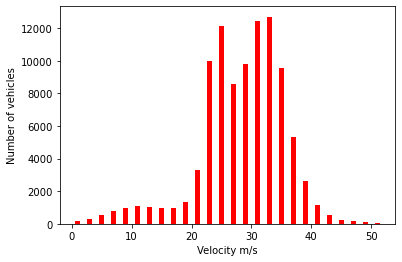

In [414]:
velGroups = []
numVehicles = []
for v in trange(0, 52, 2):
    _data = spacings[(spacings.ego_lc==0)&(spacings.foe_lc==0)&(abs(spacings.ego_vel)>=v)&(abs(spacings.ego_vel)<v+2)]
    gb = _data.groupby(['ego_id','recording_id'])
    velGroups.append(v+1)
    numVehicles.append(len(gb))
plt.bar(velGroups, numVehicles, color='red')
plt.xlabel('Velocity m/s')
plt.ylabel('Number of vehicles')

In [ ]:
pd.shuffle(spacings)

,ego_id,foe_id,recording_id,frame,ego_x,ego_y,foe_x,foe_y,ego_vel,ego_truck,...,foe_truck,foe_lc,ego_length,ego_width,foe_length,foe_width,y_marker1,y_marker2,y_bound1,y_bound2
0,3.0,10.0,1.0,3.0,186.720,22.60,207.690,26.88,35.70,0.0,...,1.0,0.0,3.94,1.92,9.20,2.50,0.0,0.0,0.0,0.0
1,3.0,10.0,1.0,8.0,193.760,22.60,212.330,26.92,35.74,0.0,...,1.0,0.0,3.94,1.92,9.20,2.50,0.0,0.0,0.0,0.0
2,3.0,10.0,1.0,13.0,200.910,22.60,217.010,26.92,35.78,0.0,...,1.0,0.0,3.94,1.92,9.20,2.50,0.0,0.0,0.0,0.0
3,3.0,10.0,1.0,18.0,208.080,22.60,221.620,26.91,35.82,0.0,...,1.0,0.0,3.94,1.92,9.20,2.50,0.0,0.0,0.0,0.0
4,3.0,10.0,1.0,23.0,215.280,22.59,226.290,26.89,35.86,0.0,...,1.0,0.0,3.94,1.92,9.20,2.50,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39379,1466.0,1465.0,60.0,24002.0,90.335,33.02,80.085,29.21,22.51,1.0,...,0.0,0.0,16.37,2.50,4.95,2.02,0.0,0.0,0.0,0.0
39380,1466.0,1465.0,60.0,24007.0,94.805,32.98,86.925,29.20,22.44,1.0,...,0.0,0.0,16.37,2.50,4.95,2.02,0.0,0.0,0.0,0.0
39381,1466.0,1465.0,60.0,24012.0,99.295,32.93,93.785,29.18,22.37,1.0,...,0.0,0.0,16.37,2.50,4.95,2.02,0.0,0.0,0.0,0.0
39382,1466.0,1465.0,60.0,24017.0,103.755,32.89,100.635,29.15,22.30,1.0,...,0.0,0.0,16.37,2.50,4.95,2.02,0.0,0.0,0.0,0.0


In [13]:
def calibrate_velocity_groups(velocityGroups, data, egolc=False, foelc=False, truck=False, ignore_lc=False, vb=2):
    spacings=data
    velGroups = []
    numVehicles = []
    Gx = []
    Gy = []
    Bx = []
    By = []
    for v in velocityGroups:
        print (f"estimating speed [{v-vb/2}, {v+vb/2}] m/s")
        _data = spacings[(abs(spacings.ego_vel)>=v-vb/2)&(abs(spacings.ego_vel)<v+vb/2)]
        if not ignore_lc:
            _data = _data[(_data.ego_lc==egolc)&(_data.foe_lc==foelc)]
        if truck:
            _data = _data[_data.ego_truck==1]
        gb = _data.groupby(['ego_id','recording_id'])
        velGroups.append(v+1)
        numVehicles.append(len(gb))
        res = calibrate_subjective_field_1(_data, gx=10, gy=2, bx=2, by=2, method='COBYLA')
        Gx.append(res[0][0])
        Gy.append(res[1][0])
        Bx.append(res[2])
        By.append(res[3])
    return velGroups, numVehicles, Gx, Gy, Bx, By

In [ ]:
# def bootstrapping_calibrate_field(velocityGroups, data, egolc=False, foelc=False, truck=False, ignore_lc=False, frac=0.85, runs=20):
#     VelG_ = []
#     nVeh_ = []
#     GX = []
#     GY = []
#     BX = []
#     BY = []
#     for it in range(runs):
#         sample = data.sample(frac=frac).reset_index(drop=True)
#         velGroups, numVehicles, gx, gy, bx, by = calibrate_velocity_groups(velocityGroups, sample, egolc=False, foelc=False, truck=False, ignore_lc=False)
#         VelG_.append(velGroups)
#         nVeh_.append(numVehicles)
#         GX.append(gx)
#         GY.append(gy)
#         BX.append(bx)
#         BY.append(by)
#     return VelG_, nVeh_, GX, GY, BX, BY


In [14]:
def bootstrapping_calibrate_field(velocityGroups, data, egolc=False, foelc=False, truck=False, ignore_lc=False, frac=0.85, runs=20, vb=1):
    spacings=data
    results = np.zeros((6,len(velocityGroups),runs))
    for v in trange(len(velocityGroups)):
        vel = velocityGroups[v]
        print (f"estimating for velocity group {vel}")
        results[0,v,:] = vel
        for it in range(runs):
            _data = spacings[(abs(spacings.ego_vel)>=vel-vb)&(abs(spacings.ego_vel)<vel+vb)].sample(frac=frac).reset_index(drop=True)
            if not ignore_lc:
                _data = _data[(_data.ego_lc==egolc)&(_data.foe_lc==foelc)]
            if truck:
                _data = _data[_data.foe_truck==1]
            gb = _data.groupby(['ego_id','recording_id'])
            res = calibrate_subjective_field_1(_data, gx=10, gy=2, bx=2, by=2, method='COBYLA')
            results[1,v,it] = len(gb)
            results[2,v,it] = res[0][0]
            results[3,v,it] = res[1][0]
            results[4,v,it] = res[2]
            results[5,v,it] = res[3]
    return results

(0.0, 52.0)

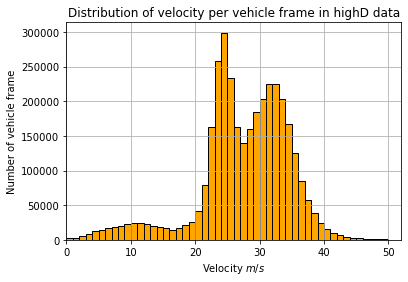

In [100]:
# vehicle velocity distribution plot
plt.hist(spacings.ego_vel.abs(), bins=np.arange(0, 52, 1), facecolor='orange', edgecolor='black')
plt.title("Distribution of velocity per vehicle frame in highD data")
plt.grid()
plt.xlabel('Velocity $m/s$')
plt.ylabel('Number of vehicle frame')
plt.xlim(0,52)

In [28]:
boot = bootstrapping_calibrate_field(np.arange(29,31,1), spacings, frac=0.85, runs=3)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\Lucas\AppData\Local\Temp/ipykernel_9848/150218918.py:15: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(jlll_gx, gx, args=(gy,bx,by), n=2)
C:\Users\Lucas\AppData\Local\Temp/ipykernel_9848/150218918.py:18: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(jlll_gy, gy, args=(gx,bx,by), n=2)
  1%|          | 1/100 [00:03<05:54,  3.58s/it]

---gx:[11.34761211] gy:[1.08599336] bx:4.832983971304568 by:6.526316643758256---


  2%|▏         | 2/100 [00:09<08:29,  5.20s/it]

---gx:[16.79213633] gy:[1.65263203] bx:2.7665319748960866 by:4.859903144007226---


  3%|▎         | 3/100 [00:14<07:35,  4.69s/it]

---gx:[13.75248555] gy:[1.57108906] bx:3.3433502111623876 by:5.416884380550873---


  4%|▍         | 4/100 [00:17<07:03,  4.41s/it]

---gx:[14.93944141] gy:[1.60429219] bx:3.1288489706850737 by:5.205122865568035---


  5%|▌         | 5/100 [00:21<06:38,  4.20s/it]

---gx:[14.54691914] gy:[1.59256172] bx:3.2037708033813246 by:5.282332798964419---


  6%|▌         | 6/100 [00:25<06:18,  4.03s/it]

---gx:[14.68934141] gy:[1.59715625] bx:3.176204777676603 by:5.252452893459307---


  6%|▌         | 6/100 [00:27<07:10,  4.58s/it]

---gx:[14.63670703] gy:[1.59510313] bx:3.1870503360339923 by:5.2659252159247245---



  1%|          | 1/100 [00:03<05:47,  3.51s/it]

---gx:[11.28793008] gy:[1.08599336] bx:4.8503011598148875 by:6.591184314958407---


  2%|▏         | 2/100 [00:10<08:46,  5.37s/it]

---gx:[16.69896289] gy:[1.65478516] bx:2.7708393053491975 by:4.857181029715748---


  3%|▎         | 3/100 [00:14<07:42,  4.77s/it]

---gx:[13.68490273] gy:[1.57134492] bx:3.3507905642134115 by:5.430737883560271---


  4%|▍         | 4/100 [00:18<07:15,  4.54s/it]

---gx:[14.86308125] gy:[1.60522461] bx:3.1359271578609076 by:5.213591639756075---


  5%|▌         | 5/100 [00:22<06:46,  4.27s/it]

---gx:[14.4750418] gy:[1.59356172] bx:3.2105594712231613 by:5.290863487420829---


  6%|▌         | 6/100 [00:25<06:24,  4.09s/it]

---gx:[14.6155668] gy:[1.59785625] bx:3.18382311473729 by:5.262733343715277---


  6%|▌         | 6/100 [00:27<07:18,  4.66s/it]

---gx:[14.56468555] gy:[1.59610313] bx:3.1937834395011517 by:5.274280833746042---



  1%|          | 1/100 [00:03<05:51,  3.55s/it]

---gx:[11.30399922] gy:[1.08706992] bx:4.846031485108999 by:6.531776103226062---


  2%|▏         | 2/100 [00:10<08:40,  5.31s/it]

---gx:[16.69809805] gy:[1.65494102] bx:2.7791862579201805 by:4.857051999058423---


  3%|▎         | 3/100 [00:14<07:41,  4.75s/it]

---gx:[13.71704102] gy:[1.57290977] bx:3.3547904661729366 by:5.411554147316955---


  4%|▍         | 4/100 [00:18<07:07,  4.46s/it]

---gx:[14.87744141] gy:[1.60615703] bx:3.141548417026689 by:5.202735470831551---


  5%|▌         | 5/100 [00:21<06:38,  4.19s/it]

---gx:[14.49511719] gy:[1.59452656] bx:3.215577160422861 by:5.278499813495216---


  6%|▌         | 6/100 [00:25<06:16,  4.00s/it]

---gx:[14.63320078] gy:[1.59902109] bx:3.188816793352245 by:5.24937847632824---


  6%|▌         | 6/100 [00:27<07:12,  4.60s/it]

---gx:[14.58300781] gy:[1.59726797] bx:3.198659740888518 by:5.260673162190244---



  1%|          | 1/100 [00:03<06:15,  3.79s/it]

---gx:[11.57006836] gy:[1.08955547] bx:4.570183311875756 by:6.3513845332646515---


  2%|▏         | 2/100 [00:10<09:22,  5.74s/it]

---gx:[16.82687187] gy:[1.65201133] bx:2.8136256526218704 by:4.946391075238012---


  3%|▎         | 3/100 [00:15<08:13,  5.08s/it]

---gx:[14.25166484] gy:[1.58052227] bx:3.271529373619563 by:5.439691848172638---


  4%|▍         | 4/100 [00:19<07:39,  4.78s/it]

---gx:[15.21391133] gy:[1.60951914] bx:3.1058976231654203 by:5.250587363306547---


  5%|▌         | 5/100 [00:23<07:07,  4.50s/it]

---gx:[14.90141133] gy:[1.59932109] bx:3.1621084327314746 by:5.319253214206889---


  6%|▌         | 6/100 [00:27<06:46,  4.32s/it]

---gx:[15.01136289] gy:[1.60297148] bx:3.142357362817676 by:5.294779399336248---


  6%|▌         | 6/100 [00:29<07:45,  4.96s/it]

---gx:[14.97244453] gy:[1.60170664] bx:3.1493259132021016 by:5.303289089319824---



  1%|          | 1/100 [00:03<06:34,  3.99s/it]

---gx:[11.58207539] gy:[1.08912305] bx:4.529768859193202 by:6.335154389789479---


  2%|▏         | 2/100 [00:11<09:26,  5.78s/it]

---gx:[16.73720469] gy:[1.65050234] bx:2.828407115994118 by:4.947222805425901---


  3%|▎         | 3/100 [00:15<08:20,  5.16s/it]

---gx:[14.27006367] gy:[1.57980156] bx:3.271887324047763 by:5.434814465663007---


  4%|▍         | 4/100 [00:19<07:38,  4.78s/it]

---gx:[15.18393789] gy:[1.60861016] bx:3.111149858560054 by:5.24744115660309---


  5%|▌         | 5/100 [00:23<07:15,  4.58s/it]

---gx:[14.88544219] gy:[1.59841211] bx:3.1656066201547906 by:5.3159351483195305---


  6%|▌         | 6/100 [00:27<06:50,  4.37s/it]

---gx:[14.99007852] gy:[1.60223008] bx:3.1462891251397487 by:5.290546594439002---


  6%|▌         | 6/100 [00:30<07:52,  5.03s/it]

---gx:[14.952525] gy:[1.60056523] bx:3.153767132118002 by:5.301664746484877---



  1%|          | 1/100 [00:03<06:25,  3.89s/it]

---gx:[11.57818086] gy:[1.08832305] bx:4.4681685754812985 by:6.438810578219304---


  2%|▏         | 2/100 [00:10<09:23,  5.75s/it]

---gx:[16.6656832] gy:[1.65257617] bx:2.8342607562022013 by:4.93014744922894---


  3%|▎         | 3/100 [00:15<08:23,  5.19s/it]

---gx:[14.27764375] gy:[1.57795742] bx:3.2633771801347478 by:5.452567227669896---


  4%|▍         | 4/100 [00:19<07:45,  4.85s/it]

---gx:[15.15937969] gy:[1.608475] bx:3.1083695767526494 by:5.250999660196822---


  5%|▌         | 5/100 [00:23<07:17,  4.60s/it]

---gx:[14.87193789] gy:[1.59778867] bx:3.1608123588725943 by:5.323900619242218---


  6%|▌         | 6/100 [00:27<06:54,  4.41s/it]

---gx:[14.97276797] gy:[1.6015832] bx:3.142571086004702 by:5.298183200173991---


  6%|▌         | 6/100 [00:30<07:53,  5.04s/it]

---gx:[14.93732344] gy:[1.60031836] bx:3.1489377001068246 by:5.306884622346939---


In [76]:
np.concatenate([np.array([[[1,2,3],[4,5,6]]]),np.array([[[5,2,6],[8,5,1]]]),np.array([[[0,2,6],[8,5,1]]])], axis=1)

array([[[1, 2, 3],
        [4, 5, 6],
        [5, 2, 6],
        [8, 5, 1],
        [0, 2, 6],
        [8, 5, 1]]])

In [46]:
[np.array([[1,2,3],[4,5,6]]),np.array([[5,2,6],[8,5,1]])][1]

array([[5, 2, 6],
       [8, 5, 1]])

In [87]:
cali_truck = calibrate_velocity_groups(np.arange(2,46,1), vb=4, data=spacings, truck=1, ignore_lc=True)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\Lucas\AppData\Local\Temp/ipykernel_71404/150218918.py:15: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(jlll_gx, gx, args=(gy,bx,by), n=2)
C:\Users\Lucas\AppData\Local\Temp/ipykernel_71404/150218918.py:18: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(jlll_gy, gy, args=(gx,bx,by), n=2)
  2%|▏         | 2/100 [00:00<00:33,  2.97it/s]

---gx:[5.21357891] gy:[0.95984023] bx:2.1273972656250004 by:10.0---
---gx:[5.5238375] gy:[1.50354141] bx:2.0648834255061295 by:4.197589498077126---


  4%|▍         | 4/100 [00:01<00:20,  4.80it/s]

---gx:[5.37554414] gy:[1.34802383] bx:2.094277905742987 by:5.841047228458629---
---gx:[5.4549457] gy:[1.43464961] bx:2.0753431742411084 by:4.93484882597409---


  7%|▋         | 7/100 [00:01<00:12,  7.34it/s]

---gx:[5.39419883] gy:[1.39481055] bx:2.0842784584556497 by:5.365519003195714---
---gx:[5.42491641] gy:[1.41570664] bx:2.0795747936020814 by:5.140573781496413---
---gx:[5.40949141] gy:[1.40525273] bx:2.081678624718456 by:5.25310296779949---


  7%|▋         | 7/100 [00:01<00:19,  4.72it/s]


---gx:[5.41667148] gy:[1.41072383] bx:2.0805287830582766 by:5.19442142198577---


  1%|          | 1/100 [00:00<00:40,  2.43it/s]

---gx:[4.74492891] gy:[0.98218945] bx:2.674347954399664 by:10.0---


  2%|▏         | 2/100 [00:00<00:29,  3.36it/s]

---gx:[6.1032832] gy:[1.515725] bx:2.2844928241149747 by:4.69670480763859---


  4%|▍         | 4/100 [00:01<00:22,  4.32it/s]

---gx:[5.35435977] gy:[1.40171133] bx:2.4198615262472325 by:6.419555990449464---
---gx:[5.62603242] gy:[1.46938242] bx:2.3573136379079145 by:5.342114784017379---


  6%|▌         | 6/100 [00:01<00:17,  5.30it/s]

---gx:[5.50118828] gy:[1.43369375] bx:2.3874079479828505 by:5.904694164809766---
---gx:[5.56505312] gy:[1.45503398] bx:2.3702214812229236 by:5.562446922097153---


  8%|▊         | 8/100 [00:01<00:13,  6.68it/s]

---gx:[5.5238375] gy:[1.44229453] bx:2.3806490299837506 by:5.765142130112284---
---gx:[5.54942812] gy:[1.44990703] bx:2.3742885728585845 by:5.64311416833162---


  8%|▊         | 8/100 [00:01<00:19,  4.68it/s]


---gx:[5.53394727] gy:[1.44546836] bx:2.377931263891075 by:5.714174772208896---


  1%|          | 1/100 [00:00<00:47,  2.10it/s]

---gx:[4.83389609] gy:[0.96431133] bx:2.540306290294632 by:10.0---


  2%|▏         | 2/100 [00:00<00:37,  2.59it/s]

---gx:[5.82570703] gy:[1.49913516] bx:2.182972036735242 by:4.4839421964694255---


  3%|▎         | 3/100 [00:01<00:30,  3.18it/s]

---gx:[5.17263086] gy:[1.3692082] bx:2.29832902255394 by:6.127910791520717---


  4%|▍         | 4/100 [00:01<00:26,  3.59it/s]

---gx:[5.39079258] gy:[1.44243867] bx:2.2410831410410403 by:5.156880335781825---


  6%|▌         | 6/100 [00:01<00:20,  4.63it/s]

---gx:[5.28288242] gy:[1.40636172] bx:2.267957203605854 by:5.62983907029053---
---gx:[5.33454023] gy:[1.42648125] bx:2.2532854523799593 by:5.362121923568284---


  7%|▋         | 7/100 [00:01<00:24,  3.75it/s]


---gx:[5.3045668] gy:[1.41520664] bx:2.261489201687874 by:5.511405096808015---
---gx:[5.32155664] gy:[1.4214543] bx:2.2568305514992955 by:5.428204213364542---


  1%|          | 1/100 [00:00<00:29,  3.34it/s]

---gx:[4.07681602] gy:[0.97413281] bx:3.6106813395034827 by:9.673810627040172---


  2%|▏         | 2/100 [00:00<00:27,  3.58it/s]

---gx:[5.62119375] gy:[1.50640352] bx:2.3589837805424376 by:4.349426878797514---


  3%|▎         | 3/100 [00:00<00:25,  3.81it/s]

---gx:[4.56089102] gy:[1.36699922] bx:2.6737622233500815 by:5.883843205796982---


  4%|▍         | 4/100 [00:01<00:24,  3.94it/s]

---gx:[4.89916992] gy:[1.44463594] bx:2.5359198515508385 by:5.004081053868881---


  6%|▌         | 6/100 [00:01<00:19,  4.84it/s]

---gx:[4.75522695] gy:[1.40752656] bx:2.59821348609204 by:5.410360137807286---
---gx:[4.8214332] gy:[1.42715781] bx:2.565786667209383 by:5.192893840596376---


  7%|▋         | 7/100 [00:01<00:22,  4.18it/s]


---gx:[4.7875418] gy:[1.41661562] bx:2.58279744103687 by:5.308596426944116---
---gx:[4.80556406] gy:[1.422175] bx:2.573712627182349 by:5.247396970849873---


  1%|          | 1/100 [00:00<00:22,  4.38it/s]

---gx:[3.75308555] gy:[0.99063437] bx:5.250227225232462 by:9.814640260728394---


  2%|▏         | 2/100 [00:00<00:33,  2.94it/s]

---gx:[5.22699492] gy:[1.54693086] bx:2.724360018573432 by:4.0225032453668295---


  3%|▎         | 3/100 [00:00<00:28,  3.37it/s]

---gx:[4.42914336] gy:[1.36763164] bx:3.4093575698660565 by:5.587906797256728---


  4%|▍         | 4/100 [00:01<00:27,  3.44it/s]

---gx:[4.8200125] gy:[1.46567617] bx:3.042843846586745 by:4.732394069037807---


  6%|▌         | 6/100 [00:01<00:21,  4.34it/s]

---gx:[4.63387734] gy:[1.42183086] bx:3.210188915345281 by:5.097055163312379---
---gx:[4.72693906] gy:[1.44321523] bx:3.1278493237866734 by:4.91785007294594---


  6%|▌         | 6/100 [00:01<00:26,  3.50it/s]


---gx:[4.68075234] gy:[1.43277305] bx:3.1684773141773133 by:5.004828033023394---


  1%|          | 1/100 [00:00<00:23,  4.24it/s]

---gx:[3.91561562] gy:[0.99833516] bx:5.795616226026002 by:9.927590293885393---


  2%|▏         | 2/100 [00:00<00:35,  2.73it/s]

---gx:[5.23289844] gy:[1.56943594] bx:2.6525845041511005 by:4.035402471764686---


  3%|▎         | 3/100 [00:00<00:31,  3.09it/s]

---gx:[4.4851957] gy:[1.3816918] bx:3.276040562004861 by:5.653848644414265---


  4%|▍         | 4/100 [00:01<00:29,  3.24it/s]

---gx:[4.85449219] gy:[1.48473086] bx:2.8661072740293 by:4.848624763519156---


  6%|▌         | 6/100 [00:01<00:23,  4.04it/s]

---gx:[4.62225859] gy:[1.44332695] bx:3.031883487280059 by:5.184266362250754---
---gx:[4.71483203] gy:[1.4630582] bx:2.9544068449394936 by:5.028072743679132---


  6%|▌         | 6/100 [00:01<00:28,  3.29it/s]


---gx:[4.67963164] gy:[1.45368086] bx:2.987530615197038 by:5.102702137501275---


  1%|          | 1/100 [00:00<00:24,  4.01it/s]

---gx:[4.13236836] gy:[1.01473672] bx:6.663719657500822 by:10.0---


  2%|▏         | 2/100 [00:00<00:40,  2.45it/s]

---gx:[5.60137422] gy:[1.59491484] bx:2.7867762470306845 by:4.185801885464702---


  3%|▎         | 3/100 [00:01<00:35,  2.74it/s]

---gx:[4.62080547] gy:[1.41831289] bx:3.706747406578124 by:5.929492113205921---


  4%|▍         | 4/100 [00:01<00:33,  2.91it/s]

---gx:[5.02070781] gy:[1.52017539] bx:3.1503201743905835 by:5.020210446455078---


  6%|▌         | 6/100 [00:01<00:26,  3.55it/s]

---gx:[4.79810742] gy:[1.47710664] bx:3.3806466080246973 by:5.426401423556265---
---gx:[4.89029258] gy:[1.4988793] bx:3.2681255907180415 by:5.2270637864656315---


  6%|▌         | 6/100 [00:02<00:32,  2.89it/s]


---gx:[4.85313906] gy:[1.48843711] bx:3.3176858969431002 by:5.323689911206726---


  1%|          | 1/100 [00:00<00:37,  2.67it/s]

---gx:[6.07260977] gy:[1.00907734] bx:3.5891887792167054 by:10.0---


  2%|▏         | 2/100 [00:00<00:43,  2.27it/s]

---gx:[8.82364219] gy:[1.57284219] bx:2.262785644317607 by:4.308500300679378---


  3%|▎         | 3/100 [00:01<00:37,  2.57it/s]

---gx:[6.61510195] gy:[1.41883359] bx:2.6402974231473038 by:5.928624489510667---


  4%|▍         | 4/100 [00:01<00:34,  2.76it/s]

---gx:[7.41237695] gy:[1.5055918] bx:2.4767323770171976 by:5.054419227232806---


  5%|▌         | 5/100 [00:01<00:32,  2.92it/s]

---gx:[7.08474023] gy:[1.46716172] bx:2.5410115070062154 by:5.445490152249772---


  6%|▌         | 6/100 [00:02<00:35,  2.62it/s]


---gx:[7.21583203] gy:[1.48619297] bx:2.5113748854364353 by:5.254620599300856---
---gx:[7.15581758] gy:[1.47711563] bx:2.52496581427417 by:5.345726179745308---


  1%|          | 1/100 [00:00<00:43,  2.30it/s]

---gx:[7.51743398] gy:[1.00992148] bx:3.8621860923633875 by:9.446080908838457---


  2%|▏         | 2/100 [00:00<00:38,  2.57it/s]

---gx:[10.25370625] gy:[1.56811523] bx:2.5457781383331857 by:4.5118831807143325---


  3%|▎         | 3/100 [00:01<00:34,  2.81it/s]

---gx:[8.53750937] gy:[1.43198477] bx:2.865498627081312 by:6.139281437768702---


  4%|▍         | 4/100 [00:01<00:32,  2.95it/s]

---gx:[9.04097148] gy:[1.51099805] bx:2.7375576929081316 by:5.247115333646165---


  6%|▌         | 6/100 [00:01<00:25,  3.62it/s]

---gx:[8.84956523] gy:[1.47506523] bx:2.7923095752550013 by:5.663914859784217---
---gx:[8.93252891] gy:[1.4939082] bx:2.7639647326348187 by:5.4486336268482045---


  7%|▋         | 7/100 [00:02<00:29,  3.12it/s]

---gx:[8.88897187] gy:[1.48424258] bx:2.7784262532158697 by:5.559768978553061---
---gx:[8.91113281] gy:[1.48942539] bx:2.77069503817933 by:5.500478065322398---



  1%|          | 1/100 [00:00<00:34,  2.85it/s]

---gx:[8.34105273] gy:[1.00135313] bx:4.176978140604421 by:8.336525320297236---


  2%|▏         | 2/100 [00:00<00:42,  2.29it/s]

---gx:[10.4043293] gy:[1.5556082] bx:2.667341151695784 by:4.479612424220518---


  3%|▎         | 3/100 [00:01<00:42,  2.26it/s]

---gx:[9.11726406] gy:[1.42421641] bx:2.9267154464147676 by:5.867629942292651---


  4%|▍         | 4/100 [00:01<00:42,  2.27it/s]

---gx:[9.2896832] gy:[1.4995] bx:2.806844804034659 by:5.1330764540347396---


  6%|▌         | 6/100 [00:02<00:29,  3.20it/s]

---gx:[9.21439961] gy:[1.46629688] bx:2.8567224342559974 by:5.4619462970946655---
---gx:[9.26196289] gy:[1.48261016] bx:2.8315536718708043 by:5.300233301489086---


  6%|▌         | 6/100 [00:02<00:37,  2.54it/s]


---gx:[9.21391133] gy:[1.47420938] bx:2.844140162064957 by:5.386013024249679---


  1%|          | 1/100 [00:00<00:35,  2.80it/s]

---gx:[8.61036328] gy:[1.01802227] bx:4.6859141864370315 by:8.426298244534532---


  2%|▏         | 2/100 [00:00<00:41,  2.39it/s]

---gx:[10.29019492] gy:[1.58756992] bx:2.852078151200106 by:4.620819707464547---


  3%|▎         | 3/100 [00:01<00:40,  2.39it/s]

---gx:[9.11627852] gy:[1.45979609] bx:3.116647803558291 by:5.999124946474212---


  4%|▍         | 4/100 [00:01<00:39,  2.41it/s]

---gx:[9.2209707] gy:[1.53181758] bx:2.9756084836218917 by:5.286030175341389---


  6%|▌         | 6/100 [00:02<00:28,  3.34it/s]

---gx:[9.15153477] gy:[1.50051172] bx:3.0321100347109966 by:5.598999506077428---
---gx:[9.19430352] gy:[1.51534844] bx:3.006034427905483 by:5.450362708916016---


  6%|▌         | 6/100 [00:02<00:35,  2.66it/s]


---gx:[9.15259961] gy:[1.50832422] bx:3.015521184260757 by:5.523284697882547---


  1%|          | 1/100 [00:00<00:29,  3.30it/s]

---gx:[10.33817891] gy:[1.0306293] bx:6.360374233659607 by:7.539026945871793---


  2%|▏         | 2/100 [00:00<00:37,  2.64it/s]

---gx:[11.65033477] gy:[1.59390586] bx:2.5781209257410835 by:5.36249815940393---


  3%|▎         | 3/100 [00:01<00:41,  2.36it/s]

---gx:[8.24955586] gy:[1.54015078] bx:2.8389974153035773 by:6.387573307575683---


  5%|▌         | 5/100 [00:01<00:29,  3.24it/s]

---gx:[8.29385703] gy:[1.58320781] bx:2.766225276328107 by:5.832824534193378---
---gx:[8.27349336] gy:[1.56241172] bx:2.8022992079903593 by:6.100604098804674---


  6%|▌         | 6/100 [00:02<00:31,  2.99it/s]


---gx:[8.34009961] gy:[1.57295391] bx:2.7873807804491744 by:5.959185679875536---
---gx:[8.30913789] gy:[1.56729453] bx:2.7957341155816815 by:6.034445317593841---


  1%|          | 1/100 [00:00<00:26,  3.72it/s]

---gx:[12.10243906] gy:[1.02079609] bx:5.279008488745605 by:7.336357067325222---


  2%|▏         | 2/100 [00:00<00:32,  2.97it/s]

---gx:[20.578225] gy:[1.54315703] bx:2.0 by:5.47147883076785---


  3%|▎         | 3/100 [00:01<00:35,  2.74it/s]

---gx:[11.50594766] gy:[1.52479063] bx:2.4756060140054035 by:6.123738198849244---


  4%|▍         | 4/100 [00:01<00:30,  3.15it/s]

---gx:[14.14760508] gy:[1.53719766] bx:2.492391480965542 by:5.735761536308949---


  5%|▌         | 5/100 [00:01<00:27,  3.51it/s]

---gx:[14.33076641] gy:[1.52049609] bx:2.5184702032411117 by:5.85992459616307---


  6%|▌         | 6/100 [00:01<00:29,  3.19it/s]


---gx:[14.44355937] gy:[1.52513477] bx:2.5096154251778664 by:5.811553812389007---
---gx:[14.40390859] gy:[1.5230375] bx:2.5136623825348945 by:5.832371082838235---


  1%|          | 1/100 [00:00<00:23,  4.27it/s]

---gx:[12.21923828] gy:[1.05342266] bx:9.081967917601554 by:9.16936028959505---


  2%|▏         | 2/100 [00:00<00:29,  3.35it/s]

---gx:[18.67432812] gy:[1.62919453] bx:2.6753117728846996 by:5.472163548102912---


  3%|▎         | 3/100 [00:00<00:29,  3.26it/s]

---gx:[14.66689219] gy:[1.54529844] bx:3.4572442415024214 by:6.66937611577464---


  4%|▍         | 4/100 [00:01<00:26,  3.61it/s]

---gx:[17.17412812] gy:[1.58045469] bx:3.033337412725504 by:6.150142720401532---


  5%|▌         | 5/100 [00:01<00:24,  3.89it/s]

---gx:[15.92266328] gy:[1.56926836] bx:3.233379654104348 by:6.3320688217203465---


  7%|▋         | 7/100 [00:01<00:21,  4.40it/s]

---gx:[16.53683281] gy:[1.57278633] bx:3.142773870135601 by:6.264818306936299---
---gx:[16.26412773] gy:[1.57170977] bx:3.1827533744484366 by:6.288694301865038---


  8%|▊         | 8/100 [00:02<00:23,  3.89it/s]


---gx:[16.38580977] gy:[1.57220977] bx:3.164900859333615 by:6.277775173380712---
---gx:[16.33082227] gy:[1.57162148] bx:3.173782197728627 by:6.286916306103329---


  1%|          | 1/100 [00:00<00:22,  4.41it/s]

---gx:[12.24102266] gy:[1.03007344] bx:10.0 by:10.0---


  2%|▏         | 2/100 [00:00<00:25,  3.83it/s]

---gx:[12.68370547] gy:[1.62728555] bx:3.7912612636380394 by:4.839717184650393---


  3%|▎         | 3/100 [00:00<00:27,  3.57it/s]

---gx:[17.92461641] gy:[1.47377695] bx:3.164848372731976 by:6.865695828357028---


  4%|▍         | 4/100 [00:01<00:25,  3.81it/s]

---gx:[16.25128828] gy:[1.55809375] bx:3.400147944820537 by:5.765115568032646---


  6%|▌         | 6/100 [00:01<00:21,  4.30it/s]

---gx:[16.89988164] gy:[1.52210508] bx:3.3181080544827344 by:6.256881574264085---
---gx:[16.67616055] gy:[1.53992734] bx:3.34133544043552 by:6.015305975604797---


  7%|▋         | 7/100 [00:01<00:22,  4.10it/s]


---gx:[16.73129219] gy:[1.5320707] bx:3.3388783627563354 by:6.124003258517068---
---gx:[16.7371957] gy:[1.53568867] bx:3.334498989083793 by:6.073303743538518---


  1%|          | 1/100 [00:00<00:25,  3.89it/s]

---gx:[12.42200742] gy:[1.02959687] bx:5.09322391946888 by:10.0---


  2%|▏         | 2/100 [00:00<00:32,  2.97it/s]

---gx:[20.14524023] gy:[1.60851016] bx:2.4198280466473965 by:5.0358759030141655---


  3%|▎         | 3/100 [00:00<00:32,  2.96it/s]

---gx:[14.03214727] gy:[1.49688203] bx:3.3730067063557905 by:6.432856598807955---


  4%|▍         | 4/100 [00:01<00:32,  2.98it/s]

---gx:[16.95988164] gy:[1.5534668] bx:2.9333898199646513 by:5.797508747680068---


  5%|▌         | 5/100 [00:01<00:28,  3.34it/s]

---gx:[15.7808707] gy:[1.53228242] bx:3.0978665548783715 by:6.057040274741273---


  6%|▌         | 6/100 [00:01<00:26,  3.57it/s]

---gx:[16.24308477] gy:[1.54140391] bx:3.0337177997189566 by:5.948515494158675---


  7%|▋         | 7/100 [00:02<00:28,  3.25it/s]


---gx:[16.06700352] gy:[1.53769766] bx:3.0584512882081274 by:5.992889621567398---
---gx:[16.13858086] gy:[1.53945078] bx:3.0482117605249197 by:5.9721879829832085---


  1%|          | 1/100 [00:00<00:31,  3.19it/s]

---gx:[11.44697734] gy:[1.04081563] bx:6.831532784969422 by:10.0---


  2%|▏         | 2/100 [00:00<00:33,  2.94it/s]

---gx:[11.67470469] gy:[1.65219961] bx:3.3512616072591226 by:4.50911558652294---


  3%|▎         | 3/100 [00:01<00:37,  2.61it/s]

---gx:[15.67403984] gy:[1.4776832] bx:2.9642383134654864 by:6.272582095442288---


  4%|▍         | 4/100 [00:01<00:38,  2.50it/s]

---gx:[14.51421602] gy:[1.56771523] bx:3.02015100690223 by:5.498088576279726---


  6%|▌         | 6/100 [00:01<00:27,  3.42it/s]

---gx:[14.72973633] gy:[1.53710938] bx:3.0280329896050038 by:5.80517088338926---
---gx:[14.75640352] gy:[1.55009297] bx:3.0085220455875317 by:5.679150341591537---


  6%|▌         | 6/100 [00:02<00:33,  2.80it/s]


---gx:[14.67646953] gy:[1.54462188] bx:3.026153306564759 by:5.733671093910803---


  1%|          | 1/100 [00:00<00:42,  2.33it/s]

---gx:[11.40424102] gy:[1.03340312] bx:3.7147686968552303 by:6.373491611631237---


  2%|▏         | 2/100 [00:01<00:56,  1.75it/s]

---gx:[16.24945586] gy:[1.56093516] bx:2.415381063520248 by:5.1014768326404845---


  3%|▎         | 3/100 [00:01<00:49,  1.96it/s]

---gx:[13.00248555] gy:[1.50897734] bx:2.6877037337154417 by:5.529285127941706---


  4%|▍         | 4/100 [00:01<00:46,  2.07it/s]

---gx:[13.89848164] gy:[1.5297293] bx:2.6285881077710505 by:5.370180895673728---


  5%|▌         | 5/100 [00:02<00:43,  2.18it/s]

---gx:[13.71951484] gy:[1.52234922] bx:2.6459082676483203 by:5.427096911388594---


  5%|▌         | 5/100 [00:02<00:49,  1.90it/s]


---gx:[13.77352578] gy:[1.52537891] bx:2.6396218938603835 by:5.404051016012254---


  1%|          | 1/100 [00:01<01:59,  1.21s/it]

---gx:[11.64168984] gy:[1.00266133] bx:2.981125056912206 by:5.751195628084077---


  2%|▏         | 2/100 [00:02<02:00,  1.23s/it]

---gx:[14.83358438] gy:[1.50085234] bx:2.3097493355369614 by:4.8084891259198335---


  3%|▎         | 3/100 [00:03<01:42,  1.06s/it]

---gx:[12.74193164] gy:[1.45446562] bx:2.425048303017298 by:5.118104612642666---


  4%|▍         | 4/100 [00:04<01:34,  1.02it/s]

---gx:[13.16030039] gy:[1.47205547] bx:2.399251481127978 by:5.009885915218034---


  4%|▍         | 4/100 [00:04<01:50,  1.15s/it]

---gx:[13.06723867] gy:[1.46590781] bx:2.4072073909853273 by:5.048225465118051---



  1%|          | 1/100 [00:02<04:14,  2.57s/it]

---gx:[11.91236523] gy:[0.9936082] bx:2.822568534749218 by:5.887376123139618---


  2%|▏         | 2/100 [00:06<05:10,  3.17s/it]

---gx:[14.69986289] gy:[1.48959023] bx:2.256985836074938 by:4.864926215218536---


  3%|▎         | 3/100 [00:08<04:39,  2.88s/it]

---gx:[12.71172578] gy:[1.44350352] bx:2.351091452974873 by:5.222186428323774---


  4%|▍         | 4/100 [00:11<04:19,  2.71s/it]

---gx:[13.07226562] gy:[1.4625582] bx:2.3278844334393973 by:5.0858961578428294---


  4%|▍         | 4/100 [00:12<04:56,  3.09s/it]

---gx:[12.98154531] gy:[1.45533398] bx:2.3358862284638304 by:5.138022997403767---



  1%|          | 1/100 [00:04<07:32,  4.57s/it]

---gx:[12.00248555] gy:[0.99902344] bx:2.970924680731824 by:5.5240603823095835---


  2%|▏         | 2/100 [00:09<07:40,  4.70s/it]

---gx:[15.08055469] gy:[1.48510742] bx:2.2993089050747417 by:4.9027601128313645---


  3%|▎         | 3/100 [00:13<07:28,  4.62s/it]

---gx:[12.9979793] gy:[1.45453398] bx:2.3858756740769764 by:5.14443592844613---


  4%|▍         | 4/100 [00:18<07:11,  4.50s/it]

---gx:[13.31418555] gy:[1.46771758] bx:2.368027605035108 by:5.051721744048003---


  4%|▍         | 4/100 [00:20<08:16,  5.17s/it]

---gx:[13.25105313] gy:[1.46279063] bx:2.3738680118109197 by:5.085835142891713---



  1%|          | 1/100 [00:07<11:42,  7.10s/it]

---gx:[11.7728168] gy:[1.00180898] bx:2.950715328043324 by:5.709299100305208---


  2%|▏         | 2/100 [00:17<15:12,  9.31s/it]

---gx:[14.1803875] gy:[1.49732617] bx:2.272503498309733 by:4.937775377221997---


  3%|▎         | 3/100 [00:25<13:55,  8.61s/it]

---gx:[12.16828047] gy:[1.46134922] bx:2.3627124862628333 by:5.246384682212787---


  4%|▍         | 4/100 [00:32<12:49,  8.01s/it]

---gx:[12.44913047] gy:[1.4774625] bx:2.3410118020349757 by:5.123311897101069---


  4%|▍         | 4/100 [00:36<14:42,  9.19s/it]

---gx:[12.37989453] gy:[1.47101484] bx:2.3486198211298897 by:5.172477396867662---



  1%|          | 1/100 [00:08<13:44,  8.33s/it]

---gx:[11.49516133] gy:[1.00762422] bx:2.8793925377200043 by:5.8011183598524285---


  2%|▏         | 2/100 [00:20<17:37, 10.79s/it]

---gx:[12.85424805] gy:[1.51064219] bx:2.248522233458394 by:4.954198681502291---


  3%|▎         | 3/100 [00:29<15:50,  9.80s/it]

---gx:[11.39008086] gy:[1.47070312] bx:2.3180957024057185 by:5.293045681814607---


  4%|▍         | 4/100 [00:37<14:21,  8.97s/it]

---gx:[11.53271484] gy:[1.48871367] bx:2.2972863899873586 by:5.156450644179409---


  4%|▍         | 4/100 [00:41<16:39, 10.42s/it]

---gx:[11.48408672] gy:[1.48167773] bx:2.3050945913328973 by:5.210621589857142---



  1%|          | 1/100 [00:07<11:53,  7.20s/it]

---gx:[11.00268555] gy:[1.01518086] bx:2.9009903182480126 by:5.860454403567433---


  2%|▏         | 2/100 [00:19<16:18,  9.98s/it]

---gx:[12.08720234] gy:[1.52366992] bx:2.233717650172368 by:4.986633321224086---


  3%|▎         | 3/100 [00:26<14:22,  8.89s/it]

---gx:[10.74247578] gy:[1.48264258] bx:2.2950684039188074 by:5.344493806608617---


  4%|▍         | 4/100 [00:33<13:07,  8.20s/it]

---gx:[10.8511625] gy:[1.50158555] bx:2.273873160617845 by:5.196661008096812---


  4%|▍         | 4/100 [00:37<15:08,  9.46s/it]

---gx:[10.80766133] gy:[1.49396133] bx:2.2822540388122396 by:5.257099083846225---



  1%|          | 1/100 [00:05<09:17,  5.63s/it]

---gx:[9.95147187] gy:[1.01938711] bx:2.782355093921878 by:6.296378370772337---


  2%|▏         | 2/100 [00:13<11:43,  7.18s/it]

---gx:[10.58872305] gy:[1.54425703] bx:2.175640064013944 by:4.931128950661844---


  3%|▎         | 3/100 [00:19<10:17,  6.36s/it]

---gx:[9.25980977] gy:[1.484775] bx:2.2557307957527746 by:5.467387851969167---


  4%|▍         | 4/100 [00:24<09:31,  5.95s/it]

---gx:[9.40159961] gy:[1.51279531] bx:2.2239838385960535 by:5.236080253696357---


  4%|▍         | 4/100 [00:27<11:02,  6.90s/it]

---gx:[9.32947813] gy:[1.5015207] bx:2.2365560306900814 by:5.331709227728928---



  1%|          | 1/100 [00:02<03:37,  2.20s/it]

---gx:[8.79199219] gy:[1.02284922] bx:2.6576057541178963 by:6.294677988783646---


  2%|▏         | 2/100 [00:06<05:40,  3.47s/it]

---gx:[9.70604297] gy:[1.54980469] bx:2.0500653633609436 by:4.898894993646099---


  3%|▎         | 3/100 [00:09<05:12,  3.22s/it]

---gx:[7.72722734] gy:[1.49121094] bx:2.133971857976438 by:5.41557879924111---


  4%|▍         | 4/100 [00:12<04:50,  3.03s/it]

---gx:[7.93460273] gy:[1.51874297] bx:2.102561771007802 by:5.202729664133674---


  4%|▍         | 4/100 [00:13<05:30,  3.45s/it]


---gx:[7.84422656] gy:[1.50780078] bx:2.1148374855530214 by:5.289956992385322---


  1%|          | 1/100 [00:00<01:29,  1.11it/s]

---gx:[6.39335469] gy:[1.02735547] bx:3.727251619869094 by:6.316880394543836---


  2%|▏         | 2/100 [00:02<02:12,  1.35s/it]

---gx:[6.89789336] gy:[1.5615793] bx:2.109974204914613 by:4.829684127635254---


  3%|▎         | 3/100 [00:03<01:54,  1.18s/it]

---gx:[5.703125] gy:[1.49379648] bx:2.1806700491527584 by:5.429075164132956---


  4%|▍         | 4/100 [00:04<01:29,  1.07it/s]

---gx:[5.75458281] gy:[1.52768789] bx:2.135001953996857 by:5.153993526430784---


  5%|▌         | 5/100 [00:04<01:15,  1.26it/s]

---gx:[5.67851094] gy:[1.51285117] bx:2.1517506828204276 by:5.278346030552387---


  5%|▌         | 5/100 [00:05<01:38,  1.03s/it]


---gx:[5.70776367] gy:[1.51983125] bx:2.1433918175129874 by:5.22050687751463---


  1%|          | 1/100 [00:00<00:49,  2.00it/s]

---gx:[7.04081563] gy:[0.98861367] bx:3.7928758586802878 by:5.416656406875848---


  2%|▏         | 2/100 [00:01<00:55,  1.77it/s]

---gx:[9.85736602] gy:[1.46835] bx:2.201030902291658 by:4.432413801538339---


  3%|▎         | 3/100 [00:01<00:53,  1.82it/s]

---gx:[7.32488359] gy:[1.41433906] bx:2.355521070145927 by:4.735060077913586---


  4%|▍         | 4/100 [00:02<00:51,  1.87it/s]

---gx:[7.61276953] gy:[1.43513516] bx:2.322649825474694 by:4.633511000481606---


  4%|▍         | 4/100 [00:02<00:58,  1.63it/s]


---gx:[7.5523668] gy:[1.42809922] bx:2.33340442126404 by:4.668242487896222---


  1%|          | 1/100 [00:00<00:39,  2.53it/s]

---gx:[7.89912578] gy:[0.97992461] bx:3.538292160870597 by:4.970160497999912---


  2%|▏         | 2/100 [00:00<00:44,  2.19it/s]

---gx:[10.2981957] gy:[1.43704414] bx:2.595966590952392 by:4.343819932163357---


  3%|▎         | 3/100 [00:01<00:43,  2.24it/s]

---gx:[9.22681836] gy:[1.39407539] bx:2.709192787262574 by:4.543710210207741---


  4%|▍         | 4/100 [00:01<00:41,  2.29it/s]

---gx:[9.40723828] gy:[1.40910039] bx:2.6837964914637946 by:4.481228923257552---


  4%|▍         | 4/100 [00:02<00:48,  2.00it/s]


---gx:[9.36886406] gy:[1.40456172] bx:2.6914027431127203 by:4.500178483606102---


  1%|          | 1/100 [00:00<00:26,  3.69it/s]

---gx:[8.92636953] gy:[1.01002148] bx:3.9713611512559095 by:4.798046605418717---


  2%|▏         | 2/100 [00:00<00:44,  2.18it/s]

---gx:[12.63397734] gy:[1.46266992] bx:3.2204529552403534 by:4.704472349653639---


  3%|▎         | 3/100 [00:01<00:40,  2.39it/s]

---gx:[11.77084023] gy:[1.45491328] bx:3.3962759813882863 by:4.728540493121129---


  4%|▍         | 4/100 [00:01<00:42,  2.24it/s]

---gx:[12.0164457] gy:[1.45686641] bx:3.3540799611277174 by:4.722768743812314---
---gx:[11.95984922] gy:[1.45623398] bx:3.364558338785815 by:4.725157493196433---



  1%|          | 1/100 [00:00<00:22,  4.34it/s]

---gx:[9.16347422] gy:[0.99673789] bx:3.706483129325229 by:4.959068988794785---


  2%|▏         | 2/100 [00:00<00:37,  2.62it/s]

---gx:[13.22615078] gy:[1.4601168] bx:2.8900502309416365 by:4.437278903713798---


  3%|▎         | 3/100 [00:01<00:33,  2.88it/s]

---gx:[11.68450273] gy:[1.42486055] bx:3.12341255542043 by:4.567978354507046---


  4%|▍         | 4/100 [00:01<00:31,  3.05it/s]

---gx:[12.18039648] gy:[1.43433789] bx:3.0713495514969114 by:4.535471124258276---


  5%|▌         | 5/100 [00:01<00:33,  2.80it/s]

---gx:[12.07492773] gy:[1.43199648] bx:3.08418599998618 by:4.543896436566817---
---gx:[12.10163906] gy:[1.43292891] bx:3.0806960946293724 by:4.540502992904916---



  1%|          | 1/100 [00:00<00:27,  3.62it/s]

---gx:[9.3672875] gy:[0.97367695] bx:3.729978586999897 by:4.9190525308682975---


  2%|▏         | 2/100 [00:00<00:34,  2.81it/s]

---gx:[13.41900117] gy:[1.42739023] bx:3.080804474118965 by:4.317172159503603---


  3%|▎         | 3/100 [00:00<00:29,  3.25it/s]

---gx:[12.29516602] gy:[1.38525391] bx:3.2678996690658004 by:4.467755000781131---


  4%|▍         | 4/100 [00:01<00:32,  2.98it/s]

---gx:[12.65635] gy:[1.39677266] bx:3.230155680801384 by:4.42797792638832---
---gx:[12.5861375] gy:[1.39369883] bx:3.2397315488629275 by:4.4383289160651875---



  1%|          | 1/100 [00:00<00:23,  4.17it/s]

---gx:[9.62953867] gy:[0.95331328] bx:4.332397949634099 by:4.8956829202520105---


  2%|▏         | 2/100 [00:00<00:29,  3.33it/s]

---gx:[14.40863555] gy:[1.4065707] bx:3.109916022013404 by:4.088023094493817---


  3%|▎         | 3/100 [00:00<00:26,  3.64it/s]

---gx:[12.62494414] gy:[1.34617969] bx:3.5483246507389223 by:4.237458743748748---


  4%|▍         | 4/100 [00:01<00:24,  3.94it/s]

---gx:[13.38886016] gy:[1.35893086] bx:3.4264086811264054 by:4.2089748555141755---


  5%|▌         | 5/100 [00:01<00:26,  3.62it/s]


---gx:[13.19354766] gy:[1.35634531] bx:3.463734571803066 by:4.214960906371707---
---gx:[13.25477109] gy:[1.35727773] bx:3.452321549152821 by:4.212690200815518---


  2%|▏         | 2/100 [00:00<00:21,  4.66it/s]

---gx:[10.00845664] gy:[0.92491641] bx:3.240204979574243 by:4.552451556543254---
---gx:[13.35658945] gy:[1.35924258] bx:2.8952724200982254 by:3.8401202335636055---


  4%|▍         | 4/100 [00:00<00:18,  5.18it/s]

---gx:[12.66724805] gy:[1.29711914] bx:2.9914080450200524 by:3.9659762372028036---
---gx:[12.87329102] gy:[1.30987031] bx:2.970973216835991 by:3.942980034584479---


  4%|▍         | 4/100 [00:00<00:21,  4.44it/s]


---gx:[12.83022227] gy:[1.30722891] bx:2.9755162249419755 by:3.947841186302144---


  2%|▏         | 2/100 [00:00<00:26,  3.63it/s]

---gx:[10.29468945] gy:[0.97679102] bx:3.2410822220064395 by:3.5540099706265886---
---gx:[13.61510195] gy:[1.32973008] bx:3.338166486998622 by:4.067595393454709---


  4%|▍         | 4/100 [00:00<00:18,  5.26it/s]

---gx:[13.77418164] gy:[1.39036523] bx:3.253907036717127 by:4.094995247845702---
---gx:[13.63150352] gy:[1.39372734] bx:3.255940443457796 by:4.104864750947362---


  4%|▍         | 4/100 [00:00<00:23,  4.09it/s]


---gx:[13.63502148] gy:[1.39490391] bx:3.254392945026888 by:4.104733281099756---


  2%|▏         | 2/100 [00:00<00:19,  5.04it/s]

---gx:[11.49570547] gy:[0.99043437] bx:2.8419306708941323 by:3.465876360748472---
---gx:[14.23598398] gy:[1.35121836] bx:2.710399936340318 by:5.284368660849084---


  4%|▍         | 4/100 [00:00<00:17,  5.51it/s]

---gx:[13.78841836] gy:[1.52148438] bx:2.5422155246535563 by:5.871832606518901---
---gx:[13.27001953] gy:[1.55289023] bx:2.5067143305312682 by:5.89121606069176---


  5%|▌         | 5/100 [00:00<00:18,  5.19it/s]


---gx:[13.15487344] gy:[1.5542668] bx:2.5008788550686143 by:5.915178874709108---
---gx:[13.13553047] gy:[1.55504336] bx:2.499331665537785 by:5.917164434969081---


  2%|▏         | 2/100 [00:00<00:33,  2.92it/s]

---gx:[10.57451875] gy:[0.98398672] bx:2.491645577717397 by:5.849093543386085---
---gx:[11.99819102] gy:[1.5077125] bx:2.410915202514875 by:10.0---


  4%|▍         | 4/100 [00:01<00:24,  3.95it/s]

---gx:[11.65112305] gy:[1.58106641] bx:2.374806935663252 by:8.241753667708268---
---gx:[11.56181172] gy:[1.56435313] bx:2.3722660681520265 by:8.999926486716543---


  6%|▌         | 6/100 [00:01<00:17,  5.30it/s]

---gx:[11.55078125] gy:[1.57294219] bx:2.37209996864236 by:8.610374549053379---
---gx:[11.53910664] gy:[1.56883594] bx:2.3715746231918913 by:8.795593512867658---


  6%|▌         | 6/100 [00:01<00:24,  3.78it/s]


---gx:[11.54242461] gy:[1.5709332] bx:2.37179308162564 by:8.702374312173987---


  2%|▏         | 2/100 [00:00<00:16,  6.01it/s]

---gx:[11.51707813] gy:[1.02880859] bx:6.383884495410348 by:6.892066991141111---
---gx:[18.81477383] gy:[1.56499727] bx:2.4863493807376873 by:6.812042862059095---


  5%|▌         | 5/100 [00:00<00:11,  8.15it/s]

---gx:[11.5320707] gy:[1.61060742] bx:4.264145916563485 by:8.237816670109774---
---gx:[11.60438047] gy:[1.65621758] bx:4.1372939108981095 by:7.412116393842818---
---gx:[11.44706563] gy:[1.63921602] bx:4.197509081568497 by:7.77476735157316---


  6%|▌         | 6/100 [00:00<00:12,  7.42it/s]


---gx:[11.48153359] gy:[1.6473168] bx:4.175270251265372 by:7.616837315288723---
---gx:[11.44765391] gy:[1.64359883] bx:4.187087100402471 by:7.695275906106207---


  1%|          | 1/100 [00:00<00:17,  5.57it/s]

---gx:[6.10693359] gy:[0.9389207] bx:10.0 by:10.0---
---gx:[9.43340547] gy:[1.38335664] bx:2.0 by:4.733225470854714---


  4%|▍         | 4/100 [00:00<00:17,  5.60it/s]

---gx:[24.24385234] gy:[1.20577812] bx:4.83764169417845 by:10.0---
---gx:[28.55483164] gy:[1.28253828] bx:4.3378308840366 by:4.947871922527927---


  6%|▌         | 6/100 [00:00<00:13,  7.01it/s]

---gx:[27.95740781] gy:[1.24899102] bx:4.598382270404687 by:5.633624948877701---
---gx:[28.34358242] gy:[1.27155195] bx:4.438767931920473 by:5.120260545936854---


  8%|▊         | 8/100 [00:01<00:11,  7.79it/s]

---gx:[28.11345781] gy:[1.25608281] bx:4.5519774834317905 by:5.434138602170215---
---gx:[28.27951758] gy:[1.26634844] bx:4.477985674156724 by:5.212331150684834---
---gx:[28.18206133] gy:[1.25922422] bx:4.529190002580696 by:5.3581580418526835---


 10%|█         | 10/100 [00:01<00:12,  7.19it/s]


---gx:[28.23977852] gy:[1.26420703] bx:4.494897174812378 by:5.254821529279168---
---gx:[28.20188086] gy:[1.26058906] bx:4.519675180781037 by:5.328068459701523---


  1%|          | 1/100 [00:00<00:16,  6.17it/s]

---gx:[5.93461445] gy:[0.79912812] bx:3.9660423456949845 by:8.44194124778933---


  3%|▎         | 3/100 [00:00<00:20,  4.80it/s]

---gx:[26.34968594] gy:[1.19750977] bx:9.83622698837108 by:10.0---
---gx:[27.90144375] gy:[1.25512695] bx:4.492818140767519 by:8.118648396287238---


  5%|▌         | 5/100 [00:00<00:17,  5.45it/s]

---gx:[26.67479297] gy:[1.20477813] bx:8.420257217204718 by:10.0---
---gx:[27.85996328] gy:[1.24520547] bx:4.7398758320017995 by:10.0---


  7%|▋         | 7/100 [00:01<00:16,  5.81it/s]

---gx:[26.76831055] gy:[1.20818438] bx:8.0339652851268 by:10.0---
---gx:[27.8369582] gy:[1.24227578] bx:4.872632472626801 by:10.0---


  9%|▉         | 9/100 [00:01<00:15,  5.83it/s]

---gx:[26.86733164] gy:[1.20990508] bx:7.704952003876802 by:10.0---
---gx:[27.80972617] gy:[1.23939023] bx:5.006998097626802 by:10.0---


 11%|█         | 11/100 [00:01<00:14,  5.95it/s]

---gx:[26.9617582] gy:[1.21160234] bx:7.4096301288768025 by:10.0---
---gx:[27.77724375] gy:[1.23710469] bx:5.125594582001803 by:10.0---


 13%|█▎        | 13/100 [00:02<00:14,  6.07it/s]

---gx:[27.03775352] gy:[1.21316719] bx:7.1791613788768025 by:10.0---
---gx:[27.74492891] gy:[1.23503984] bx:5.236334425751803 by:10.0---


 15%|█▌        | 15/100 [00:02<00:13,  6.11it/s]

---gx:[27.10859844] gy:[1.21453203] bx:6.9767688007518025 by:10.0---
---gx:[27.71337891] gy:[1.23293086] bx:5.347762550751803 by:10.0---


 17%|█▋        | 17/100 [00:02<00:13,  6.17it/s]

---gx:[27.17084258] gy:[1.21604102] bx:6.7968371601268025 by:10.0---
---gx:[27.68105234] gy:[1.23147773] bx:5.439127003876802 by:10.0---


 19%|█▉        | 19/100 [00:03<00:13,  6.21it/s]

---gx:[27.22040313] gy:[1.2171293] bx:6.661483253876803 by:10.0---
---gx:[27.65545] gy:[1.23016875] bx:5.516752003876803 by:10.0---


 21%|██        | 21/100 [00:03<00:12,  6.32it/s]

---gx:[27.26024219] gy:[1.21785] bx:6.560353175751803 by:10.0---
---gx:[27.6323125] gy:[1.22903633] bx:5.586087941376803 by:10.0---


 23%|██▎       | 23/100 [00:03<00:11,  6.84it/s]

---gx:[27.29432188] gy:[1.21858242] bx:6.472418410126803 by:10.0---
---gx:[27.59495898] gy:[1.22785977] bx:5.677784816376803 by:10.0---


 25%|██▌       | 25/100 [00:04<00:09,  7.75it/s]

---gx:[27.34925352] gy:[1.22004727] bx:6.325445753876803 by:10.0---
---gx:[27.5631207] gy:[1.22655078] bx:5.766947518269023 by:10.0---


 27%|██▋       | 27/100 [00:04<00:08,  8.48it/s]

---gx:[27.38270078] gy:[1.22097969] bx:6.236874080769023 by:10.0---
---gx:[27.53953906] gy:[1.22567422] bx:5.830768221394023 by:10.0---
---gx:[27.45106016] gy:[1.22205625] bx:6.0854510338940235 by:10.0---


 28%|██▊       | 28/100 [00:04<00:11,  6.36it/s]


---gx:[27.47274453] gy:[1.22410938] bx:5.986374080769024 by:10.0---


  1%|          | 1/100 [00:00<00:16,  5.85it/s]

---gx:[20.47944805] gy:[0.78037344] bx:10.0 by:8.803881975808103---


  4%|▍         | 4/100 [00:00<00:14,  6.60it/s]

---gx:[27.54770742] gy:[1.19418008] bx:6.577336889621714 by:10.0---
---gx:[27.16110039] gy:[1.17851094] bx:7.655161889621715 by:10.0---
---gx:[27.34860039] gy:[1.18480273] bx:7.130359545871714 by:10.0---


  5%|▌         | 5/100 [00:00<00:14,  6.48it/s]


---gx:[27.29557773] gy:[1.18216133] bx:7.287486108371715 by:10.0---
---gx:[27.29592187] gy:[1.18299375] bx:7.273281811496714 by:10.0---


  1%|          | 1/100 [00:05<08:43,  5.29s/it]

---gx:[8.56288828] gy:[3676.6638832] bx:2.0 by:2.0---


  2%|▏         | 2/100 [00:07<05:48,  3.56s/it]


---gx:[8.56268828] gy:[3919.59651211] bx:2.0 by:2.0---
---gx:[8.56288828] gy:[3919.69016211] bx:2.0 by:2.0---


  1%|          | 1/100 [00:03<05:03,  3.06s/it]

---gx:[12.21636445] gy:[2369.41079902] bx:10.0 by:2.0---


  4%|▍         | 4/100 [00:04<01:05,  1.47it/s]

---gx:[16.23341016] gy:[2477.25509316] bx:8.79423359375 by:2.0---
---gx:[16.21056094] gy:[2578.2145041] bx:8.911276953125 by:2.0---
---gx:[16.21574375] gy:[2603.2065916] bx:8.884234881834622 by:2.0---
---gx:[16.21446719] gy:[2612.3471166] bx:8.891026678709622 by:2.0---

  5%|▌         | 5/100 [00:04<00:45,  2.08it/s]


---gx:[16.21471133] gy:[2616.8472166] bx:8.889761834959621 by:2.0---


  7%|▋         | 7/100 [00:05<01:07,  1.38it/s]


---gx:[16.21471133] gy:[2704.87124238] bx:8.889561834959622 by:2.0---
---gx:[16.21481133] gy:[2704.87144238] bx:8.88923897099293 by:2.0---


  3%|▎         | 3/100 [00:01<00:34,  2.84it/s]

---gx:[40.00272969] gy:[157.88040488] bx:6.509956574615087 by:2.115062862543204---
---gx:[64.7577125] gy:[157.88040488] bx:10.0 by:2.03115---
---gx:[68.58837891] gy:[157.88040488] bx:10.0 by:2.03115---
---gx:[68.58817891] gy:[157.88040488] bx:10.0 by:2.03115---

  3%|▎         | 3/100 [00:01<00:42,  2.27it/s]

In [67]:
cali = calibrate_velocity_groups(np.arange(2,42,4), data=spacings)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\Lucas\AppData\Local\Temp/ipykernel_71404/150218918.py:15: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(jlll_gx, gx, args=(gy,bx,by), n=2)
C:\Users\Lucas\AppData\Local\Temp/ipykernel_71404/150218918.py:18: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(jlll_gy, gy, args=(gx,bx,by), n=2)
  1%|          | 1/100 [00:00<00:18,  5.48it/s]

---gx:[2.56762695] gy:[1.10365977] bx:8.594082627129724 by:6.635062636017089---


  3%|▎         | 3/100 [00:00<00:21,  4.54it/s]

---gx:[4.0712332] gy:[1.67312813] bx:3.172780472553497 by:4.210152184066909---
---gx:[3.25688008] gy:[1.53925078] bx:5.941168937835314 by:5.270334462369627---


  5%|▌         | 5/100 [00:01<00:19,  4.87it/s]

---gx:[3.84663555] gy:[1.6164875] bx:3.730938666001627 by:4.672268510554168---
---gx:[3.44448008] gy:[1.57678086] bx:4.846126672855737 by:4.9779030773946795---


  7%|▋         | 7/100 [00:01<00:18,  5.12it/s]

---gx:[3.69285937] gy:[1.59845352] bx:4.123753516276479 by:4.812727729061377---
---gx:[3.54726328] gy:[1.58692305] bx:4.511418209559637 by:4.899784660989079---


  9%|▉         | 9/100 [00:01<00:17,  5.14it/s]

---gx:[3.63055938] gy:[1.5934707] bx:4.2838883396342915 by:4.850421473189125---
---gx:[3.58382852] gy:[1.58966445] bx:4.408963934083412 by:4.879199466611101---
---gx:[3.6103957] gy:[1.59166172] bx:4.337240386295004 by:4.864203639880743---



  1%|          | 1/100 [00:02<04:49,  2.93s/it]

---gx:[4.50194141] gy:[1.09783867] bx:5.607058912985045 by:10.0---


  2%|▏         | 2/100 [00:03<02:34,  1.58s/it]

---gx:[6.85292734] gy:[1.73294844] bx:2.8565064949502594 by:3.649429508170186---


  3%|▎         | 3/100 [00:03<01:40,  1.04s/it]

---gx:[5.65833555] gy:[1.47714492] bx:3.701774450818192 by:5.141221391007754---


  4%|▍         | 4/100 [00:04<01:15,  1.27it/s]

---gx:[6.30003711] gy:[1.60995742] bx:3.201374174639298 by:4.450815248147905---


  5%|▌         | 5/100 [00:04<01:01,  1.55it/s]

---gx:[5.96747344] gy:[1.56020859] bx:3.419762737222376 by:4.722207308452854---


  6%|▌         | 6/100 [00:05<00:51,  1.81it/s]

---gx:[6.12732969] gy:[1.58180469] bx:3.3124660566009925 by:4.607390511224799---


  6%|▌         | 6/100 [00:05<01:23,  1.12it/s]


---gx:[6.05467578] gy:[1.57282734] bx:3.359632756881347 by:4.655268217062911---


  1%|          | 1/100 [00:00<00:47,  2.06it/s]

---gx:[6.6172875] gy:[1.10133008] bx:4.396843447592047 by:7.46150039534204---


  2%|▏         | 2/100 [00:01<00:55,  1.78it/s]

---gx:[9.36108398] gy:[1.69816562] bx:3.036903449281525 by:4.378242168169221---


  3%|▎         | 3/100 [00:01<00:53,  1.80it/s]

---gx:[8.32691602] gy:[1.55695234] bx:3.489911514475969 by:5.441596308634325---


  4%|▍         | 4/100 [00:02<00:53,  1.80it/s]

---gx:[8.75786836] gy:[1.62814141] bx:3.294736334996752 by:4.930075476398082---


  5%|▌         | 5/100 [00:02<00:52,  1.82it/s]

---gx:[8.58706992] gy:[1.59851211] bx:3.3753434184262687 by:5.1487875096162155---


  5%|▌         | 5/100 [00:03<00:58,  1.63it/s]


---gx:[8.66338594] gy:[1.61198398] bx:3.3392706396726863 by:5.050306482534657---


  1%|          | 1/100 [00:00<00:43,  2.30it/s]

---gx:[8.9153832] gy:[1.11704336] bx:5.023136726434264 by:7.665481359024691---


  2%|▏         | 2/100 [00:01<01:01,  1.59it/s]

---gx:[12.56205586] gy:[1.71190234] bx:3.0748955436322394 by:5.417556186428641---


  3%|▎         | 3/100 [00:01<00:55,  1.75it/s]

---gx:[11.3603957] gy:[1.63430977] bx:3.495717322558707 by:6.501254441838266---


  4%|▍         | 4/100 [00:02<00:52,  1.84it/s]

---gx:[11.79047148] gy:[1.67687852] bx:3.3134937259682173 by:5.896960498903412---


  5%|▌         | 5/100 [00:02<00:49,  1.94it/s]

---gx:[11.63617461] gy:[1.6559707] bx:3.384235185778092 by:6.192962634790298---


  6%|▌         | 6/100 [00:02<00:40,  2.32it/s]

---gx:[11.70571055] gy:[1.66715703] bx:3.3494179187982005 by:6.034050406701399---


  6%|▌         | 6/100 [00:03<00:50,  1.88it/s]


---gx:[11.66620391] gy:[1.66125352] bx:3.368536690622823 by:6.117838211778774---


  1%|          | 1/100 [00:00<00:42,  2.34it/s]

---gx:[9.8044875] gy:[1.12475586] bx:4.779782655630309 by:7.612143006438668---


  2%|▏         | 2/100 [00:00<00:47,  2.06it/s]

---gx:[14.72294453] gy:[1.74583789] bx:3.3289460966016953 by:5.085809417384927---


  3%|▎         | 3/100 [00:01<00:46,  2.09it/s]

---gx:[13.11689922] gy:[1.64624023] bx:3.9276533656638994 by:6.032926510773259---


  4%|▍         | 4/100 [00:01<00:44,  2.14it/s]

---gx:[13.91963359] gy:[1.69634492] bx:3.6548019182465215 by:5.563841754188768---


  5%|▌         | 5/100 [00:02<00:43,  2.19it/s]

---gx:[13.58520508] gy:[1.67428398] bx:3.7772342723838173 by:5.771914386994935---


  6%|▌         | 6/100 [00:02<00:42,  2.23it/s]

---gx:[13.7412668] gy:[1.68453789] bx:3.721405345828278 by:5.675520224500053---


  6%|▌         | 6/100 [00:03<00:47,  2.00it/s]

---gx:[13.67154258] gy:[1.67969922] bx:3.747085161239928 by:5.721129578277124---



  1%|          | 1/100 [00:03<05:17,  3.20s/it]

---gx:[10.20575469] gy:[1.0480957] bx:4.064739885082988 by:6.464448719234591---


  2%|▏         | 2/100 [00:08<06:52,  4.21s/it]

---gx:[14.76601328] gy:[1.58579336] bx:2.5611772600761853 by:4.704880030215001---


  3%|▎         | 3/100 [00:11<06:06,  3.77s/it]

---gx:[11.91287422] gy:[1.50220898] bx:2.999200450015585 by:5.307562943189782---


  4%|▍         | 4/100 [00:14<05:37,  3.52s/it]

---gx:[12.97323281] gy:[1.53775352] bx:2.8233454373432445 by:5.067028301611355---


  5%|▌         | 5/100 [00:17<05:17,  3.35s/it]

---gx:[12.58079883] gy:[1.5246582] bx:2.885786278468878 by:5.158544080678925---


  6%|▌         | 6/100 [00:20<05:02,  3.22s/it]

---gx:[12.72400938] gy:[1.53004102] bx:2.862156778925388 by:5.121213850768525---


  6%|▌         | 6/100 [00:22<05:48,  3.71s/it]

---gx:[12.66853359] gy:[1.52779961] bx:2.8712203972809447 by:5.136917269375445---



  1%|          | 1/100 [00:04<07:12,  4.37s/it]

---gx:[9.84531484] gy:[1.07976641] bx:4.27973438366892 by:6.8173217557079155---


  2%|▏         | 2/100 [00:12<10:31,  6.44s/it]

---gx:[13.29991641] gy:[1.64851406] bx:2.93399817261051 by:4.987497625627061---


  3%|▎         | 3/100 [00:17<09:32,  5.90s/it]

---gx:[11.98188945] gy:[1.56838008] bx:3.2687993956038945 by:5.701194284212364---


  4%|▍         | 4/100 [00:22<08:51,  5.54s/it]

---gx:[12.43242891] gy:[1.60596602] bx:3.137687173424376 by:5.381784255920311---


  5%|▌         | 5/100 [00:27<08:21,  5.28s/it]

---gx:[12.27172852] gy:[1.59068516] bx:3.1877980237285133 by:5.514817177408328---


  5%|▌         | 5/100 [00:30<09:32,  6.03s/it]

---gx:[12.33754648] gy:[1.59772109] bx:3.166003080468146 by:5.454200636929285---



  1%|          | 1/100 [00:04<07:02,  4.26s/it]

---gx:[11.58612578] gy:[1.08899961] bx:4.488071446590916 by:6.379603553447689---


  2%|▏         | 2/100 [00:11<10:07,  6.20s/it]

---gx:[16.7199707] gy:[1.65203203] bx:2.8229097787143584 by:4.93480186245374---


  3%|▎         | 3/100 [00:16<09:00,  5.57s/it]

---gx:[14.28031758] gy:[1.57927813] bx:3.2563078635625136 by:5.437125466091909---


  4%|▍         | 4/100 [00:21<08:26,  5.28s/it]

---gx:[15.18323789] gy:[1.60881914] bx:3.0996122756534983 by:5.244840254173586---


  5%|▌         | 5/100 [00:26<07:56,  5.01s/it]

---gx:[14.88879258] gy:[1.59852109] bx:3.1524990570594382 by:5.314131181243562---


  6%|▌         | 6/100 [00:30<07:29,  4.78s/it]

---gx:[14.99197578] gy:[1.60233906] bx:3.1338500093645707 by:5.288728988282775---


  6%|▌         | 6/100 [00:32<08:34,  5.47s/it]

---gx:[14.95515469] gy:[1.60067422] bx:3.1408268406579545 by:5.2999110228141575---



  1%|          | 1/100 [00:03<06:30,  3.95s/it]

---gx:[13.17593711] gy:[1.10551289] bx:4.479359446551021 by:7.0236576395586505---


  2%|▏         | 2/100 [00:10<09:07,  5.58s/it]

---gx:[19.09967695] gy:[1.6938918] bx:2.7413831983303485 by:5.145205168812235---


  3%|▎         | 3/100 [00:14<08:01,  4.97s/it]

---gx:[15.92438398] gy:[1.61585508] bx:3.2116810762417054 by:5.77425275575428---


  4%|▍         | 4/100 [00:19<07:28,  4.67s/it]

---gx:[17.10441562] gy:[1.64808164] bx:3.0392992253823414 by:5.527128341851264---


  5%|▌         | 5/100 [00:23<07:02,  4.45s/it]

---gx:[16.71387891] gy:[1.63645117] bx:3.0986934454301824 by:5.618068728886082---


  6%|▌         | 6/100 [00:27<06:41,  4.27s/it]

---gx:[16.85293906] gy:[1.6408457] bx:3.0771064174349174 by:5.584010637822677---


  6%|▌         | 6/100 [00:29<07:38,  4.88s/it]


---gx:[16.80195781] gy:[1.63908086] bx:3.0853427570918086 by:5.597629369218755---


  1%|          | 1/100 [00:00<01:15,  1.30it/s]

---gx:[14.66420664] gy:[1.10834258] bx:4.1553120631314435 by:6.827257866480489---


  2%|▏         | 2/100 [00:02<01:59,  1.22s/it]

---gx:[20.47008242] gy:[1.70008359] bx:2.818699676635665 by:5.247684011368688---


  3%|▎         | 3/100 [00:03<01:45,  1.09s/it]

---gx:[17.7648043] gy:[1.63037109] bx:3.180093767905391 by:5.749597070237842---


  4%|▍         | 4/100 [00:04<01:38,  1.03s/it]

---gx:[18.7100168] gy:[1.65688242] bx:3.062260985717952 by:5.574716247352057---


  5%|▌         | 5/100 [00:05<01:32,  1.02it/s]

---gx:[18.42803437] gy:[1.6483375] bx:3.1001565715735433 by:5.633006313101134---


  5%|▌         | 5/100 [00:05<01:45,  1.11s/it]

---gx:[18.5239375] gy:[1.65146719] bx:3.087004785996526 by:5.611900873035812---


In [82]:
velGroups, numVehicles, Gx, Gy, Bx, By = cali_truck

In [15]:
def draw_parameters(velGroups, numVehicles, Gx, Gy, Bx, By):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    ax.grid()
    p1 = ax.plot(velGroups[:-1], Gx[:-1], '-', label = r'$\gamma_x$', color='red', marker='o', linewidth=1, markersize=8)
    p2 = ax.plot(velGroups[:-1], Gy[:-1], '-', label = r'$\gamma_y$', color='red', marker='^', linewidth=1, markersize=8)
    p3 = ax.plot(velGroups[:-1], Bx[:-1], '-', label=r'$\beta_x$', color='blue', marker='o', linewidth=1, markersize=8)
    p4 = ax.plot(velGroups[:-1], By[:-1], '-', label = r'$\beta_y$', color='blue', marker='^', linewidth=1, markersize=8)
    ax.set_ylim(0, 40)
    ax.legend(loc='upper left', fontsize=12)
    ax.set_xlabel('Velocity m/s', fontsize=12)
    ax.set_ylabel('Estimated Value', fontsize=12)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    ax2 = ax.twinx()
    p5 = ax2.bar(velGroups[:-1], numVehicles[:-1], color='grey', alpha=0.5, label='number of vehicles')
    ax2.set_ylim(0, 18000)
    ax2.set_ylabel('Number of Vehicles', fontsize=12)
    ax2.tick_params(axis='y', labelsize=12)
    ax2.legend(loc='upper right', fontsize=12)
    plt.show()

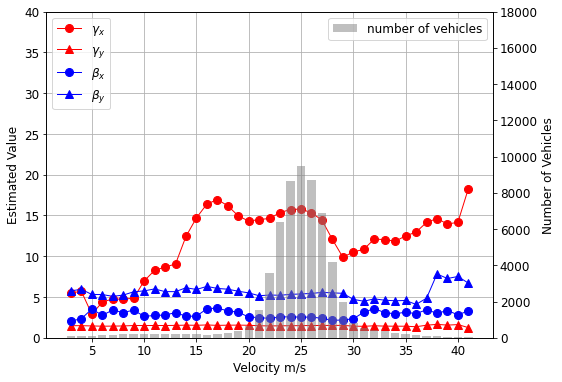

In [84]:
draw_parameters(velGroups, numVehicles, Gx, Gy, Bx, By)

In [26]:
cali_all = calibrate_velocity_groups(np.arange(0,52,2), data=spacings, ignore_lc=True)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\Lucas\AppData\Local\Temp/ipykernel_15844/150218918.py:15: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(jlll_gx, gx, args=(gy,bx,by), n=2)
C:\Users\Lucas\AppData\Local\Temp/ipykernel_15844/150218918.py:18: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(jlll_gy, gy, args=(gx,bx,by), n=2)
  2%|▏         | 2/100 [00:00<00:19,  4.95it/s]

---gx:[2.4375] gy:[1.0481957] bx:3.3722141794483687 by:9.458776963788818---
---gx:[3.54907227] gy:[1.65171133] bx:2.662443769106636 by:3.13193861480173---


  4%|▍         | 4/100 [00:00<00:16,  5.87it/s]

---gx:[3.08129883] gy:[1.34076445] bx:2.927122582521228 by:4.499839556487925---
---gx:[3.27704375] gy:[1.49941172] bx:2.835733825361603 by:3.8546876644204837---


  5%|▌         | 5/100 [00:00<00:17,  5.50it/s]


---gx:[3.21326719] gy:[1.43955312] bx:2.870193216186632 by:4.092701219436551---
---gx:[3.23674883] gy:[1.46401133] bx:2.8574499942297447 by:3.9962094802671286---


  1%|          | 1/100 [00:00<00:19,  5.21it/s]

---gx:[3.04746328] gy:[1.0947707] bx:10.0 by:10.0---


  2%|▏         | 2/100 [00:00<00:32,  3.00it/s]

---gx:[4.28136172] gy:[1.70102773] bx:3.2899851125044735 by:3.9575780506276113---


  3%|▎         | 3/100 [00:00<00:28,  3.37it/s]

---gx:[3.90342031] gy:[1.49576133] bx:3.968496642745467 by:6.016982596681512---


  4%|▍         | 4/100 [00:01<00:27,  3.49it/s]

---gx:[4.12656484] gy:[1.62495586] bx:3.508566505559585 by:4.639242949519921---


  6%|▌         | 6/100 [00:01<00:21,  4.32it/s]

---gx:[3.98730469] gy:[1.55371094] bx:3.7626892801024425 by:5.312421314374636---
---gx:[4.06865937] gy:[1.5948707] bx:3.6070771409280233 by:4.912261282455327---


  8%|▊         | 8/100 [00:01<00:17,  5.34it/s]

---gx:[4.02100781] gy:[1.57147734] bx:3.6946012076910746 by:5.133681126997668---
---gx:[4.0483957] gy:[1.58494922] bx:3.6433144825678303 by:5.004745460758987---


  8%|▊         | 8/100 [00:01<00:22,  4.03it/s]


---gx:[4.0324707] gy:[1.57748086] bx:3.6726978303790285 by:5.075603139024181---


  1%|          | 1/100 [00:00<00:29,  3.38it/s]

---gx:[3.80859375] gy:[1.09686797] bx:6.060876054997622 by:10.0---


  2%|▏         | 2/100 [00:00<00:48,  2.02it/s]

---gx:[6.03839766] gy:[1.73890195] bx:2.700944652544005 by:3.6387983749293227---


  3%|▎         | 3/100 [00:01<00:44,  2.19it/s]

---gx:[4.57618359] gy:[1.4747418] bx:4.009562633475471 by:5.128288556557148---


  4%|▍         | 4/100 [00:01<00:42,  2.27it/s]

---gx:[5.37680898] gy:[1.61088398] bx:3.2240496962793213 by:4.480072114918179---


  5%|▌         | 5/100 [00:02<00:40,  2.35it/s]

---gx:[4.95815195] gy:[1.56293242] bx:3.5655033116550285 by:4.723570376746436---


  6%|▌         | 6/100 [00:02<00:38,  2.42it/s]

---gx:[5.15819141] gy:[1.58286367] bx:3.4022639620942132 by:4.62536972756175---


  6%|▌         | 6/100 [00:02<00:43,  2.17it/s]


---gx:[5.06653867] gy:[1.57460703] bx:3.4751772478049077 by:4.66654204819343---


  1%|          | 1/100 [00:00<00:37,  2.61it/s]

---gx:[4.89804922] gy:[1.09545898] bx:5.665440495763546 by:10.0---


  2%|▏         | 2/100 [00:00<00:46,  2.09it/s]

---gx:[8.34116445] gy:[1.72044727] bx:2.31529463520562 by:4.063974665743135---


  3%|▎         | 3/100 [00:01<00:46,  2.07it/s]

---gx:[5.50238555] gy:[1.51458086] bx:3.814500335151565 by:5.509935670993029---


  4%|▍         | 4/100 [00:01<00:47,  2.03it/s]

---gx:[7.28290313] gy:[1.62004961] bx:2.8386815104605447 by:4.851930172838984---


  5%|▌         | 5/100 [00:02<00:45,  2.08it/s]

---gx:[6.28494453] gy:[1.57913398] bx:3.2554625185813078 by:5.110309123111755---


  6%|▌         | 6/100 [00:02<00:45,  2.08it/s]

---gx:[6.76883125] gy:[1.59686797] bx:3.054123153274331 by:5.001670332700499---


  7%|▋         | 7/100 [00:03<00:43,  2.15it/s]

---gx:[6.54772813] gy:[1.58939961] bx:3.1433374768075253 by:5.046885712208418---


  8%|▊         | 8/100 [00:03<00:42,  2.18it/s]

---gx:[6.6484582] gy:[1.59247344] bx:3.102936274354814 by:5.028673941281771---


  8%|▊         | 8/100 [00:04<00:46,  2.00it/s]


---gx:[6.60363633] gy:[1.59115273] bx:3.1206993064375137 by:5.036584934110786---


  1%|          | 1/100 [00:00<00:39,  2.50it/s]

---gx:[5.76791055] gy:[1.1175875] bx:4.3282894501467775 by:6.340416414005311---


  2%|▏         | 2/100 [00:01<00:53,  1.85it/s]

---gx:[8.31903594] gy:[1.69512422] bx:2.8583144806436502 by:4.55277685656683---


  3%|▎         | 3/100 [00:01<00:54,  1.79it/s]

---gx:[7.14252227] gy:[1.59624727] bx:3.283286619211077 by:5.262569876064538---


  4%|▍         | 4/100 [00:02<00:54,  1.76it/s]

---gx:[7.58490508] gy:[1.64458711] bx:3.1264624285069895 by:4.925934312810719---


  5%|▌         | 5/100 [00:02<00:54,  1.75it/s]

---gx:[7.4360793] gy:[1.6240793] bx:3.1842980916297527 by:5.0718798921619195---


  5%|▌         | 5/100 [00:03<00:58,  1.61it/s]


---gx:[7.49487305] gy:[1.63340078] bx:3.1606776941570285 by:5.006132386943663---


  1%|          | 1/100 [00:00<00:56,  1.74it/s]

---gx:[7.09555898] gy:[1.08862305] bx:4.225138802992341 by:9.446918885346289---


  2%|▏         | 2/100 [00:01<01:20,  1.22it/s]

---gx:[10.10193906] gy:[1.69322695] bx:2.9475194419266697 by:4.201145101452443---


  3%|▎         | 3/100 [00:02<01:12,  1.34it/s]

---gx:[8.92078672] gy:[1.51803398] bx:3.4193443016171443 by:5.6171515090384805---


  4%|▍         | 4/100 [00:02<01:06,  1.43it/s]

---gx:[9.45311328] gy:[1.6090543] bx:3.1912813228555237 by:4.927685523537574---


  5%|▌         | 5/100 [00:03<01:03,  1.50it/s]

---gx:[9.21628516] gy:[1.57242148] bx:3.288716932275938 by:5.217901409294035---


  6%|▌         | 6/100 [00:04<01:00,  1.55it/s]

---gx:[9.32145391] gy:[1.58951133] bx:3.2445580493016424 by:5.084711182896063---


  6%|▌         | 6/100 [00:04<01:08,  1.36it/s]


---gx:[9.27584375] gy:[1.58199883] bx:3.2636484511848156 by:5.1437682637385755---


  1%|          | 1/100 [00:00<00:49,  1.98it/s]

---gx:[7.39282227] gy:[1.11312539] bx:5.155160602182689 by:5.952365477583499---


  2%|▏         | 2/100 [00:01<01:12,  1.35it/s]

---gx:[9.86941719] gy:[1.67514883] bx:3.1574725714969927 by:5.214711733290814---


  3%|▎         | 3/100 [00:01<01:04,  1.51it/s]

---gx:[8.89890234] gy:[1.63276836] bx:3.5261135982276066 by:5.653440965720396---


  4%|▍         | 4/100 [00:02<01:00,  1.59it/s]

---gx:[9.15109961] gy:[1.65670586] bx:3.4120202874366456 by:5.41319458828178---


  5%|▌         | 5/100 [00:02<00:49,  1.90it/s]

---gx:[9.08528164] gy:[1.64445469] bx:3.450364481496419 by:5.535792440892628---


  5%|▌         | 5/100 [00:03<01:01,  1.55it/s]


---gx:[9.1069543] gy:[1.65090234] bx:3.4339925637902082 by:5.471976234083237---


  1%|          | 1/100 [00:00<01:02,  1.58it/s]

---gx:[9.41792461] gy:[1.11338125] bx:3.92563114346586 by:8.128552559163467---


  2%|▏         | 2/100 [00:01<01:09,  1.40it/s]

---gx:[13.20638711] gy:[1.71049336] bx:2.7859362570700297 by:5.3082524448307185---


  3%|▎         | 3/100 [00:01<00:58,  1.65it/s]

---gx:[11.64388711] gy:[1.62415586] bx:3.0887682345140273 by:6.445167691549181---


  4%|▍         | 4/100 [00:02<00:54,  1.77it/s]

---gx:[12.20002773] gy:[1.6699543] bx:2.9722693346948024 by:5.839168107182345---


  5%|▌         | 5/100 [00:02<00:51,  1.86it/s]

---gx:[12.0080332] gy:[1.64876992] bx:3.017428646724503 by:6.118833913240694---


  6%|▌         | 6/100 [00:03<00:42,  2.21it/s]

---gx:[12.09382656] gy:[1.65921211] bx:2.9963669330072102 by:5.9810181350468445---


  6%|▌         | 6/100 [00:03<00:53,  1.76it/s]


---gx:[12.04382188] gy:[1.65398516] bx:3.0076977972094086 by:6.049956672844968---


  1%|          | 1/100 [00:00<00:36,  2.73it/s]

---gx:[9.41748047] gy:[1.11522266] bx:3.7059635451638315 by:7.181449427570568---


  2%|▏         | 2/100 [00:01<00:51,  1.90it/s]

---gx:[13.30577578] gy:[1.70717539] bx:2.9532109458653424 by:5.0077551359493615---


  3%|▎         | 3/100 [00:01<00:47,  2.04it/s]

---gx:[12.05024883] gy:[1.61997305] bx:3.1880807867955334 by:5.952494333467113---


  4%|▍         | 4/100 [00:01<00:44,  2.15it/s]

---gx:[12.49511719] gy:[1.66669219] bx:3.1069628240411773 by:5.4327648433449065---


  5%|▌         | 5/100 [00:02<00:42,  2.23it/s]

---gx:[12.35009766] gy:[1.64418711] bx:3.1394136253954024 by:5.679846191494138---


  6%|▌         | 6/100 [00:02<00:35,  2.67it/s]

---gx:[12.41245352] gy:[1.65561758] bx:3.1245023596494104 by:5.5536016721177965---


  6%|▌         | 6/100 [00:02<00:43,  2.18it/s]


---gx:[12.38032695] gy:[1.6499582] bx:3.132148721257805 by:5.61595082737574---


  1%|          | 1/100 [00:00<00:53,  1.86it/s]

---gx:[9.17733438] gy:[1.12070547] bx:4.3766101953391034 by:7.196070997190395---


  2%|▏         | 2/100 [00:01<01:16,  1.27it/s]

---gx:[12.86072813] gy:[1.72294453] bx:3.04819279477594 by:5.186693638865404---


  3%|▎         | 3/100 [00:02<01:09,  1.40it/s]

---gx:[11.56565039] gy:[1.6420457] bx:3.4278154163757426 by:5.9109689308448745---


  4%|▍         | 4/100 [00:02<01:04,  1.49it/s]

---gx:[12.05743789] gy:[1.6782668] bx:3.2803709222675175 by:5.601741499486265---


  5%|▌         | 5/100 [00:03<01:01,  1.55it/s]

---gx:[11.88483047] gy:[1.66435078] bx:3.3346886072238537 by:5.723245131910653---


  5%|▌         | 5/100 [00:03<01:09,  1.36it/s]

---gx:[11.95446641] gy:[1.67031016] bx:3.312317820854472 by:5.671646809175393---



  1%|          | 1/100 [00:01<01:56,  1.18s/it]

---gx:[9.44335938] gy:[1.06854766] bx:3.9185629927828516 by:5.714196085700306---


  2%|▏         | 2/100 [00:02<02:21,  1.44s/it]

---gx:[14.49500547] gy:[1.59412656] bx:2.369378821179791 by:4.771817724990124---


  3%|▎         | 3/100 [00:04<02:19,  1.43s/it]

---gx:[10.69818633] gy:[1.54011562] bx:2.879659934835902 by:5.047337918608189---


  4%|▍         | 4/100 [00:05<02:16,  1.42s/it]

---gx:[12.24115508] gy:[1.55808203] bx:2.6997618185871244 by:4.962275565725093---


  5%|▌         | 5/100 [00:07<02:13,  1.40s/it]

---gx:[11.73513984] gy:[1.5528668] bx:2.7578810968491747 by:4.986944501520339---


  6%|▌         | 6/100 [00:08<02:09,  1.38s/it]

---gx:[11.90316445] gy:[1.55443164] bx:2.7391024871941325 by:4.979748375303487---


  6%|▌         | 6/100 [00:09<02:21,  1.51s/it]

---gx:[11.84916523] gy:[1.55389922] bx:2.7450490848044433 by:4.982228957934133---



  1%|          | 1/100 [00:05<09:25,  5.72s/it]

---gx:[10.35394805] gy:[1.04258047] bx:3.615784244070477 by:5.780083371237434---


  2%|▏         | 2/100 [00:14<12:43,  7.79s/it]

---gx:[14.2012043] gy:[1.55595234] bx:2.539651301346373 by:4.823157407166952---


  3%|▎         | 3/100 [00:21<11:28,  7.10s/it]

---gx:[12.05295508] gy:[1.50477109] bx:2.7759995020394035 by:5.19972312592458---


  4%|▍         | 4/100 [00:27<10:47,  6.75s/it]

---gx:[12.6639832] gy:[1.52693203] bx:2.7032262971012098 by:5.043981223896666---


  5%|▌         | 5/100 [00:33<10:09,  6.42s/it]

---gx:[12.48844609] gy:[1.51833125] bx:2.7261121095380654 by:5.105047518286691---


  5%|▌         | 5/100 [00:36<11:36,  7.33s/it]

---gx:[12.54494258] gy:[1.52209336] bx:2.7175981029366936 by:5.078575498677354---



  1%|          | 1/100 [00:07<12:08,  7.36s/it]

---gx:[9.27031953] gy:[1.05504336] bx:3.392737338162751 by:6.196193012841456---


  2%|▏         | 2/100 [00:19<16:15,  9.95s/it]

---gx:[12.00742422] gy:[1.58985547] bx:2.6197449584173103 by:4.8668774724549655---


  3%|▎         | 3/100 [00:27<14:48,  9.16s/it]

---gx:[10.74281992] gy:[1.52637891] bx:2.7813009740308123 by:5.402916301435902---


  4%|▍         | 4/100 [00:35<13:46,  8.61s/it]

---gx:[11.04989297] gy:[1.55616406] bx:2.7308896741176105 by:5.16560643285569---


  5%|▌         | 5/100 [00:39<11:15,  7.11s/it]

---gx:[10.95496641] gy:[1.54366875] bx:2.750121687317633 by:5.266898905617413---


  5%|▌         | 5/100 [00:43<13:52,  8.76s/it]

---gx:[10.99754688] gy:[1.54922812] bx:2.7414523001108457 by:5.222171892913359---



  1%|          | 1/100 [00:04<06:44,  4.09s/it]

---gx:[10.13588633] gy:[1.08457266] bx:3.5240284792588277 by:5.893713592258447---


  2%|▏         | 2/100 [00:10<09:16,  5.68s/it]

---gx:[13.6640625] gy:[1.62524414] bx:2.623969907793438 by:4.979908430022654---


  3%|▎         | 3/100 [00:15<08:28,  5.25s/it]

---gx:[11.98510742] gy:[1.5773043] bx:2.809535858035287 by:5.328258504886265---


  4%|▍         | 4/100 [00:20<07:53,  4.94s/it]

---gx:[12.40976797] gy:[1.59737969] bx:2.760657693617895 by:5.189956503523956---


  5%|▌         | 5/100 [00:24<07:20,  4.63s/it]

---gx:[12.3047875] gy:[1.58966719] bx:2.775925362873894 by:5.243055678053972---


  5%|▌         | 5/100 [00:26<08:24,  5.31s/it]

---gx:[12.33837891] gy:[1.59274102] bx:2.7703172786043346 by:5.222150020707426---



  1%|          | 1/100 [00:04<07:38,  4.63s/it]

---gx:[10.84897695] gy:[1.07459531] bx:3.704659178109718 by:5.269173225155339---


  2%|▏         | 2/100 [00:12<10:46,  6.60s/it]

---gx:[14.89757266] gy:[1.5867582] bx:2.689223085680553 by:4.878529210137467---


  3%|▎         | 3/100 [00:17<09:33,  5.91s/it]

---gx:[12.92921094] gy:[1.56171172] bx:2.901685479458402 by:5.036126811706139---


  4%|▍         | 4/100 [00:22<08:49,  5.52s/it]

---gx:[13.43663516] gy:[1.57187734] bx:2.8533757064532925 by:4.974476972000812---


  5%|▌         | 5/100 [00:27<08:19,  5.25s/it]

---gx:[13.32896914] gy:[1.56782695] bx:2.866153824095893 by:4.997753349053867---


  5%|▌         | 5/100 [00:30<09:33,  6.03s/it]

---gx:[13.35841016] gy:[1.56933594] bx:2.862121332917043 by:4.989278695991675---



  1%|          | 1/100 [00:06<10:00,  6.07s/it]

---gx:[11.31123516] gy:[1.08309609] bx:3.7702239229443597 by:5.682416206335116---


  2%|▏         | 2/100 [00:16<13:45,  8.42s/it]

---gx:[15.67118672] gy:[1.61562266] bx:2.740865493394138 by:4.969787660330276---


  3%|▎         | 3/100 [00:22<12:05,  7.48s/it]

---gx:[13.73173359] gy:[1.57513945] bx:2.974019546003211 by:5.2461754960518405---


  4%|▍         | 4/100 [00:28<11:16,  7.04s/it]

---gx:[14.28696523] gy:[1.59158516] bx:2.911057128577744 by:5.137067567344167---


  5%|▌         | 5/100 [00:34<10:37,  6.71s/it]

---gx:[14.14707266] gy:[1.5855375] bx:2.929579879156743 by:5.176909000252128---


  5%|▌         | 5/100 [00:38<12:11,  7.70s/it]

---gx:[14.18974141] gy:[1.58777891] bx:2.9235683815724043 by:5.162301992731046---



  1%|          | 1/100 [00:06<10:16,  6.23s/it]

---gx:[12.41866875] gy:[1.09135273] bx:3.72588468408558 by:6.383898517184756---


  2%|▏         | 2/100 [00:16<14:11,  8.69s/it]

---gx:[17.03263828] gy:[1.6547293] bx:2.6835423832528478 by:4.931131384516154---


  3%|▎         | 3/100 [00:23<12:21,  7.64s/it]

---gx:[14.80959375] gy:[1.58539336] bx:2.937713120905686 by:5.470164561082251---


  4%|▍         | 4/100 [00:29<11:31,  7.20s/it]

---gx:[15.4842543] gy:[1.6155668] bx:2.8561168744261023 by:5.248749273371211---


  5%|▌         | 5/100 [00:35<10:57,  6.92s/it]

---gx:[15.28319414] gy:[1.60424805] bx:2.88289546298175 by:5.331834207630266---


  5%|▌         | 5/100 [00:39<12:32,  7.92s/it]

---gx:[15.35233008] gy:[1.60878672] bx:2.873005802159985 by:5.2990076144263325---



  1%|          | 1/100 [00:04<06:55,  4.19s/it]

---gx:[12.90474102] gy:[1.09106445] bx:4.050205674058025 by:5.429130022222354---


  2%|▏         | 2/100 [00:11<09:37,  5.90s/it]

---gx:[18.01010977] gy:[1.61879648] bx:2.7558390443009704 by:5.090869518814457---


  3%|▎         | 3/100 [00:15<08:23,  5.19s/it]

---gx:[15.55385508] gy:[1.59637969] bx:3.0236510430699406 by:5.241282602324946---


  4%|▍         | 4/100 [00:19<07:43,  4.83s/it]

---gx:[16.24648203] gy:[1.60556875] bx:2.9534961370361628 by:5.181385642414359---


  5%|▌         | 5/100 [00:24<07:13,  4.57s/it]

---gx:[16.07821328] gy:[1.60189492] bx:2.972919532742177 by:5.204107305108931---


  5%|▌         | 5/100 [00:26<08:22,  5.29s/it]

---gx:[16.12665313] gy:[1.60355977] bx:2.9667073591191544 by:5.194213659767242---



  1%|          | 1/100 [00:02<03:33,  2.16s/it]

---gx:[13.28245898] gy:[1.09355] bx:4.130465010300402 by:5.646199484064128---


  2%|▏         | 2/100 [00:05<04:54,  3.00s/it]

---gx:[17.12942695] gy:[1.64726094] bx:2.7846127643687 by:4.755712360759018---


  3%|▎         | 3/100 [00:08<04:21,  2.70s/it]

---gx:[15.59475898] gy:[1.58744648] bx:2.992260191553198 by:5.074008926484659---


  4%|▍         | 4/100 [00:10<04:01,  2.51s/it]

---gx:[16.00638008] gy:[1.60933086] bx:2.927796962313126 by:4.968260408640242---


  5%|▌         | 5/100 [00:12<03:47,  2.39s/it]

---gx:[15.8887043] gy:[1.60239492] bx:2.9470197842818746 by:5.002785268353534---


  5%|▌         | 5/100 [00:13<04:20,  2.74s/it]


---gx:[15.92723438] gy:[1.60479219] bx:2.940581233940299 by:4.99102928067473---


  1%|          | 1/100 [00:00<01:28,  1.12it/s]

---gx:[14.25527109] gy:[1.08247539] bx:2.922065654285727 by:6.120541012291407---


  2%|▏         | 2/100 [00:01<01:27,  1.12it/s]

---gx:[18.60058594] gy:[1.6342332] bx:2.3107425729662774 by:5.014062313182224---


  3%|▎         | 3/100 [00:02<01:22,  1.18it/s]

---gx:[15.84355] gy:[1.58154297] bx:2.4339162742871885 by:5.368152218858797---


  4%|▍         | 4/100 [00:03<01:18,  1.23it/s]

---gx:[16.47538594] gy:[1.60107422] bx:2.4049495905567 by:5.250576411397154---


  5%|▌         | 5/100 [00:04<01:14,  1.27it/s]

---gx:[16.33241953] gy:[1.59512656] bx:2.4131973241702007 by:5.285722756619773---


  5%|▌         | 5/100 [00:04<01:25,  1.11it/s]


---gx:[16.37411172] gy:[1.59687969] bx:2.4108328690599166 by:5.275413885604209---


  1%|          | 1/100 [00:00<00:40,  2.46it/s]

---gx:[15.69275938] gy:[1.01660156] bx:3.246678199047947 by:5.962208620745975---


  2%|▏         | 2/100 [00:01<01:13,  1.34it/s]

---gx:[16.59949766] gy:[1.54803984] bx:2.4758820184219257 by:4.584806149965916---


  3%|▎         | 3/100 [00:01<01:04,  1.51it/s]

---gx:[15.30935859] gy:[1.47274453] bx:2.599928100746436 by:5.079501299060116---


  4%|▍         | 4/100 [00:02<00:59,  1.61it/s]

---gx:[15.39969063] gy:[1.50593594] bx:2.5561579401567 by:4.878735576773427---


  4%|▍         | 4/100 [00:02<01:05,  1.47it/s]


---gx:[15.30354336] gy:[1.49358477] bx:2.573767523912925 by:4.955345745434562---


  1%|          | 1/100 [00:00<00:25,  3.86it/s]

---gx:[16.3818918] gy:[1.04117148] bx:4.66325861822386 by:5.311493890613895---


  2%|▏         | 2/100 [00:00<00:32,  3.02it/s]

---gx:[22.01476016] gy:[1.54691914] bx:2.7081712727351164 by:5.484796490881626---


  3%|▎         | 3/100 [00:00<00:28,  3.46it/s]

---gx:[18.16662734] gy:[1.54740742] bx:2.9059956783944476 by:5.651001892017132---


  4%|▍         | 4/100 [00:01<00:29,  3.25it/s]


---gx:[18.65364375] gy:[1.5558082] bx:2.8894290573485235 by:5.557398098598868---
---gx:[18.61609023] gy:[1.55161367] bx:2.897319547095955 by:5.591028638753212---


  1%|          | 1/100 [00:00<00:24,  4.12it/s]

---gx:[18.59878867] gy:[1.03315898] bx:3.6887106199523654 by:8.696296666216533---


  3%|▎         | 3/100 [00:00<00:20,  4.76it/s]

---gx:[17.27194023] gy:[1.60443633] bx:2.636944664028538 by:4.816583672612174---
---gx:[22.59621484] gy:[1.47660664] bx:2.5941136163159073 by:5.878787914343804---


  5%|▌         | 5/100 [00:00<00:16,  5.62it/s]

---gx:[22.21975] gy:[1.52484648] bx:2.5576075265905676 by:5.459150676212077---
---gx:[22.05057227] gy:[1.5083332] bx:2.5849020356378007 by:5.606097606114676---


  6%|▌         | 6/100 [00:01<00:19,  4.95it/s]


---gx:[22.19511523] gy:[1.51453672] bx:2.5708956789821595 by:5.549529974935593---
---gx:[22.11865508] gy:[1.51219531] bx:2.577160841936305 by:5.57123077744991---


  2%|▏         | 2/100 [00:00<00:16,  5.99it/s]

---gx:[16.91629219] gy:[1.01000977] bx:5.902414073006379 by:10.0---
---gx:[24.96605273] gy:[1.61587852] bx:4.153150176892898 by:4.470188577789321---


  4%|▍         | 4/100 [00:00<00:16,  5.97it/s]

---gx:[23.52532305] gy:[1.44404766] bx:6.195035432429956 by:5.33231384180577---
---gx:[25.10490117] gy:[1.50381797] bx:4.723306793122251 by:5.177929325808183---


  6%|▌         | 6/100 [00:00<00:13,  6.75it/s]

---gx:[24.11604336] gy:[1.49253164] bx:5.385733277452192 by:5.216958942271561---
---gx:[24.60125078] gy:[1.49653789] bx:5.077125353189289 by:5.200333687087633---


  7%|▋         | 7/100 [00:01<00:15,  5.98it/s]


---gx:[24.38986914] gy:[1.49467305] bx:5.216283145451003 by:5.207006766340248---
---gx:[24.48781367] gy:[1.49594961] bx:5.148462843245611 by:5.202570279262291---


  2%|▏         | 2/100 [00:00<00:18,  5.18it/s]

---gx:[27.38135937] gy:[0.94442422] bx:3.4828965684345268 by:10.0---
---gx:[38.50449453] gy:[1.45261328] bx:3.156891934840748 by:4.2572806040419096---


  4%|▍         | 4/100 [00:00<00:14,  6.80it/s]

---gx:[36.94800977] gy:[1.33478164] bx:3.349527255936054 by:4.887817477690493---
---gx:[37.97387695] gy:[1.37701797] bx:3.3052614276086287 by:4.639176466262273---


  6%|▌         | 6/100 [00:00<00:14,  6.41it/s]

---gx:[37.75550352] gy:[1.36265781] bx:3.3267756835854216 by:4.716904025699306---
---gx:[37.8654668] gy:[1.36749648] bx:3.3202517245792262 by:4.689851819017248---
---gx:[37.83148711] gy:[1.36584336] bx:3.3224004621290426 by:4.69911738097382---



  1%|          | 1/100 [00:00<00:15,  6.34it/s]

---gx:[1.81406484] gy:[1.0768043] bx:4.56029201331806 by:10.0---


  2%|▏         | 2/100 [00:00<00:23,  4.14it/s]

---gx:[15.02764375] gy:[1.6237793] bx:2.0 by:5.443098780751836---


  4%|▍         | 4/100 [00:01<00:27,  3.51it/s]

---gx:[1.85874258] gy:[1.59867695] bx:8.853007972483503 by:7.4172609008874---
---gx:[2.10229492] gy:[1.68016406] bx:10.0 by:6.516477109696292---
---gx:[2.12583242] gy:[1.65292031] bx:10.0 by:6.855544297196292---


  6%|▌         | 6/100 [00:01<00:21,  4.47it/s]

---gx:[2.11391367] gy:[1.66405078] bx:10.0 by:6.726349765946291---
---gx:[2.11899648] gy:[1.65984453] bx:10.0 by:6.776254453446291---


In [27]:
cali_lc = calibrate_velocity_groups(np.arange(0,52,2), data=spacings, egolc=1)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\Lucas\AppData\Local\Temp/ipykernel_15844/150218918.py:15: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(jlll_gx, gx, args=(gy,bx,by), n=2)
C:\Users\Lucas\AppData\Local\Temp/ipykernel_15844/150218918.py:18: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(jlll_gy, gy, args=(gx,bx,by), n=2)
  1%|          | 1/100 [00:13<22:44, 13.78s/it]

---gx:[9540.5674332] gy:[0.76062148] bx:2.0 by:10.0---


  2%|▏         | 2/100 [00:14<09:43,  5.96s/it]

---gx:[9611.86688203] gy:[1.15670586] bx:2.0 by:8.3389671875---


  3%|▎         | 3/100 [00:14<05:43,  3.54s/it]

---gx:[9757.18333242] gy:[1.14537539] bx:2.0 by:9.11289296875---


  6%|▌         | 6/100 [00:15<01:49,  1.16s/it]

---gx:[9858.13443672] gy:[1.15156719] bx:2.0 by:8.72295625---
---gx:[9858.13531328] gy:[1.1487375] bx:2.0 by:8.910600390625---
---gx:[9860.94751328] gy:[1.15030234] bx:2.0 by:8.808737890625---


  7%|▋         | 7/100 [00:16<01:31,  1.01it/s]

---gx:[9911.26050156] gy:[1.14926992] bx:2.0 by:8.876708984375---


 10%|█         | 10/100 [00:16<00:44,  2.02it/s]

---gx:[9956.10209844] gy:[1.15000234] bx:2.0 by:8.828657421875---
---gx:[9958.9687418] gy:[1.14941406] bx:2.0 by:8.867431640625---
---gx:[9986.84325352] gy:[1.14994648] bx:2.0 by:8.83241953125---


 11%|█         | 11/100 [00:17<02:18,  1.56s/it]


---gx:[10012.23407852] gy:[1.1496582] bx:2.0 by:8.8512625---
---gx:[10012.23417852] gy:[1.1497582] bx:2.0 by:8.844714843750001---


  2%|▏         | 2/100 [00:00<00:13,  7.25it/s]

---gx:[3.93055234] gy:[0.87564414] bx:10.0 by:10.0---
---gx:[6.63611875] gy:[1.33408437] bx:4.4867417321276 by:6.630537808584386---


  4%|▍         | 4/100 [00:00<00:11,  8.22it/s]

---gx:[5.80759375] gy:[1.29062734] bx:7.608419144876538 by:8.575445535480547---
---gx:[6.43318203] gy:[1.32212148] bx:6.06490894830012 by:7.108703613765307---


  6%|▌         | 6/100 [00:00<00:10,  8.65it/s]

---gx:[6.20436641] gy:[1.30092539] bx:7.2382239764945835 by:8.021048513249788---
---gx:[6.38722773] gy:[1.31557383] bx:6.377150480415057 by:7.38532718909947---


  9%|▉         | 9/100 [00:00<00:08, 11.16it/s]

---gx:[6.26018633] gy:[1.30579648] bx:7.030168631360775 by:7.806934117876359---
---gx:[6.35813086] gy:[1.3130207] bx:6.551847538765586 by:7.493493286852899---
---gx:[6.28947148] gy:[1.30720547] bx:6.906030716966165 by:7.743570242430506---
---gx:[6.3414293] gy:[1.31178828] bx:6.644507225938816 by:7.546345194878824---


 13%|█▎        | 13/100 [00:01<00:08, 10.11it/s]

---gx:[6.30363164] gy:[1.30847031] bx:6.839176796264846 by:7.688932550590227---
---gx:[6.33215195] gy:[1.31101172] bx:6.694449870991454 by:7.5796497100701625---
---gx:[6.31105586] gy:[1.30885859] bx:6.80361312053053 by:7.67188786334432---
---gx:[6.32686914] gy:[1.31066758] bx:6.721902893015867 by:7.594607333086789---



  2%|▏         | 2/100 [00:01<01:00,  1.61it/s]

---gx:[3.38535391] gy:[0.86130781] bx:2.7787904587806205 by:4.490774807611513---
---gx:[4.25885664] gy:[1.24651758] bx:2.611691818613139 by:5.405665965668007---


  5%|▌         | 5/100 [00:01<00:19,  4.77it/s]

---gx:[4.16471836] gy:[1.27746758] bx:2.5854641770289906 by:4.8960785431581355---
---gx:[4.14099258] gy:[1.26017773] bx:2.5985827442610114 by:5.189100565001175---
---gx:[4.13645391] gy:[1.27053164] bx:2.5895741125163285 by:5.015600043286232---


  6%|▌         | 6/100 [00:01<00:28,  3.27it/s]


---gx:[4.13820703] gy:[1.26447227] bx:2.5946280577414087 by:5.116745515651154---
---gx:[4.13693047] gy:[1.26809023] bx:2.591544477264706 by:5.056007506373752---


  2%|▏         | 2/100 [00:00<00:17,  5.45it/s]

---gx:[4.87241445] gy:[1.09341758] bx:3.864289687804538 by:7.033922848916769---
---gx:[7.68407031] gy:[1.71128164] bx:2.400359520236456 by:4.117676799005252---


  4%|▍         | 4/100 [00:00<00:14,  6.75it/s]

---gx:[5.70619883] gy:[1.54071563] bx:3.0530810437296574 by:4.650351322043351---
---gx:[6.77406992] gy:[1.59231758] bx:2.7957081263257813 by:4.609779139493085---


  6%|▌         | 6/100 [00:00<00:14,  6.37it/s]

---gx:[6.39150156] gy:[1.58762305] bx:2.880416763202114 by:4.596070508504049---
---gx:[6.52299336] gy:[1.58703477] bx:2.8539059885269675 by:4.606922258158641---
---gx:[6.48266602] gy:[1.58786719] bx:2.8619757125074337 by:4.601850050712224---



  2%|▏         | 2/100 [00:01<00:56,  1.73it/s]

---gx:[5.36997305] gy:[1.0792207] bx:2.873362581257761 by:4.82831297811185---
---gx:[7.48413086] gy:[1.57317305] bx:2.109304820367929 by:4.649639503448582---


  4%|▍         | 4/100 [00:01<00:39,  2.43it/s]

---gx:[5.85111836] gy:[1.56047773] bx:2.2557415002571277 by:4.617946879860898---
---gx:[6.22143555] gy:[1.55704805] bx:2.262066991643879 by:4.634823157772481---
---gx:[6.23726055] gy:[1.55831289] bx:2.261247456853937 by:4.6312109816984455---



  2%|▏         | 2/100 [00:00<00:18,  5.27it/s]

---gx:[8.37660898] gy:[1.05991445] bx:2.0026547123083835 by:10.0---
---gx:[9.14852578] gy:[1.62670898] bx:2.0 by:4.228842919457757---


  5%|▌         | 5/100 [00:00<00:11,  8.10it/s]

---gx:[8.6949125] gy:[1.45927266] bx:2.0 by:5.506630810082757---
---gx:[8.75013242] gy:[1.53310312] bx:2.0 by:5.000571435082757---
---gx:[8.82225391] gy:[1.50898906] bx:2.0 by:5.175231981957757---


  5%|▌         | 5/100 [00:00<00:14,  6.42it/s]


---gx:[8.80292266] gy:[1.51733398] bx:2.0 by:5.1157058100827575---


  2%|▏         | 2/100 [00:00<00:15,  6.16it/s]

---gx:[4.92103086] gy:[1.11421367] bx:5.241161705088105 by:7.878254368885584---
---gx:[7.51053047] gy:[1.70346914] bx:2.6974525126441513 by:4.385987805222328---


  4%|▍         | 4/100 [00:00<00:13,  6.99it/s]

---gx:[5.83983203] gy:[1.56933594] bx:3.375841813849249 by:6.353217741594113---
---gx:[6.49358477] gy:[1.66756875] bx:3.14703420553994 by:4.962970505779542---


  7%|▋         | 7/100 [00:00<00:09,  9.43it/s]

---gx:[6.29202461] gy:[1.6073543] bx:3.242593065886689 by:5.860814298550233---
---gx:[6.3729793] gy:[1.65144375] bx:3.1890190665125573 by:5.217521835961762---
---gx:[6.33167539] gy:[1.62147031] bx:3.219177505336735 by:5.664488693185253---


 11%|█         | 11/100 [00:01<00:07, 11.74it/s]

---gx:[6.35580117] gy:[1.64299883] bx:3.1980593503828607 by:5.3462784268143855---
---gx:[6.33939961] gy:[1.62805039] bx:3.2120582879623765 by:5.569506942688056---
---gx:[6.3504418] gy:[1.63899258] bx:3.2018300661468007 by:5.4067766412507625---
---gx:[6.34248516] gy:[1.63108008] bx:3.2091516947483205 by:5.525030444215962---


 11%|█         | 11/100 [00:01<00:10,  8.85it/s]


---gx:[6.34830039] gy:[1.63673945] bx:3.2039243274744504 by:5.440596822356882---


  2%|▏         | 2/100 [00:00<00:18,  5.25it/s]

---gx:[5.77958516] gy:[1.09691211] bx:5.233862705499392 by:7.596317877208185---
---gx:[8.83188711] gy:[1.6161668] bx:2.845279559245852 by:5.279894062491121---


  4%|▍         | 4/100 [00:00<00:14,  6.68it/s]

---gx:[7.23203359] gy:[1.56446484] bx:3.394619802343659 by:6.451440820601468---
---gx:[7.81837109] gy:[1.60127422] bx:3.292441539922782 by:5.6631969708174115---
---gx:[7.72628594] gy:[1.57364219] bx:3.3411217110472995 by:6.121826728041452---


  6%|▌         | 6/100 [00:00<00:10,  8.99it/s]

---gx:[7.76476016] gy:[1.59175273] bx:3.313252561608412 by:5.830789493201059---
---gx:[7.74331992] gy:[1.58086641] bx:3.3293475489254085 by:6.007109123137285---


  8%|▊         | 8/100 [00:01<00:11,  7.94it/s]


---gx:[7.75587109] gy:[1.58750234] bx:3.3194243360349622 by:5.9001677965569055---
---gx:[7.74825859] gy:[1.58369609] bx:3.3251972403526278 by:5.961671570388674---


  2%|▏         | 2/100 [00:00<00:14,  6.53it/s]

---gx:[5.92017773] gy:[1.13546562] bx:2.1567253267688695 by:4.21573508207644---
---gx:[6.20997266] gy:[1.60943086] bx:2.0 by:6.34810856079552---


  5%|▌         | 5/100 [00:00<00:12,  7.89it/s]

---gx:[5.87461172] gy:[1.74141094] bx:2.0 by:5.581306998295521---
---gx:[5.87441172] gy:[1.70713125] bx:2.0 by:5.950491763920521---
---gx:[5.86786406] gy:[1.72475352] bx:2.0 by:5.779060904545521---
---gx:[5.87167031] gy:[1.71714102] bx:2.0 by:5.85738590454552---



  2%|▏         | 2/100 [00:00<00:18,  5.19it/s]

---gx:[6.17486055] gy:[1.06717109] bx:5.833637137724405 by:5.2970160431661535---
---gx:[9.47482109] gy:[1.54518672] bx:3.1875652330401105 by:4.338808282195814---


  4%|▍         | 4/100 [00:00<00:14,  6.56it/s]

---gx:[7.6894207] gy:[1.50045312] bx:4.310956625282129 by:4.9012323885282---
---gx:[8.6183875] gy:[1.53217969] bx:3.814018872273421 by:4.532265499600549---


  6%|▌         | 6/100 [00:00<00:13,  7.21it/s]

---gx:[8.27081953] gy:[1.51059531] bx:4.05101098818657 by:4.719325093075278---
---gx:[8.44424766] gy:[1.52216992] bx:3.9353240429738636 by:4.6206953973678955---
---gx:[8.35737773] gy:[1.51503398] bx:3.998028267836265 by:4.677099727339117---


  2%|▏         | 2/100 [00:00<00:16,  5.79it/s]

---gx:[7.8603957] gy:[0.91155352] bx:3.2750709902358297 by:4.023380502569579---
---gx:[6.03763008] gy:[1.35297148] bx:2.9072989358453425 by:4.083178184022723---


  3%|▎         | 3/100 [00:00<00:18,  5.20it/s]


---gx:[5.76980781] gy:[1.36176055] bx:2.8733778994026027 by:4.100962452650271---
---gx:[5.74315234] gy:[1.36352539] bx:2.862810061158525 by:4.101794207983796---


  1%|          | 1/100 [00:00<00:19,  5.00it/s]

---gx:[6.23950195] gy:[0.95339258] bx:3.2452631346177196 by:4.735173602444888---


  2%|▏         | 2/100 [00:00<00:23,  4.21it/s]

---gx:[8.39190156] gy:[1.41843633] bx:2.632455542698838 by:4.293393381702742---


  3%|▎         | 3/100 [00:00<00:23,  4.21it/s]

---gx:[7.51506016] gy:[1.38728633] bx:2.759057399876367 by:4.541078870488271---


  4%|▍         | 4/100 [00:01<00:26,  3.67it/s]

---gx:[7.72253555] gy:[1.40599687] bx:2.7293421213998297 by:4.425231264095679---
---gx:[7.67765781] gy:[1.39740781] bx:2.737832293096192 by:4.472995028871358---



  1%|          | 1/100 [00:00<00:51,  1.93it/s]

---gx:[5.2564918] gy:[1.03680938] bx:3.9373874859967652 by:5.066823016622337---


  2%|▏         | 2/100 [00:01<01:10,  1.39it/s]

---gx:[6.93514688] gy:[1.51229531] bx:2.6521427396658632 by:4.48888564737511---


  3%|▎         | 3/100 [00:01<01:02,  1.55it/s]

---gx:[5.77978516] gy:[1.48045703] bx:2.928950850413691 by:4.75091106546952---


  4%|▍         | 4/100 [00:02<00:57,  1.66it/s]

---gx:[6.05616406] gy:[1.49735859] bx:2.8588511548682347 by:4.640066503733596---


  4%|▍         | 4/100 [00:02<01:06,  1.44it/s]


---gx:[5.98369844] gy:[1.48934609] bx:2.8805654205799893 by:4.689770603759822---


  1%|          | 1/100 [00:00<01:02,  1.57it/s]

---gx:[6.60195078] gy:[1.03808594] bx:2.8557782732714783 by:6.74794640183336---


  2%|▏         | 2/100 [00:01<01:01,  1.60it/s]

---gx:[7.91222109] gy:[1.59969766] bx:2.354529165288426 by:3.6621934571257597---


  3%|▎         | 3/100 [00:01<00:58,  1.67it/s]

---gx:[7.16740391] gy:[1.40609414] bx:2.5196897472345907 by:4.6404712638331045---


  4%|▍         | 4/100 [00:02<00:50,  1.91it/s]

---gx:[7.41349766] gy:[1.49935586] bx:2.43505844486359 by:4.261068546246413---


  5%|▌         | 5/100 [00:02<00:44,  2.13it/s]

---gx:[7.27136367] gy:[1.4694707] bx:2.4641586467722383 by:4.40080329915843---


  5%|▌         | 5/100 [00:02<00:53,  1.77it/s]


---gx:[7.32722773] gy:[1.48187773] bx:2.4521169750859313 by:4.344773914276202---


  1%|          | 1/100 [00:00<00:48,  2.02it/s]

---gx:[8.52246094] gy:[0.95127187] bx:3.1153596831221053 by:3.544740286251368---


  2%|▏         | 2/100 [00:01<01:03,  1.55it/s]

---gx:[11.25985391] gy:[1.34102031] bx:2.4949066733031504 by:3.9167771310029074---


  3%|▎         | 3/100 [00:01<00:56,  1.71it/s]

---gx:[9.73446328] gy:[1.390625] bx:2.5674138724972106 by:3.927336414962923---


  4%|▍         | 4/100 [00:02<00:52,  1.84it/s]

---gx:[9.93259375] gy:[1.39101328] bx:2.5568159083894995 by:3.9129394047831156---


  4%|▍         | 4/100 [00:02<01:00,  1.60it/s]


---gx:[9.90480586] gy:[1.38964844] bx:2.559384930976307 by:3.917883663932592---


  1%|          | 1/100 [00:00<01:01,  1.61it/s]

---gx:[9.28106172] gy:[1.02704375] bx:2.756498269843276 by:5.339219002386193---


  2%|▏         | 2/100 [00:01<01:20,  1.22it/s]

---gx:[11.01523672] gy:[1.52162852] bx:2.3195746301085465 by:4.296221541966859---


  3%|▎         | 3/100 [00:02<01:11,  1.36it/s]

---gx:[9.98578398] gy:[1.45546641] bx:2.3847739696943533 by:4.717531494790761---


  4%|▍         | 4/100 [00:02<01:06,  1.43it/s]

---gx:[10.13969258] gy:[1.48769297] bx:2.3611011936513795 by:4.554803902946317---


  4%|▍         | 4/100 [00:03<01:17,  1.24it/s]


---gx:[10.08344023] gy:[1.47578594] bx:2.3695726461488418 by:4.617253251959066---


  1%|          | 1/100 [00:00<01:13,  1.34it/s]

---gx:[10.15444102] gy:[1.07349805] bx:2.964118324881183 by:5.771424360860084---


  2%|▏         | 2/100 [00:01<01:34,  1.04it/s]

---gx:[11.88749531] gy:[1.61382539] bx:2.491700056440109 by:4.758904242315426---


  3%|▎         | 3/100 [00:02<01:24,  1.14it/s]

---gx:[10.96479961] gy:[1.55776133] bx:2.56631946252768 by:5.198303875911324---


  4%|▍         | 4/100 [00:03<01:18,  1.22it/s]

---gx:[11.10225078] gy:[1.58539336] bx:2.543260993908949 by:5.017296674142666---


  4%|▍         | 4/100 [00:03<01:30,  1.06it/s]


---gx:[11.06015859] gy:[1.57455117] bx:2.5518151692529303 by:5.089614055933584---


  1%|          | 1/100 [00:00<00:53,  1.87it/s]

---gx:[12.3895043] gy:[1.03949492] bx:3.2608933346165743 by:4.833047280077606---


  2%|▏         | 2/100 [00:01<01:11,  1.37it/s]

---gx:[16.32545117] gy:[1.51127461] bx:2.519936679969514 by:4.463275912451297---


  3%|▎         | 3/100 [00:01<01:04,  1.50it/s]

---gx:[14.19127383] gy:[1.49071094] bx:2.641075124351619 by:4.736808319106003---


  4%|▍         | 4/100 [00:02<01:01,  1.56it/s]

---gx:[14.57598359] gy:[1.50959805] bx:2.6133467700061974 by:4.610440387294676---


  4%|▍         | 4/100 [00:02<01:10,  1.37it/s]


---gx:[14.49049023] gy:[1.50050898] bx:2.6231095675414196 by:4.662833341353104---


  1%|          | 1/100 [00:00<00:26,  3.76it/s]

---gx:[12.86016328] gy:[0.97900391] bx:3.3910679303573503 by:4.467921473361523---


  2%|▏         | 2/100 [00:00<00:41,  2.34it/s]

---gx:[17.50445039] gy:[1.43311719] bx:2.4067277168264503 by:4.023908753072638---


  3%|▎         | 3/100 [00:01<00:37,  2.58it/s]

---gx:[14.18903242] gy:[1.40338789] bx:2.610010059024885 by:4.352392930097725---


  4%|▍         | 4/100 [00:01<00:34,  2.74it/s]

---gx:[14.94260625] gy:[1.4307875] bx:2.5497859277249573 by:4.203491820687572---


  5%|▌         | 5/100 [00:01<00:37,  2.51it/s]

---gx:[14.73728398] gy:[1.41858047] bx:2.5700556339281238 by:4.260477773980094---
---gx:[14.81301172] gy:[1.42380742] bx:2.561818062740751 by:4.237082303304305---



  1%|          | 1/100 [00:00<00:24,  4.02it/s]

---gx:[8.41756875] gy:[1.01767812] bx:3.908218352637575 by:4.5581211884654795---


  2%|▏         | 2/100 [00:00<00:28,  3.41it/s]

---gx:[10.86137227] gy:[1.45904023] bx:2.7590793226507184 by:3.993518375138222---


  4%|▍         | 4/100 [00:01<00:23,  4.13it/s]

---gx:[9.35341563] gy:[1.41680391] bx:2.9329039894744686 by:4.207868812071393---
---gx:[9.60779844] gy:[1.43505859] bx:2.9075816689352125 by:4.132432072099049---


  4%|▍         | 4/100 [00:01<00:27,  3.55it/s]


---gx:[9.56843594] gy:[1.42852266] bx:2.9196968792992775 by:4.157118618565487---


  1%|          | 1/100 [00:00<00:19,  5.17it/s]

---gx:[12.06903594] gy:[0.91255352] bx:4.1556675269055745 by:5.953795169546802---


  2%|▏         | 2/100 [00:00<00:28,  3.41it/s]

---gx:[15.94818633] gy:[1.38033867] bx:2.842903555390333 by:4.166207929563739---


  4%|▍         | 4/100 [00:01<00:24,  3.94it/s]

---gx:[13.9672293] gy:[1.30178125] bx:3.033312936427872 by:5.259728555379091---
---gx:[14.11859648] gy:[1.36847578] bx:2.991463871239587 by:4.507812584731075---


  5%|▌         | 5/100 [00:01<00:22,  4.24it/s]

---gx:[14.21880586] gy:[1.32471875] bx:3.0113966443334323 by:4.960372936402628---
---gx:[14.2825707] gy:[1.3521625] bx:2.9936361987419358 by:4.651172622455641---


  8%|▊         | 8/100 [00:01<00:18,  4.88it/s]


---gx:[14.19218281] gy:[1.33570508] bx:3.0064438770505753 by:4.842794679348017---
---gx:[14.21118164] gy:[1.34575898] bx:3.0001799934511317 by:4.730111159002284---
---gx:[14.14218984] gy:[1.33912305] bx:3.0066927587707037 by:4.813069601590401---


  2%|▏         | 2/100 [00:00<00:20,  4.73it/s]

---gx:[15.82042422] gy:[1.09803281] bx:10.0 by:4.638041291550061---
---gx:[17.91665977] gy:[1.61541094] bx:3.352811974082541 by:10.0---


  4%|▍         | 4/100 [00:00<00:14,  6.48it/s]

---gx:[14.33131055] gy:[1.74823516] bx:4.359736600784977 by:5.570994434671178---
---gx:[15.51750156] gy:[1.69354766] bx:4.653751791642433 by:6.607809371504624---


  6%|▌         | 6/100 [00:00<00:12,  7.34it/s]

---gx:[15.79761914] gy:[1.73075703] bx:4.5533307816469755 by:5.5768519337348135---
---gx:[15.7045457] gy:[1.69398008] bx:4.637935621368945 by:6.521188398660102---
---gx:[15.79224805] gy:[1.72854805] bx:4.561436227708936 by:5.618104353854168---


 10%|█         | 10/100 [00:01<00:08, 11.08it/s]

---gx:[15.70416914] gy:[1.69548906] bx:4.637989722603799 by:6.467807809018844---
---gx:[15.7912832] gy:[1.72702734] bx:4.5663767414480105 by:5.646442058463611---
---gx:[15.70935195] gy:[1.69695391] bx:4.636864634370973 by:6.415971753171251---


 14%|█▍        | 14/100 [00:01<00:06, 12.70it/s]

---gx:[15.7892418] gy:[1.72571836] bx:4.570652299037183 by:5.671795286573386---
---gx:[15.71360234] gy:[1.69808633] bx:4.63578524529213 by:6.377013267592138---
---gx:[15.78753281] gy:[1.72435352] bx:4.574890291139808 by:5.6985315820384335---
---gx:[15.71809687] gy:[1.69915117] bx:4.634437441392346 by:6.3412949857860115---


 16%|█▌        | 16/100 [00:01<00:06, 13.30it/s]

---gx:[15.78557969] gy:[1.72342109] bx:4.578000461050302 by:5.717217079102953---
---gx:[15.72141484] gy:[1.70018359] bx:4.63323271697934 by:6.307854392911524---
---gx:[15.7838707] gy:[1.72220039] bx:4.581789138750846 by:5.742160630597896---


 20%|██        | 20/100 [00:01<00:05, 13.69it/s]

---gx:[15.72532109] gy:[1.7011043] bx:4.631698320343493 by:6.278188766205156---
---gx:[15.78191758] gy:[1.72126797] bx:4.584602917781468 by:5.761770522922008---
---gx:[15.72850664] gy:[1.701925] bx:4.630581241999116 by:6.252684383738755---


 22%|██▏       | 22/100 [00:02<00:05, 13.63it/s]

---gx:[15.78016445] gy:[1.72057969] bx:4.586679029434042 by:5.776164664820498---
---gx:[15.73080391] gy:[1.70271328] bx:4.629342797692061 by:6.228576140732702---
---gx:[15.77875547] gy:[1.71960313] bx:4.5895919521889414 by:5.797219700730629---


 26%|██▌       | 26/100 [00:02<00:05, 13.93it/s]

---gx:[15.73363359] gy:[1.70338984] bx:4.628261166652146 by:6.208097569114404---
---gx:[15.77723477] gy:[1.71891484] bx:4.591720798656827 by:5.812042977691928---
---gx:[15.73591914] gy:[1.70406641] bx:4.626947038924002 by:6.187983275006178---
---gx:[15.77581406] gy:[1.71842656] bx:4.5931004549147545 by:5.822943465867698---


 30%|███       | 30/100 [00:02<00:04, 14.28it/s]

---gx:[15.73758398] gy:[1.70455469] bx:4.62606347633036 by:6.173732259706522---
---gx:[15.77459336] gy:[1.71778242] bx:4.5949864689635715 by:5.837194693512146---
---gx:[15.73963711] gy:[1.70528711] bx:4.624819760965938 by:6.152734820936582---


 34%|███▍      | 34/100 [00:02<00:04, 14.29it/s]

---gx:[15.77298437] gy:[1.71705] bx:4.596964714362485 by:5.85366427957413---
---gx:[15.74163437] gy:[1.70591953] bx:4.623583645703225 by:6.134785411429112---
---gx:[15.77156367] gy:[1.71646172] bx:4.598553380155805 by:5.86682584681969---
---gx:[15.74354336] gy:[1.70655195] bx:4.622411561455093 by:6.117156302638319---


 36%|███▌      | 36/100 [00:03<00:04, 14.45it/s]

---gx:[15.77025469] gy:[1.7160293] bx:4.599803290398231 by:5.876856847059457---
---gx:[15.74466406] gy:[1.70695195] bx:4.6216721695285345 by:6.105886585041928---
---gx:[15.76922227] gy:[1.71559688] bx:4.600930519821337 by:5.886935288382168---


 40%|████      | 40/100 [00:03<00:04, 14.52it/s]

---gx:[15.74592891] gy:[1.70709609] bx:4.621190583757299 by:6.101790752509897---
---gx:[15.76867812] gy:[1.71529688] bx:4.601831046515702 by:5.893878092463101---
---gx:[15.74704961] gy:[1.70738438] bx:4.620660632042275 by:6.093864338202426---


 42%|████▏     | 42/100 [00:03<00:03, 14.50it/s]

---gx:[15.7682457] gy:[1.71499688] bx:4.602675462859099 by:5.900919790090958---
---gx:[15.74778203] gy:[1.70787266] bx:4.619848745383663 by:6.08083558437079---
---gx:[15.76711328] gy:[1.71450859] bx:4.6037932362235265 by:5.912359778231763---


 46%|████▌     | 46/100 [00:03<00:03, 14.77it/s]

---gx:[15.74924687] gy:[1.70836094] bx:4.61876369247357 by:6.067595011655889---
---gx:[15.76604844] gy:[1.71402031] bx:4.605082176558426 by:5.92394688663823---
---gx:[15.75062344] gy:[1.70874922] bx:4.617821176639147 by:6.057096015315119---
---gx:[15.76498359] gy:[1.71383203] bx:4.605734420864396 by:5.928697896328788---


 50%|█████     | 50/100 [00:03<00:03, 14.90it/s]

---gx:[15.75111172] gy:[1.70884922] bx:4.617684008417323 by:6.05448043120215---
---gx:[15.76458359] gy:[1.71353203] bx:4.606306706426082 by:5.935846774846942---
---gx:[15.75178828] gy:[1.7090375] bx:4.617073855646617 by:6.049540016541858---
---gx:[15.76409531] gy:[1.71353203] bx:4.606519058132499 by:5.935857404587925---


 54%|█████▍    | 54/100 [00:04<00:03, 15.20it/s]

---gx:[15.75218828] gy:[1.7092375] bx:4.616842454994886 by:6.044277063923102---
---gx:[15.76360703] gy:[1.71334375] bx:4.606862844199769 by:5.940458983790348---
---gx:[15.7524207] gy:[1.7092375] bx:4.616573720636465 by:6.044196901711002---
---gx:[15.76350703] gy:[1.71334375] bx:4.606907277115642 by:5.940559154290928---


 58%|█████▊    | 58/100 [00:04<00:02, 15.31it/s]

---gx:[15.75246484] gy:[1.7092375] bx:4.6166428983533745 by:6.044193960991545---
---gx:[15.76365117] gy:[1.71334375] bx:4.606888642635702 by:5.940516832164583---
---gx:[15.7526207] gy:[1.7092375] bx:4.616546288310419 by:6.044182620676774---
---gx:[15.76356289] gy:[1.71334375] bx:4.606897389373699 by:5.94054487372173---


 62%|██████▏   | 62/100 [00:04<00:02, 15.25it/s]

---gx:[15.75267656] gy:[1.7092375] bx:4.6166264970956465 by:6.043956374293397---
---gx:[15.76361875] gy:[1.71334375] bx:4.606863214557158 by:5.940614668086453---
---gx:[15.75258828] gy:[1.7092375] bx:4.616610152799941 by:6.044171053967997---
---gx:[15.76353047] gy:[1.71334375] bx:4.607022609177701 by:5.94046477301375---


 66%|██████▌   | 66/100 [00:05<00:02, 15.27it/s]

---gx:[15.75274414] gy:[1.7092375] bx:4.616532970307462 by:6.0441348613538---
---gx:[15.76328633] gy:[1.71334375] bx:4.606931912954017 by:5.94062032841239---
---gx:[15.75244414] gy:[1.7092375] bx:4.616665110262286 by:6.0442856002559875---
---gx:[15.76347461] gy:[1.71334375] bx:4.606895068358509 by:5.940553753580104---


 70%|███████   | 70/100 [00:05<00:01, 15.36it/s]

---gx:[15.75258828] gy:[1.7092375] bx:4.616605183854153 by:6.04416401489552---
---gx:[15.76353047] gy:[1.71334375] bx:4.606896659008766 by:5.940639309455912---
---gx:[15.75264414] gy:[1.7092375] bx:4.616570782201275 by:6.044113983895301---
---gx:[15.76358633] gy:[1.71334375] bx:4.6068726348804425 by:5.940620450344817---


 72%|███████▏  | 72/100 [00:05<00:01, 15.38it/s]

---gx:[15.7524] gy:[1.7092375] bx:4.616795904808574 by:6.044148249437414---
---gx:[15.76353047] gy:[1.71334375] bx:4.606923911105339 by:5.940638975065014---
---gx:[15.75264414] gy:[1.7092375] bx:4.616604710466044 by:6.043962498546941---


 76%|███████▌  | 76/100 [00:05<00:01, 15.44it/s]

---gx:[15.76358633] gy:[1.71334375] bx:4.606986617700294 by:5.940454657050543---
---gx:[15.7527] gy:[1.7092375] bx:4.616547339568868 by:6.044135847440432---
---gx:[15.76354219] gy:[1.71334375] bx:4.606896447298165 by:5.94055068435142---


 80%|████████  | 80/100 [00:05<00:01, 15.38it/s]

---gx:[15.75265586] gy:[1.7092375] bx:4.616627124887033 by:6.044227569772367---
---gx:[15.76359805] gy:[1.71334375] bx:4.606898311890707 by:5.940531681818976---
---gx:[15.75241172] gy:[1.7092375] bx:4.616644033406661 by:6.044229848777879---


 84%|████████▍ | 84/100 [00:06<00:01, 15.47it/s]

---gx:[15.76359805] gy:[1.71334375] bx:4.606890992933936 by:5.940518858336126---
---gx:[15.75241172] gy:[1.7092375] bx:4.616650784596124 by:6.044227581019207---
---gx:[15.76344219] gy:[1.71334375] bx:4.606925373549701 by:5.940664442918463---
---gx:[15.75265586] gy:[1.7092375] bx:4.6165455876107835 by:6.044019927214919---


 84%|████████▍ | 84/100 [00:06<00:01, 13.42it/s]


---gx:[15.76329805] gy:[1.71318789] bx:4.607302797309615 by:5.944356082745911---


  1%|          | 1/100 [00:00<00:14,  6.80it/s]

---gx:[11.82012422] gy:[0.79394531] bx:10.0 by:10.0---
---gx:[15.57891328] gy:[1.2275832] bx:6.5327650813540945 by:3.275675953494668---

  3%|▎         | 3/100 [00:00<00:17,  5.44it/s]


---gx:[15.53047344] gy:[1.01849883] bx:10.0 by:4.0648676603268035---


  4%|▍         | 4/100 [00:00<00:16,  5.67it/s]

---gx:[15.79513359] gy:[1.16664805] bx:6.434609069365991 by:3.5221505372520165---


  6%|▌         | 6/100 [00:01<00:16,  5.81it/s]

---gx:[20.0402832] gy:[0.77270508] bx:3.6490031880117337 by:6.346427861227244---
---gx:[16.38345664] gy:[1.22875977] bx:5.114475693902925 by:3.224394118803435---


  8%|▊         | 8/100 [00:01<00:14,  6.28it/s]

---gx:[18.74693789] gy:[0.79946055] bx:4.718812122524106 by:7.396460053086905---
---gx:[18.2029043] gy:[1.23206602] bx:4.166971187511204 by:2.981866241601831---


 10%|█         | 10/100 [00:01<00:12,  7.01it/s]

---gx:[17.3901043] gy:[0.82239805] bx:5.644376080583527 by:8.990670156853824---
---gx:[19.30236953] gy:[1.23289844] bx:3.2975967049147674 by:2.9786504595834686---


 13%|█▎        | 13/100 [00:02<00:14,  6.01it/s]

---gx:[15.64680781] gy:[0.91146523] bx:9.888144471728658 by:9.90268899996046---
---gx:[15.57102422] gy:[1.22802734] bx:6.558452123018371 by:3.2730035572082334---
---gx:[15.52346094] gy:[1.01826641] bx:10.0 by:4.069633609961578---


 15%|█▌        | 15/100 [00:02<00:15,  5.38it/s]

---gx:[15.79478945] gy:[1.16689219] bx:6.433365735413818 by:3.52145038967359---
---gx:[20.03937422] gy:[0.77274922] bx:3.649888643703539 by:6.3473934337837585---


 16%|█▌        | 16/100 [00:02<00:14,  5.96it/s]

---gx:[16.38506562] gy:[1.22895977] bx:5.112784670551578 by:3.2228365940210963---
---gx:[18.74488477] gy:[0.79940469] bx:4.720456103484611 by:7.396876400551283---

 18%|█▊        | 18/100 [00:03<00:13,  6.24it/s]


---gx:[18.20493398] gy:[1.23201016] bx:4.165860027685871 by:2.9819502612941475---


 20%|██        | 20/100 [00:03<00:11,  6.95it/s]

---gx:[17.38822773] gy:[0.82264219] bx:5.645038933376425 by:8.998478911738207---
---gx:[19.30312266] gy:[1.23289844] bx:3.2971790099192084 by:2.9785891481442417---


 23%|██▎       | 23/100 [00:03<00:13,  5.89it/s]

---gx:[15.64610781] gy:[0.91125352] bx:9.892953752441787 by:9.932795597499382---
---gx:[15.5717332] gy:[1.22800391] bx:6.555403212836477 by:3.2728819327404106---
---gx:[15.52426992] gy:[1.01824297] bx:10.0 by:4.069311631225805---


 26%|██▌       | 26/100 [00:04<00:12,  5.89it/s]

---gx:[15.79477773] gy:[1.16708047] bx:6.430835790038878 by:3.5206940715312545---
---gx:[20.0375418] gy:[0.77274922] bx:3.6514452845913903 by:6.3478374131309625---
---gx:[16.38851602] gy:[1.22885977] bx:5.110387743595072 by:3.223026105634626---


 30%|███       | 30/100 [00:04<00:10,  6.90it/s]

---gx:[18.7419875] gy:[0.79956055] bx:4.722141175372999 by:7.40168602190224---
---gx:[18.20747539] gy:[1.23202188] bx:4.16442210095161 by:2.9816125495522896---
---gx:[17.38608633] gy:[0.82244219] bx:5.64827857981464 by:8.995583821308413---
---gx:[19.30635234] gy:[1.23269844] bx:3.295026879784463 by:2.9802499396322597---


 32%|███▏      | 32/100 [00:05<00:11,  6.01it/s]

---gx:[15.640925] gy:[0.9118418] bx:9.93189343755797 by:9.845912859561478---
---gx:[15.5717332] gy:[1.22830391] bx:6.552633046998852 by:3.2713497536701897---


 35%|███▌      | 35/100 [00:05<00:11,  5.57it/s]

---gx:[15.52539062] gy:[1.01805469] bx:10.0 by:4.070788790063846---
---gx:[15.79492188] gy:[1.16696875] bx:6.431203831751769 by:3.521188380876296---
---gx:[20.03763008] gy:[0.7727375] bx:3.6511945473724383 by:6.347364416611565---


 37%|███▋      | 37/100 [00:06<00:10,  6.04it/s]

---gx:[16.38781602] gy:[1.22884805] bx:5.1109426311756385 by:3.2231745153332763---
---gx:[18.74265234] gy:[0.79956055] bx:4.721366189946951 by:7.402702007731211---


 40%|████      | 40/100 [00:06<00:08,  7.07it/s]

---gx:[18.20651953] gy:[1.23223359] bx:4.164838347616839 by:2.980329511175603---
---gx:[17.38685117] gy:[0.82256562] bx:5.646977452526051 by:8.996859214262171---
---gx:[19.30491992] gy:[1.23292187] bx:3.295825168577752 by:2.978500707550721---


 43%|████▎     | 43/100 [00:07<00:09,  6.09it/s]

---gx:[15.64291055] gy:[0.91137695] bx:9.916411750857446 by:9.913918314527454---
---gx:[15.57260977] gy:[1.22812734] bx:6.55089539709746 by:3.2723206328947456---
---gx:[15.52562305] gy:[1.01837812] bx:10.0 by:4.067633624585219---


 45%|████▌     | 45/100 [00:07<00:09,  5.55it/s]

---gx:[15.7950543] gy:[1.16680391] bx:6.433095695387975 by:3.52153769438437---
---gx:[20.03930664] gy:[0.77250508] bx:3.6504897169118817 by:6.34297048512339---


 47%|████▋     | 47/100 [00:07<00:09,  5.77it/s]

---gx:[16.38631875] gy:[1.22864805] bx:5.112605359618197 by:3.2247595075671835---
---gx:[18.74461719] gy:[0.79970469] bx:4.719767635379585 by:7.402141481710143---


 49%|████▉     | 49/100 [00:08<00:07,  6.54it/s]

---gx:[18.20408984] gy:[1.23206602] bx:4.166386635489288 by:2.9815956181816365---
---gx:[17.38939258] gy:[0.82238633] bx:5.645309401953855 by:8.99079154114227---


 51%|█████     | 51/100 [00:08<00:07,  6.57it/s]

---gx:[19.30305508] gy:[1.23288672] bx:3.297159728209447 by:2.9787724068240298---
---gx:[15.64587266] gy:[0.9113418] bx:9.894858266695334 by:9.920017267588669---


 53%|█████▎    | 53/100 [00:08<00:07,  5.89it/s]

---gx:[15.57165391] gy:[1.22788047] bx:6.557129274273181 by:3.2736238044028045---
---gx:[15.52370234] gy:[1.01851953] bx:10.0 by:4.067059005778614---


 56%|█████▌    | 56/100 [00:09<00:07,  6.02it/s]

---gx:[15.79509844] gy:[1.16696875] bx:6.431430103434864 by:3.5210089470714276---
---gx:[20.03780664] gy:[0.7727375] bx:3.65109648741487 by:6.347448578705421---
---gx:[16.3876043] gy:[1.22894805] bx:5.110861858158943 by:3.222628310443628---


 59%|█████▉    | 59/100 [00:09<00:06,  6.66it/s]

---gx:[18.74254063] gy:[0.79944883] bx:4.7218056411394045 by:7.3989250861079565---
---gx:[18.20678438] gy:[1.2320543] bx:4.164760006601903 by:2.9815783904387065---
---gx:[17.38647188] gy:[0.82247461] bx:5.647806965407843 by:8.995878966855118---


 61%|██████    | 61/100 [00:09<00:05,  6.67it/s]

---gx:[19.30590547] gy:[1.23293086] bx:3.2951041645889925 by:2.9783913567215183---
---gx:[15.64122227] gy:[0.91160938] bx:9.929386942847588 by:9.87966871910946---


 64%|██████▍   | 64/100 [00:10<00:05,  6.17it/s]

---gx:[15.57227461] gy:[1.22835977] bx:6.5501810740252395 by:3.271065491645586---
---gx:[15.52627617] gy:[1.01799883] bx:10.0 by:4.071074799820144---
---gx:[15.79458672] gy:[1.16692461] bx:6.43344992101129 by:3.521327290233591---


 66%|██████▌   | 66/100 [00:10<00:05,  6.07it/s]

---gx:[20.03960391] gy:[0.77248164] bx:3.650153973056598 by:6.343005004089408---
---gx:[16.38579531] gy:[1.22862461] bx:5.113231215379225 by:3.224799987446893---
---gx:[18.74537031] gy:[0.79946953] bx:4.719918463726213 by:7.3981253859126115---

 68%|██████▊   | 68/100 [00:11<00:05,  6.35it/s]


---gx:[18.20429883] gy:[1.23224258] bx:4.16607772613903 by:2.980470001345293---


 71%|███████   | 71/100 [00:11<00:04,  6.74it/s]

---gx:[17.388925] gy:[0.82228633] bx:5.646023508298224 by:8.989986174809543---
---gx:[19.30401992] gy:[1.23294258] bx:3.2964187319640716 by:2.978293420136215---
---gx:[15.64430781] gy:[0.91130938] bx:9.906129090900654 by:9.92417316763459---


 74%|███████▍  | 74/100 [00:12<00:04,  6.20it/s]

---gx:[15.57217461] gy:[1.22805977] bx:6.553123851859156 by:3.272854926598078---
---gx:[15.52509961] gy:[1.01818711] bx:10.0 by:4.069797194903622---
---gx:[15.79473086] gy:[1.16686875] bx:6.433952704933122 by:3.521512324657955---


 77%|███████▋  | 77/100 [00:12<00:04,  5.69it/s]

---gx:[20.03978047] gy:[0.77272578] bx:3.6494101313376373 by:6.346564285558797---
---gx:[16.38426289] gy:[1.22893633] bx:5.113542941034089 by:3.2232132768679356---
---gx:[18.74579102] gy:[0.79938125] bx:4.719886479804081 by:7.396065704005468---


 80%|████████  | 80/100 [00:12<00:02,  6.92it/s]

---gx:[18.20434297] gy:[1.23219844] bx:4.166031277225393 by:2.980625923617714---
---gx:[17.38861328] gy:[0.82254219] bx:5.645159295608219 by:8.994981079296043---
---gx:[19.30326406] gy:[1.23289844] bx:3.2969495365772388 by:2.9785425679628514---


 82%|████████▏ | 82/100 [00:13<00:03,  5.95it/s]

---gx:[15.64534922] gy:[0.91135352] bx:9.898655493261568 by:9.918079318283842---
---gx:[15.57160703] gy:[1.22810391] bx:6.556063007564192 by:3.2725647636104274---


 84%|████████▍ | 84/100 [00:13<00:02,  6.08it/s]

---gx:[15.52438789] gy:[1.01843125] bx:10.0 by:4.067606442262591---
---gx:[15.79503984] gy:[1.16675703] bx:6.434361868286377 by:3.5216016797134264---


 87%|████████▋ | 87/100 [00:14<00:02,  5.77it/s]

---gx:[20.04025703] gy:[0.77252578] bx:3.6494196291307293 by:6.343028214016054---
---gx:[16.38409531] gy:[1.22866875] bx:5.114339614346525 by:3.2247176325740097---
---gx:[18.74674414] gy:[0.79951367] bx:4.718586589553619 by:7.397312504685774---


 89%|████████▉ | 89/100 [00:14<00:01,  6.56it/s]

---gx:[18.20249883] gy:[1.23198672] bx:4.167282146916402 by:2.982323881396697---
---gx:[17.39087539] gy:[0.82241875] bx:5.6437584692862846 by:8.990461213313647---


 91%|█████████ | 91/100 [00:14<00:01,  6.63it/s]

---gx:[19.3016082] gy:[1.232975] bx:3.2980250027365994 by:2.977967887008738---
---gx:[15.64809961] gy:[0.91108594] bx:9.878296779971027 by:9.9576328752584---


 93%|█████████▎| 93/100 [00:15<00:01,  6.08it/s]

---gx:[15.57152773] gy:[1.22783633] bx:6.558373233001783 by:3.273978249260421---
---gx:[15.52357617] gy:[1.01836367] bx:10.0 by:4.068516725005135---


 94%|█████████▍| 94/100 [00:15<00:00,  6.03it/s]

---gx:[15.79497227] gy:[1.16695703] bx:6.432424144093383 by:3.521200630744034---


 97%|█████████▋| 97/100 [00:15<00:00,  5.72it/s]

---gx:[20.03878047] gy:[0.77276992] bx:3.6503422614751857 by:6.347583236844965---
---gx:[16.38603672] gy:[1.22888047] bx:5.112216118900483 by:3.2232108220325064---
---gx:[18.74399102] gy:[0.79949297] bx:4.720646303417995 by:7.3987596120904895---


100%|██████████| 100/100 [00:16<00:00,  7.14it/s]

---gx:[18.2053168] gy:[1.23226602] bx:4.165502998332806 by:2.9802364465456015---
---gx:[17.38798984] gy:[0.82234219] bx:5.646709905538984 by:8.99226983469002---
---gx:[19.30473789] gy:[1.23269844] bx:3.2960821194247516 by:2.9800542644576944---


  2%|▏         | 2/100 [00:03<02:46,  1.69s/it]

---gx:[17.03505625] gy:[2957.77649961] bx:2.41025625 by:2.0---
---gx:[19.41028867] gy:[2982.64358711] bx:2.6847703125000004 by:2.0---


  3%|▎         | 3/100 [00:04<01:40,  1.04s/it]

---gx:[20.66907773] gy:[3006.0315707] bx:2.812167578125001 by:2.0---


  5%|▌         | 5/100 [00:05<01:10,  1.34it/s]

---gx:[21.18260547] gy:[3136.38642773] bx:2.8557687500000006 by:2.0---
---gx:[21.34925352] gy:[3140.16806602] bx:2.868508203125 by:2.0---


  5%|▌         | 5/100 [00:05<01:46,  1.12s/it]


---gx:[21.39690508] gy:[3140.16816602] bx:2.8722703125000004 by:2.0---


  1%|          | 1/100 [00:00<00:41,  2.40it/s]

---gx:[51.91357422] gy:[1.97312109] bx:4.735751133008103 by:7.672378156792471---


  2%|▏         | 2/100 [00:01<00:59,  1.64it/s]

---gx:[94.76318359] gy:[2.92300469] bx:10.0 by:10.0---


  3%|▎         | 3/100 [00:01<00:49,  1.96it/s]

---gx:[106.19823047] gy:[2.96354375] bx:7.0223609375 by:10.0---


  4%|▍         | 4/100 [00:01<00:40,  2.37it/s]

---gx:[103.16220938] gy:[2.95971406] bx:7.64218984375 by:10.0---


  6%|▌         | 6/100 [00:02<00:34,  2.74it/s]


---gx:[104.01758984] gy:[2.96010234] bx:7.475397656249999 by:10.0---
---gx:[103.88144766] gy:[2.95994648] bx:7.503273828125 by:10.0---
---gx:[103.87772969] gy:[2.96004648] bx:7.502253124999999 by:10.0---


  2%|▏         | 2/100 [00:00<00:12,  8.16it/s]

---gx:[14.48114531] gy:[2.35380391] bx:4.90038644285836 by:4.22032906119321---
---gx:[22.11854063] gy:[3.35360391] bx:10.0 by:10.0---


  3%|▎         | 3/100 [00:00<00:12,  7.66it/s]

---gx:[25.01722227] gy:[3.85083008] bx:10.0 by:10.0---
---gx:[25.01766641] gy:[3.85093008] bx:10.0 by:10.0---


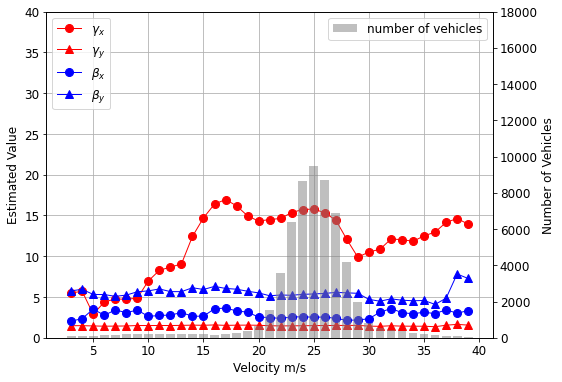

In [86]:
draw_parameters(*[ c[0:-2] for c in cali_truck])

lane-changing vehicles


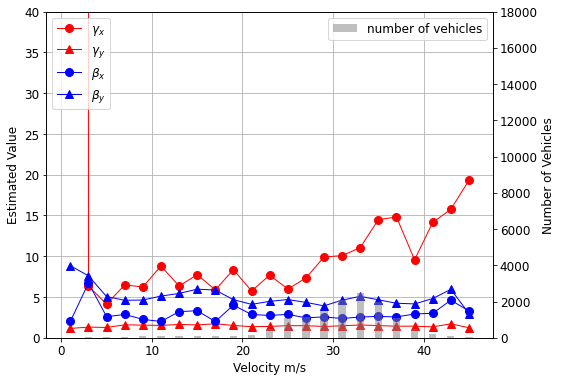

non lane-changing vehicles


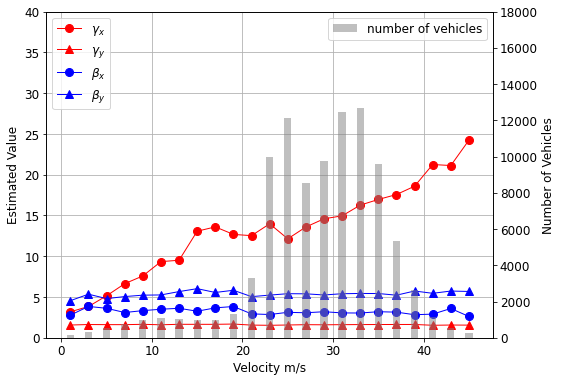

all vehicles


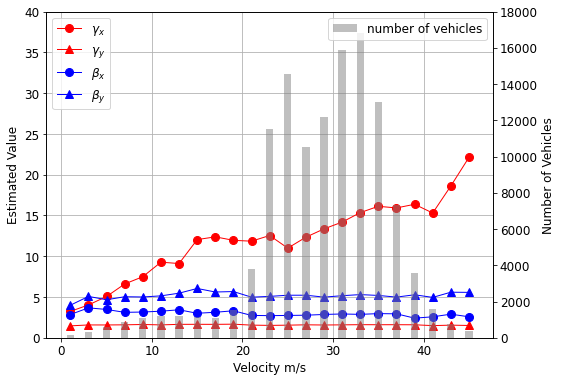

In [30]:
print ('lane-changing vehicles')
draw_parameters(*[ c[0:-2] for c in cali_lc])
print ('non lane-changing vehicles')
draw_parameters(*[ c[0:-2] for c in cali])
print ('all vehicles')
draw_parameters(*[ c[0:-2] for c in cali_all])

lane-changing vehicles


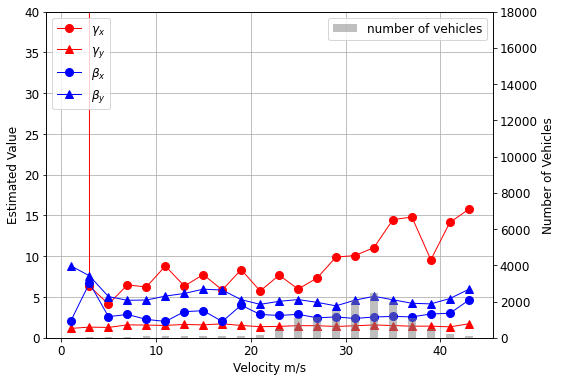

non lane-changing vehicles


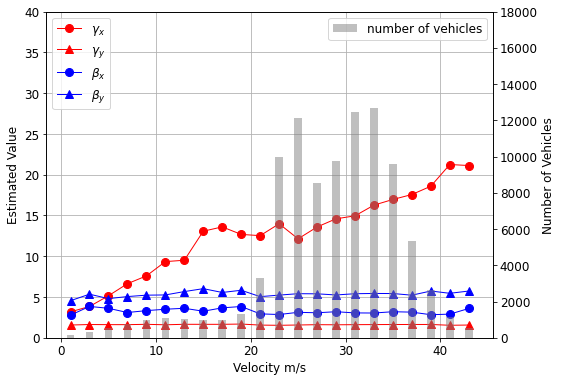

all vehicles


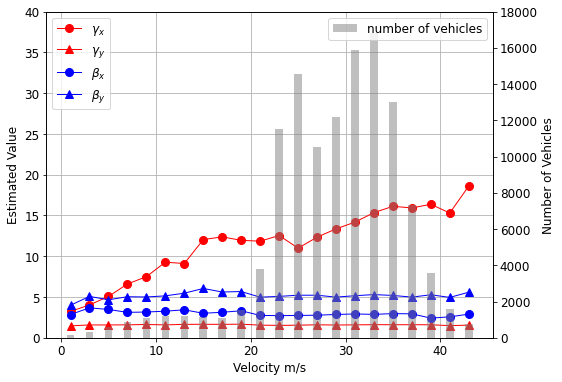

In [31]:
print ('lane-changing vehicles')
draw_parameters(*[ c[0:-3] for c in cali_lc])
print ('non lane-changing vehicles')
draw_parameters(*[ c[0:-3] for c in cali])
print ('all vehicles')
draw_parameters(*[ c[0:-3] for c in cali_all])

In [255]:
def fit_gamma_velocity(velocities, Gammas, function='linear'):
    if function=='linear':
        def func(x,a,b,c,d):
            return a*x**3+b*x**3+c*x**2+d
                
    fit = scipy.optimize.curve_fit(func, velocities, Gammas, full_output=True)

    samples_x = np.arange(velocities[0], velocities[-1], 0.1)
    samples_y = func(samples_x, *fit[0])

    plt.plot(velocities, Gammas, marker='o', color='blue')
    plt.plot(samples_x, samples_y, color='red')
    plt.show()

    return fit

In [115]:
velGroups, numVehicles, Gx, Gy, Bx, By = cali_all

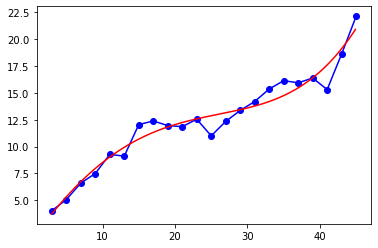

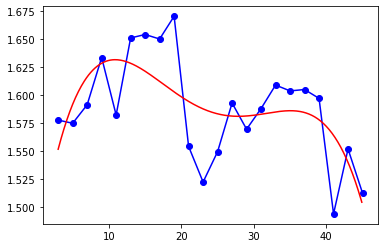

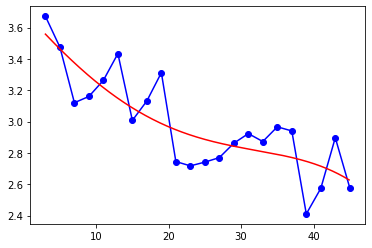

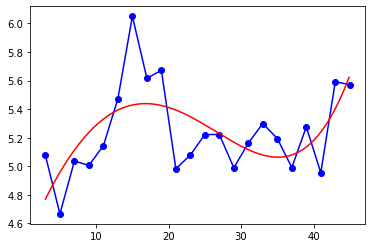

In [116]:
v_lwr = 1
v_upr = -3
fit_gx = fit_gamma_velocity(velGroups[v_lwr:v_upr], Gx[v_lwr:v_upr])
fit_gy = fit_gamma_velocity(velGroups[v_lwr:v_upr], Gy[v_lwr:v_upr])
fit_bx = fit_gamma_velocity(velGroups[v_lwr:v_upr], Bx[v_lwr:v_upr])
fit_by = fit_gamma_velocity(velGroups[v_lwr:v_upr], By[v_lwr:v_upr])

In [77]:
fit_gx[0], fit_gy[0], fit_bx[0], fit_by[0]

(array([ 5.10532144e-04, -3.70505308e-02,  1.06214262e+00,  1.29251366e+00]),
 array([ 7.61311880e-06, -6.94136117e-04,  1.67705563e-02,  1.50092134e+00]),
 array([ 2.22141983e-05, -1.48348613e-03,  9.66731742e-03,  3.25893783e+00]),
 array([ 1.32311356e-04, -1.00062293e-02,  2.18493975e-01,  3.99798919e+00]))

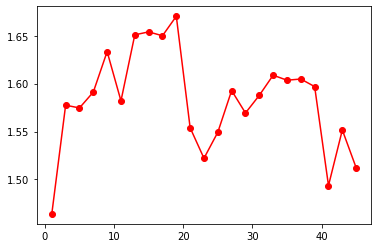

In [41]:
plt.plot(velGroups[v_lwr:v_upr], Gy[v_lwr:v_upr], marker='o', color='red')
# plt.ylim(1.2, 1.8)

In [42]:
np.min(Gy[v_lwr:v_upr])

1.4640113281249998

In [794]:
fit_gy

(array([-0.00184018,  1.63423326]),
 array([[ 6.01171386e-07, -1.50292846e-05],
        [-1.50292846e-05,  4.63903912e-04]]),
 {'fvec': array([ 0.05042533,  0.03019926, -0.01572914,  0.03199245, -0.04059143,
         -0.0473546 , -0.047008  , -0.07104032,  0.04169026,  0.06981576,
          0.03900063, -0.00819262,  0.0115321 , -0.01059123, -0.0352794 ,
         -0.03373281, -0.03864559, -0.03441345,  0.06520111,  0.00349184,
          0.03922984]),
  'nfev': 7,
  'fjac': array([[-1.27298860e+02,  5.49887236e-02,  7.06997966e-02,
           8.64108060e-02,  1.02121879e-01,  1.17832952e-01,
           1.33544025e-01,  1.49255098e-01,  1.64966107e-01,
           1.80677180e-01,  1.96388253e-01,  2.12099326e-01,
           2.27810336e-01,  2.43521409e-01,  2.59232482e-01,
           2.74943555e-01,  2.90654628e-01,  3.06365637e-01,
           3.22076710e-01,  3.37787783e-01,  3.53498856e-01],
         [-4.12415321e+00, -1.99783895e+00,  3.26059822e-01,
           2.87286400e-01,  2.485128

15.57659705 1.5910411358999998 3.60840625 5.47303196


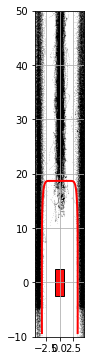

In [16]:
def get_vehicle_shape(loc, dim, rad=0, use_radians=True):
    x, y = loc
    L, W = dim
    x1, y1 = [x-L/2, y+W/2]
    x2, y2 = [x+L/2, y+W/2]
    x3, y3 = [x+L/2, y-W/2]
    x4, y4 = [x-L/2, y-W/2]
    vshape = ((x1,y1),(x2,y2),(x3,y3),(x4,y4))
    #print (L,W)
    vPolygon = Polygon(vshape)
    vPolygon = affinity.rotate(vPolygon, rad, origin='center', use_radians=use_radians)
    return vPolygon

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.grid()

v = 30
dim = [4.5, 1.7]
_data = spacings[(spacings.ego_lc==0)&(spacings.foe_lc==0)&(abs(spacings.ego_vel)>=v)&(abs(spacings.ego_vel)<v+2)&(spacings.ego_length>dim[0]-0.5)&(spacings.ego_length<=dim[0]+0.5)&(spacings.ego_width>dim[1]-0.25)&(spacings.ego_width<=dim[1]+0.25)]
_data = _data[abs(_data.ego_x - _data.foe_x)<50]
ax.scatter(_data.foe_y-_data.ego_y, (_data.foe_x-_data.ego_x)*_data.ego_vel/abs(_data.ego_vel), s=0.001, color='black')
ax.set_xlim(-4.5,4.5)
ax.set_ylim(-10, 50)
ax.set_aspect('equal', adjustable='box')
vp = get_vehicle_shape(loc=[0,0],dim=[1.7,5])
xs, ys = vp.exterior.xy
shape = ax.fill(xs, ys, 'red', alpha=0.95, ec='black')
dotx = np.arange(-5, 5, 0.2)
doty = np.arange(-9.5, 50, 0.2)
X, Y = np.meshgrid(dotx, doty)
# get ego state
Z = np.zeros(X.shape)

_gx = 0.36613795*abs(v) + 4.59245855
_gy = 1.63955982 + -1.61728947e-03*abs(v)
_bx = 2.89076305 + 0.02392144*abs(v)
_by = 5.09606816 + 0.01256546*abs(v)

print (_gx, _gy, _bx, _by)

px = []
py = []
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        x = Y[i][j]
        y = X[i][j]
        x = (abs(x) - (dim[0]/2 + 1.7/2))*x/abs(x) if abs(x)>(dim[0]/2 + 4.5/2) else 0
        y = (abs(y) - (dim[1]/2 + 1.7/2))*y/abs(y) if abs(y)>(dim[1]/2 + 1.7/2) else 0
        _x = 0 if x==0 else (abs(x)/_gx)**(_bx/2) *x/abs(x)
        _y = 0 if y==0 else (abs(y)/_gy)**(_by/2) *y/abs(y)
        f = e**-(_x**2+_y**2)
        Z[i][j] = f

CS = ax.contour(X, Y, Z, [np.exp(-1)], colors=['red'], linewidths=2.00, linestyles='solid')
# colormap = np.full(Z.shape, 'none')
# colormap[Z>0.95] = 'red'
# _Y = Y.flatten()
# _X = X.flatten()
# _Z = Z.flatten()
# ax.scatter(_X, _Y, c=['r' if v>0.5 else 'none' for v in _Z])


In [ ]:
''' all-vehicles
[4.47516975, 0.3319177, 1.60736731e+00, -1.29529047e-03, 2.61703838, 0.02790511, 4.92026546, 0.011863]
''' 

''' all-vehicles 2
[5.12342242, 0.30748837, 1.63423326, -0.00184018, 3.38193858, -0.01736166, 5.17035052e+00, 3.08414097e-03]
''' 


''' non lane-changing vehicles
[4.59245855, 0.36613795, 1.63955982, -1.61728947e-03, 2.89076305, 0.02392144, 5.09606816, 0.01256546]
'''

''' lane-changing vehicles
[2.66255944, 0.27415989, 1.54787579, -0.0024975, 2.44826446, 0.01572793, 5.24155639, -0.02038582]
'''

' lane-changing vehicles\n[2.66255944, 0.27415989, 1.54787579, -0.0024975, 2.44826446, 0.01572793, 5.24155639, -0.02038582]\n'

In [ ]:
[np.array([0.30748837, 5.12342242]),
 np.array([-0.00184018,  1.63423326]),
 np.array([-0.01736166,  3.38193858]),
 np.array([3.08414097e-03, 5.17035052e+00])]

In [304]:
params_general = [4.47516975, 0.3319177, 1.60736731e+00, -1.29529047e-03, 2.61703838, 0.02790511, 4.92026546, 0.011863]
params_general_2 = [5.12342242, 0.30748837, 1.63423326, -0.00184018, 3.38193858, -0.01736166, 5.17035052e+00, 3.08414097e-03]
params_nonlc = [4.59245855, 0.36613795, 1.63955982, -1.61728947e-03, 2.89076305, 0.02392144, 5.09606816, 0.01256546]
params_onlylc = [2.66255944, 0.27415989, 1.54787579, -0.0024975, 2.44826446, 0.01572793, 5.24155639, -0.02038582]
params_casestudies = [5.12342242, 0.30748837, 1.493584765625, 0, 3.38193858, -0.01736166, 5.17035052e+00, 0]

In [17]:
def plot_subjective_field(v, spacings, dim=[4.5, 1.7], params=[4.59245855, 0.36613795, 1.63955982, -1.61728947e-03, 2.89076305, 0.02392144, 5.09606816, 0.01256546], field_params=[], vb=2, lb=2, ignore_lc=False, plot_field=True, ignore_v=False):
    def get_vehicle_shape(loc, dim, rad=0, use_radians=True):
        x, y = loc
        L, W = dim
        x1, y1 = [x-L/2, y+W/2]
        x2, y2 = [x+L/2, y+W/2]
        x3, y3 = [x+L/2, y-W/2]
        x4, y4 = [x-L/2, y-W/2]
        vshape = ((x1,y1),(x2,y2),(x3,y3),(x4,y4))
        #print (L,W)
        vPolygon = Polygon(vshape)
        vPolygon = affinity.rotate(vPolygon, rad, origin='center', use_radians=use_radians)
        return vPolygon

    fig = plt.figure(figsize=(4,10))
    ax = fig.add_subplot(111)
    ax.grid()
    ylim = [-10, 50] if not ignore_v else [-10, 150]
    if ignore_v:
        _data = spacings
    else:
        _data = spacings[(abs(spacings.ego_vel)>=v-vb/2)&(abs(spacings.ego_vel)<v+vb/2)&(spacings.ego_length>dim[0]-lb/2)&(spacings.ego_length<=dim[0]+lb/2)]
    if not ignore_lc:
        _data = _data[(_data.ego_lc==0)&(_data.foe_lc==0)]
    _data = _data[abs(_data.ego_x - _data.foe_x)<ylim[1]]
    ax.scatter(_data.foe_y-_data.ego_y, (_data.foe_x-_data.ego_x)*_data.ego_vel/abs(_data.ego_vel), s=0.001, color='black')
    ax.set_xlim(-4.5,4.5)

    
    ax.set_ylim(*ylim) 
    ax.set_aspect('equal', adjustable='box')
    ax.tick_params(axis='x', labelsize=11)
    ax.tick_params(axis='y', labelsize=11)
    l = np.mean(_data.ego_length.values)
    w = np.mean(_data.ego_width.values)
    vp = get_vehicle_shape(loc=[0,0],dim=[w,l])
    xs, ys = vp.exterior.xy
    shape = ax.fill(xs, ys, 'red', alpha=0.95, ec='black')
    dotx = np.arange(-5, 5, 0.2)
    doty = np.arange(-9.5, ylim[1], 0.2)
    X, Y = np.meshgrid(dotx, doty)
    # get ego state
    Z = np.zeros(X.shape)
    if len(field_params):
        _gx, _gy, _bx, _by = _params
    else:
        _gx = params[0] + params[1]*abs(v)
        _gy = params[2] + params[3]*abs(v)
        _bx = params[4] + params[5]*abs(v)
        _by = params[6] + params[7]*abs(v)
    print (_gx, _gy, _bx, _by)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            x = Y[i][j]
            y = X[i][j]
            x = (abs(x) - (l/2 + dim[0]/2))*x/abs(x) if abs(x)>(l/2 + dim[0]/2) else 0
            y = (abs(y) - (w/2 + dim[1]/2))*y/abs(y) if abs(y)>(w/2 + dim[1]/2) else 0
            _x = 0 if x==0 else (abs(x)/_gx)**(_bx/2) *x/abs(x)
            _y = 0 if y==0 else (abs(y)/_gy)**(_by/2) *y/abs(y)
            f = e**-(_x**2+_y**2)
            Z[i][j] = f

    CS = ax.contour(X, Y, Z, [np.exp(-1)], colors=['red'], linewidths=2.00, linestyles='solid') if plot_field else 0
    # plt.show()
    # colormap = np.full(Z.shape, 'none')

6.660864269999999 1.493584765625 3.29513028 5.17035052


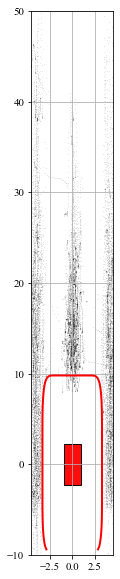

In [323]:
vel = 5
plot_subjective_field(vel, spacings, params=params_casestudies, ignore_lc=True)
plt.savefig(f"../results/aap-figures/s-field-{vel}.png")

9.73574797 1.493584765625 3.12151368 5.17035052


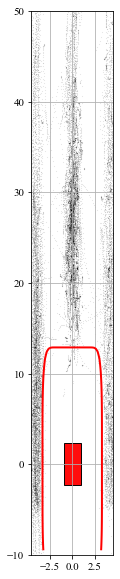

In [320]:
vel = 15
plot_subjective_field(vel, spacings, params=params_casestudies, ignore_lc=True)
plt.savefig(f"../results/aap-figures/s-field-{vel}.png")

12.81063167 1.493584765625 2.9478970799999997 5.17035052


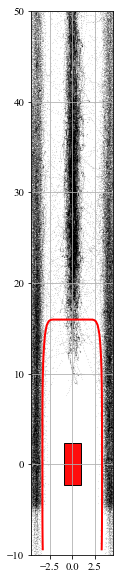

In [321]:
vel = 25
plot_subjective_field(vel, spacings, params=params_casestudies, ignore_lc=True)
plt.savefig(f"../results/aap-figures/s-field-{vel}.png")

15.88551537 1.493584765625 2.77428048 5.17035052


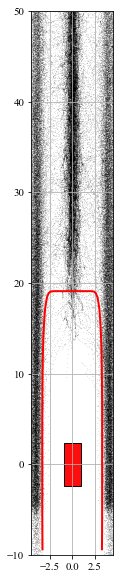

In [322]:
vel = 35
plot_subjective_field(vel, spacings, params=params_casestudies, ignore_lc=True)
plt.savefig(f"../results/aap-figures/s-field-{vel}.png")

17.77342475 1.58133739908 3.75193489 5.54842472


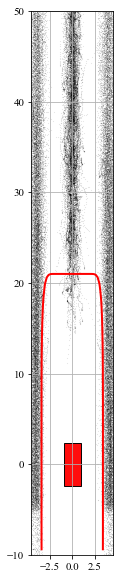

In [306]:
plot_subjective_field(36, spacings, params=params_nonlc)

16.42420695 1.56073685308 3.62162234 5.347333460000001


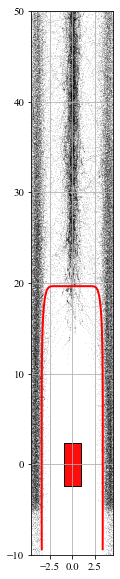

In [307]:
plot_subjective_field(36, spacings, params=params_general, ignore_lc=True)

16.19300374 1.56798678 2.75691882 5.281379594920001


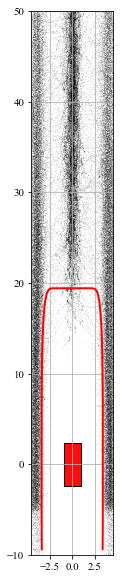

In [308]:
plot_subjective_field(36, spacings, params=params_general_2, ignore_lc=True)

16.19300374 1.493584765625 2.75691882 5.17035052


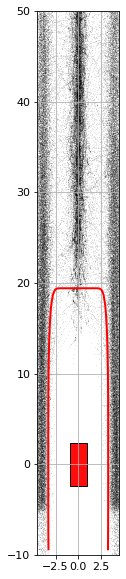

In [823]:
plot_subjective_field(36, spacings, params=params_casestudies, ignore_lc=True)

12.532315480000001 1.45796579 3.0144699399999997 4.50766687


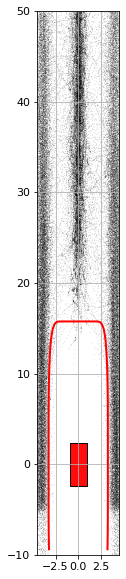

In [786]:
plot_subjective_field(36, spacings, params=params_onlylc, ignore_lc=True)

13.745907299999999 1.5991275832499998 3.48879905 5.41020466


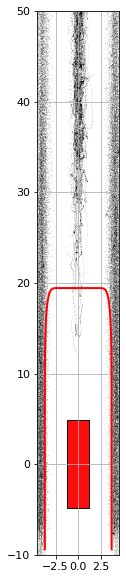

In [714]:
plot_subjective_field(25, spacings, dim=[10,2], vb=10, lb=4)

4.59245855 1.63955982 2.89076305 5.09606816


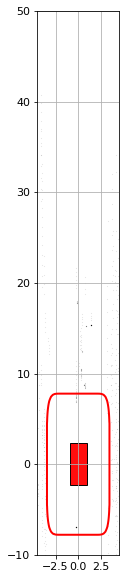

In [827]:
plot_subjective_field(0, spacings, dim=[4.5,1.7], vb=1, lb=4)

In [264]:
caliParams

(array([2.88520078]), array([2.0406832]), 10.0, 7.332438153697245)

In [283]:
_data.ego_id.unique()

array([2744., 2750., 2754., 2766., 2768., 2818., 2822.,   55.,   68.,
         77.,   80.,   89.,   90.])

In [242]:
input = _data
_x = abs(input.ego_x - input.foe_x) - (input.ego_length/2 + input.foe_length/2) + 1e-4
_y = abs(input.ego_y - input.foe_y) - (input.ego_width/2 + input.foe_width/2) + 1e-4
_x = _x.clip(0)
_y = _y.clip(0)
gx, gy, bx, by = [56.92731641870763, 1.6249162542169115, 2.0, 5.060655177451035]
risks = e**(-abs(_x/gx)**bx -abs(_y/gy)**by)
dlnL_gamma_x_2nd = ( abs(_x)**bx *bx *(((bx+1)*(1/risks)-(bx+1))*abs(gx)**bx - abs(_x)**bx *bx *(1/risks)  )   )  / (gx**2 * (1/risks-1)**2 * abs(gx)**(2*bx))
dlnL_gamma_y_2nd = ( abs(_y)**by *by *(((by+1)*(1/risks)-(by+1))*abs(gy)**by - abs(_y)**by *by *(1/risks)  )   )  / (gy**2 * (1/risks-1)**2 * abs(gy)**(2*by))
np.sum(dlnL_gamma_x_2nd) + np.sum(dlnL_gamma_y_2nd)

-3782.552518824779

In [247]:
def jlll_gx(gx, gy, bx, by):
    return np.sum(np.log(1 + 1e-4 - e**(-abs(_x/gx)**bx -abs(_y/gy)**by)))

In [249]:
derivative(jlll_gx, gx, args=(gy,bx,by), n=2)

C:\Users\Lucas\AppData\Local\Temp/ipykernel_15800/1573064782.py:1: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(jlll_gx, gx, args=(gy,bx,by), n=2)


0.47701426700768934

In [ ]:
def get_gamma_objective(gx, gy, bx, by):
    _params = np.array([0, 0, 0, 0])
    _gx, _gy, _bx, _by = np.exp(_params)
    input = _data
    _x = input.ego_x - input.foe_x
    _y = input.ego_y - input.foe_y

    gx = _gx + input.ego_length/2 + input.foe_length/2
    gy = _gy + input.ego_width/2 + input.foe_width/2
    bx = _bx + 2
    by = _by + 2

    risks = e**(-abs(_x/gx)**bx -abs(_y/gy)**by)-1e-4

    dlnL_gamma_x_2nd = ( abs(_x)**bx *bx *(((bx+1)*(1/risks)-(bx+1))*abs(gx)**bx - abs(_x)**bx *bx *(1/risks)  )   )  / (gx**2 * (1/risks-1)**2 * abs(gx)**(2*bx))
    dlnL_gamma_y_2nd = ( abs(_y)**by *by *(((by+1)*(1/risks)-(by+1))*abs(gy)**by - abs(_y)**by *by *(1/risks)  )   )  / (gy**2 * (1/risks-1)**2 * abs(gy)**(2*by))

    obj_gamma = np.sum(dlnL_gamma_x_2nd) + np.sum(dlnL_gamma_y_2nd)
    obj_beta = np.sum(1-risks)

    return obj_gamma


In [179]:
_est = np.load(r"..\results\ggd\Velocities_0_51_egolc_0_foelc_0_truck_0_ignore_1_vb_1_bootstrap_vehicles.npy")

In [180]:
_est[:,2:-3,:][0]

array([[ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.],
       [ 3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
         3.,  3.,  3.,  3.,  3.,  3.,  3.],
       [ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
         4.,  4.,  4.,  4.,  4.,  4.,  4.],
       [ 5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
         5.,  5.,  5.,  5.,  5.,  5.,  5.],
       [ 6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
         6.,  6.,  6.,  6.,  6.,  6.,  6.],
       [ 7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
         7.,  7.,  7.,  7.,  7.,  7.,  7.],
       [ 8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
         8.,  8.,  8.,  8.,  8.,  8.,  8.],
       [ 9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,
         9.,  9.,  9.,  9.,  9.,  9.,  9.],
       [10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 1

In [181]:
vels = _est[0][:,0]
gx_mean = np.mean(_est[2], axis=1)
gx_std = np.std(_est[2], axis=1)

In [182]:
gy_mean = np.mean(_est[3], axis=1)
gy_std = np.std(_est[3], axis=1)

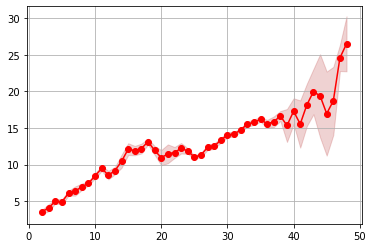

In [183]:
plt.grid()
plt.plot(vels[2:-3], gx_mean[2:-3], marker='o', color='red')
plt.fill_between(vels[2:-3], gx_mean[2:-3]-gx_std[2:-3], gx_mean[2:-3]+gx_std[2:-3], color='firebrick', alpha=0.2)

(0.0, 10.0)

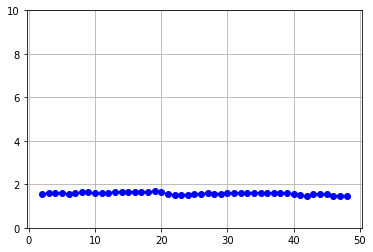

In [184]:
plt.grid()
plt.plot(vels[2:-3], gy_mean[2:-3], marker='o', color='blue')
plt.fill_between(vels[2:-3], gy_mean[2:-3]-gy_std[2:-3], gy_mean[2:-3]+gy_std[2:-3], color='steelblue', alpha=0.2)
plt.ylim(0, 10)

In [5]:
def draw_parameters_bootstrap(velocities, numVehicles, Gx, Gy, Bx, By, plt_show=True):
    fig = plt.figure(figsize=(12,8))
    plt.rcParams["font.family"] = "Times New Roman"
    ax = fig.add_subplot(111)
    ax.grid()

    velocities = velocities[:,0]
    _numVehicles = np.mean(numVehicles, axis=1)
    gx_mean = np.mean(Gx, axis=1)
    gx_std = np.std(Gx, axis=1)

    gy_mean = np.mean(Gy, axis=1)
    gy_std = np.std(Gy, axis=1)

    bx_mean = np.mean(Bx, axis=1)
    bx_std = np.std(Bx, axis=1)

    by_mean = np.mean(By, axis=1)
    by_std = np.std(By, axis=1)

    p1 = ax.plot(velocities, gx_mean, '-', label = r'$\gamma_x$', color='red', marker='o', linewidth=1, markersize=10)
    _ = ax.fill_between(velocities, gx_mean-gx_std, gx_mean+gx_std, color='firebrick', alpha=0.25)
    p2 = ax.plot(velocities, gy_mean, linestyle='dashed', label = r'$\gamma_y$', color='red', marker='^', linewidth=1, markersize=10)
    _ = ax.fill_between(velocities, gy_mean-gy_std, gy_mean+gy_std, color='firebrick', alpha=0.25)
    p3 = ax.plot(velocities, bx_mean, '-', label=r'$\beta_x$', color='blue', marker='o', linewidth=1, markersize=10)
    _ = ax.fill_between(velocities, bx_mean-bx_std, bx_mean+bx_std, color='steelblue', alpha=0.25)
    p4 = ax.plot(velocities, by_mean, linestyle='dashed', label = r'$\beta_y$', color='blue', marker='^', linewidth=1, markersize=10)
    _ = ax.fill_between(velocities, by_mean-by_std, by_mean+by_std, color='steelblue', alpha=0.25)
    ax.set_ylim(0, 25)
    ax.set_xlim(velocities[0], velocities[-1])
    ax.legend(loc='upper left', fontsize=20)
    ax.set_xlabel('Velocity m/s', fontsize=20)
    ax.set_ylabel('Estimated Value', fontsize=20)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)

    ax2 = ax.twinx()
    p5 = ax2.bar(velocities, _numVehicles, color='grey', alpha=0.5, label='number of vehicles')
    ax2.set_ylim(0, 22000)
    ax2.set_ylabel('Number of Vehicles', fontsize=20)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.legend(loc='upper right', fontsize=20)

    # ax.set_ylim(0, 7)

    _ = plt.show() if plt_show else 0

Text(0.5, 1.0, 'S-field parameter inference results')

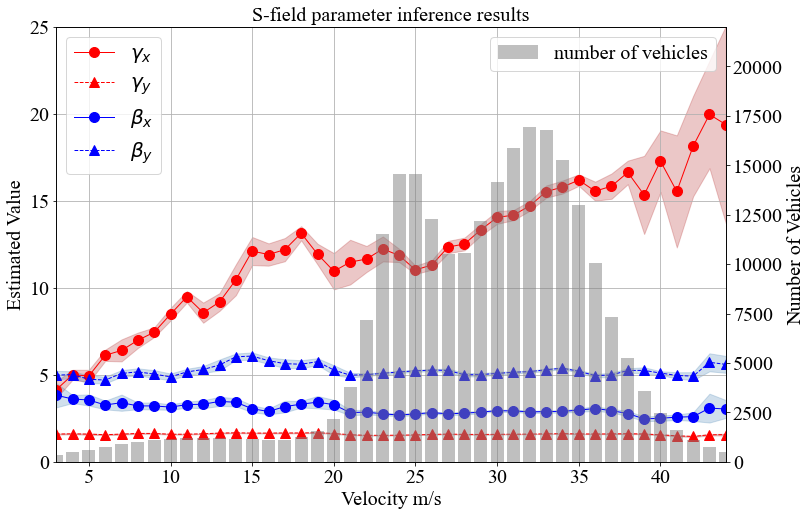

In [301]:
draw_parameters_bootstrap(*_est[:,3:-7,:], plt_show=0)
plt.title('S-field parameter inference results', fontsize=20)


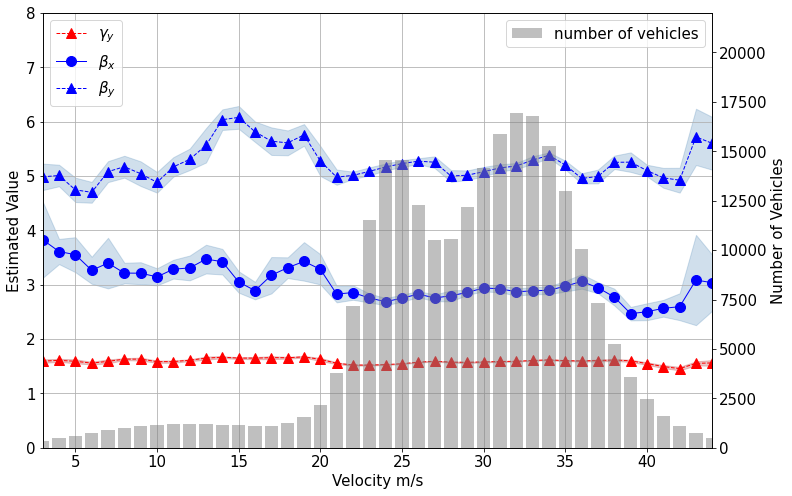

In [194]:
velocities, numVehicles, Gx, Gy, Bx, By = _est[:,3:-7,:]

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.grid()

velocities = velocities[:,0]
_numVehicles = np.mean(numVehicles, axis=1)
gx_mean = np.mean(Gx, axis=1)
gx_std = np.std(Gx, axis=1)

gy_mean = np.mean(Gy, axis=1)
gy_std = np.std(Gy, axis=1)

bx_mean = np.mean(Bx, axis=1)
bx_std = np.std(Bx, axis=1)

by_mean = np.mean(By, axis=1)
by_std = np.std(By, axis=1)

# p1 = ax.plot(velocities, gx_mean, '-', label = r'$\gamma_x$', color='red', marker='o', linewidth=1, markersize=5)
# _ = ax.fill_between(velocities, gx_mean-gx_std, gx_mean+gx_std, color='firebrick', alpha=0.25)
p2 = ax.plot(velocities, gy_mean, linestyle='dashed', label = r'$\gamma_y$', color='red', marker='^', linewidth=1, markersize=10)
_ = ax.fill_between(velocities, gy_mean-gy_std, gy_mean+gy_std, color='firebrick', alpha=0.25)
p3 = ax.plot(velocities, bx_mean, '-', label=r'$\beta_x$', color='blue', marker='o', linewidth=1, markersize=10)
_ = ax.fill_between(velocities, bx_mean-bx_std, bx_mean+bx_std, color='steelblue', alpha=0.25)
p4 = ax.plot(velocities, by_mean, linestyle='dashed', label = r'$\beta_y$', color='blue', marker='^', linewidth=1, markersize=10)
_ = ax.fill_between(velocities, by_mean-by_std, by_mean+by_std, color='steelblue', alpha=0.25)
ax.set_ylim(0, 8)
ax.set_xlim(velocities[0], velocities[-1])
ax.legend(loc='upper left', fontsize=15)
ax.set_xlabel('Velocity m/s', fontsize=15)
ax.set_ylabel('Estimated Value', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

ax2 = ax.twinx()
p5 = ax2.bar(velocities, _numVehicles, color='grey', alpha=0.5, label='number of vehicles')
ax2.set_ylim(0, 22000)
ax2.set_ylabel('Number of Vehicles', fontsize=15)
ax2.tick_params(axis='y', labelsize=15)
ax2.legend(loc='upper right', fontsize=15)

In [215]:
def fit_gamma_velocity(velocities, Gammas, function='linear', order=3, plot=True):
    if function=='linear':
        def func(x,a,b,c,d):
            return a*x**3+b*x**2+c*x**1+d
                
    fit = scipy.optimize.curve_fit(func, velocities, Gammas, full_output=True)

    samples_x = np.arange(velocities[0], velocities[-1], 0.1)
    samples_y = func(samples_x, *fit[0])
    if plot:
        plt.plot(velocities, Gammas, marker='o', color='blue')
        plt.plot(samples_x, samples_y, color='red')
        plt.show()

    return fit

In [216]:
def fit_beta_velocity(velocities, Gammas, function='linear', order=3, plot=True):
    if function=='linear':
        def func(x,a,b,c,d):
            return a*x**3+b*x**2+c*x**1+d
                
    fit = scipy.optimize.curve_fit(func, velocities, Gammas, full_output=True)

    samples_x = np.arange(velocities[0], velocities[-1], 0.1)
    samples_y = func(samples_x, *fit[0])
    if plot:
        plt.plot(velocities, Gammas, marker='o', color='blue')
        plt.plot(samples_x, samples_y, color='red')
        plt.show()

    return fit

In [203]:
_est[0].shape, _est[2].shape

((52, 20), (52, 20))

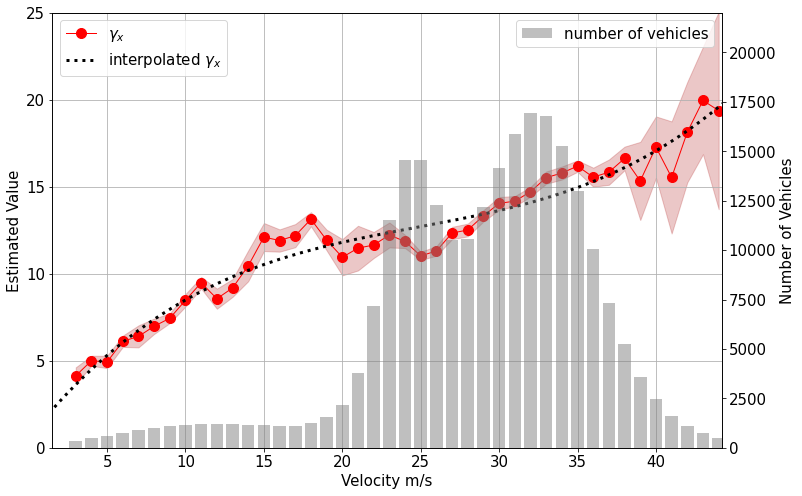

In [254]:
velocities, numVehicles, Gx, Gy, Bx, By = _est[:,3:-7,:]

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.grid()

velocities = velocities[:,0]
_numVehicles = np.mean(numVehicles, axis=1)
gx_mean = np.mean(Gx, axis=1)
gx_std = np.std(Gx, axis=1)

gy_mean = np.mean(Gy, axis=1)
gy_std = np.std(Gy, axis=1)

bx_mean = np.mean(Bx, axis=1)
bx_std = np.std(Bx, axis=1)

by_mean = np.mean(By, axis=1)
by_std = np.std(By, axis=1)

p1 = ax.plot(velocities, gx_mean, '-', label = r'$\gamma_x$', color='red', marker='o', linewidth=1, markersize=10)
_ = ax.fill_between(velocities, gx_mean-gx_std, gx_mean+gx_std, color='firebrick', alpha=0.25)
# p2 = ax.plot(velocities, gy_mean, linestyle='dashed', label = r'$\gamma_y$', color='red', marker='^', linewidth=1, markersize=10)
# _ = ax.fill_between(velocities, gy_mean-gy_std, gy_mean+gy_std, color='firebrick', alpha=0.25)
# p3 = ax.plot(velocities, bx_mean, '-', label=r'$\beta_x$', color='blue', marker='o', linewidth=1, markersize=10)
# _ = ax.fill_between(velocities, bx_mean-bx_std, bx_mean+bx_std, color='steelblue', alpha=0.25)
# p4 = ax.plot(velocities, by_mean, linestyle='dashed', label = r'$\beta_y$', color='blue', marker='^', linewidth=1, markersize=10)
# _ = ax.fill_between(velocities, by_mean-by_std, by_mean+by_std, color='steelblue', alpha=0.25)

xs = np.arange(0, 50, 0.1)
# _xs = np.vstack([xs**3, xs**2, xs**1, 1])
_params = [ 5.16670364e-04, -3.84524708e-02,  1.12345459e+00,  5.92099948e-01]
_fit = [  _x**3*_params[0] + _x**2*_params[1] + _x**1*_params[2] + _x**0*_params[3]  for _x in xs]
ax.plot(xs, _fit, color='black', linestyle='dotted', label='interpolated $\gamma_x$', linewidth=3)



ax.set_ylim(0, 25)
ax.set_xlim(1.5, 44.2)
ax.legend(loc='upper left', fontsize=15)
ax.set_xlabel('Velocity m/s', fontsize=15)
ax.set_ylabel('Estimated Value', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

ax2 = ax.twinx()
p5 = ax2.bar(velocities, _numVehicles, color='grey', alpha=0.5, label='number of vehicles')
ax2.set_ylim(0, 22000)
ax2.set_ylabel('Number of Vehicles', fontsize=15)
ax2.tick_params(axis='y', labelsize=15)
ax2.legend(loc='upper right', fontsize=15)

plt.show()




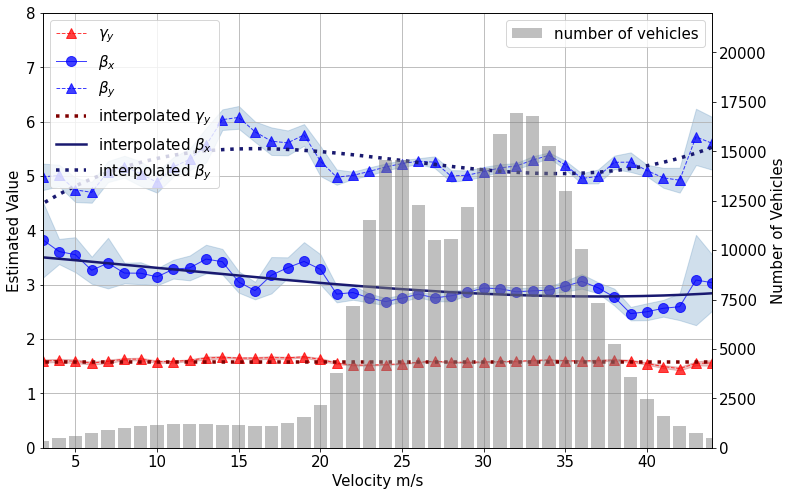

In [282]:
velocities, numVehicles, Gx, Gy, Bx, By = _est[:,3:-7,:]

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.grid()

velocities = velocities[:,0]
_numVehicles = np.mean(numVehicles, axis=1)
gx_mean = np.mean(Gx, axis=1)
gx_std = np.std(Gx, axis=1)

gy_mean = np.mean(Gy, axis=1)
gy_std = np.std(Gy, axis=1)

bx_mean = np.mean(Bx, axis=1)
bx_std = np.std(Bx, axis=1)

by_mean = np.mean(By, axis=1)
by_std = np.std(By, axis=1)

# p1 = ax.plot(velocities, gx_mean, '-', label = r'$\gamma_x$', color='red', marker='o', linewidth=1, markersize=5)
# _ = ax.fill_between(velocities, gx_mean-gx_std, gx_mean+gx_std, color='firebrick', alpha=0.25)
p2 = ax.plot(velocities, gy_mean, linestyle='dashed', label = r'$\gamma_y$', color='red', marker='^', linewidth=1, markersize=10, alpha=0.75)
_ = ax.fill_between(velocities, gy_mean-gy_std, gy_mean+gy_std, color='firebrick', alpha=0.25)
p3 = ax.plot(velocities, bx_mean, '-', label=r'$\beta_x$', color='blue', marker='o', linewidth=1, markersize=10, alpha=0.75)
_ = ax.fill_between(velocities, bx_mean-bx_std, bx_mean+bx_std, color='steelblue', alpha=0.25)
p4 = ax.plot(velocities, by_mean, linestyle='dashed', label = r'$\beta_y$', color='blue', marker='^', linewidth=1, markersize=10, alpha=0.75)
_ = ax.fill_between(velocities, by_mean-by_std, by_mean+by_std, color='steelblue', alpha=0.25)

# _params_2 = [ 2.37805166e-06, -2.44774882e-04,  5.36180560e-03,  1.58097272e+00]
_params_2 = [ 0, 0,  0,  1.58097272e+00]
_params_3 = [ 1.40631360e-05, -4.61636551e-04, -2.36508315e-02,  3.57855533e+00]
_params_4 = [ 1.45599500e-04, -1.10464338e-02,  2.42067978e-01,  3.86165882e+00]

_fit_2 = [  _x**3*_params_2[0] + _x**2*_params_2[1] + _x**1*_params_2[2] + _x**0*_params_2[3]  for _x in xs]
ax.plot(xs, _fit_2, color='maroon', linestyle='dotted', label=r'interpolated $\gamma_y$', linewidth=3.5)

_fit_3 = [  _x**3*_params_3[0] + _x**2*_params_3[1] + _x**1*_params_3[2] + _x**0*_params_3[3]  for _x in xs]
ax.plot(xs, _fit_3, color='midnightblue', linestyle='solid', label=r"interpolated $\beta_x$", linewidth=2.5)

_fit_4 = [  _x**3*_params_4[0] + _x**2*_params_4[1] + _x**1*_params_4[2] + _x**0*_params_4[3]  for _x in xs]
ax.plot(xs, _fit_4, color='midnightblue', linestyle='dotted', label=r"interpolated $\beta_y$", linewidth=3.5)


ax.set_ylim(0, 8)
ax.set_xlim(velocities[0], velocities[-1])
ax.legend(loc='upper left', fontsize=15)
ax.set_xlabel('Velocity m/s', fontsize=15)
ax.set_ylabel('Estimated Value', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)



ax2 = ax.twinx()
p5 = ax2.bar(velocities, _numVehicles, color='grey', alpha=0.5, label='number of vehicles')
ax2.set_ylim(0, 22000)
ax2.set_ylabel('Number of Vehicles', fontsize=15)
ax2.tick_params(axis='y', labelsize=15)
ax2.legend(loc='upper right', fontsize=15)


In [236]:
# vels = _est[0][:,0]
# Gx = np.mean(_est[2], axis=1)
# Gy = np.mean(_est[3], axis=1)
# Bx = np.mean(_est[4], axis=1)
# By = np.mean(_est[5], axis=1)

vels = _est[0]
Gx = _est[2]
Gy = _est[3]
Bx = _est[4]
By = _est[5]

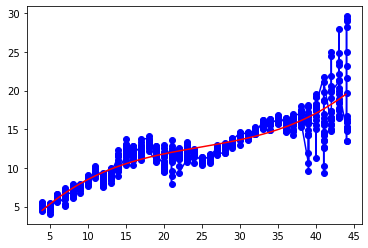

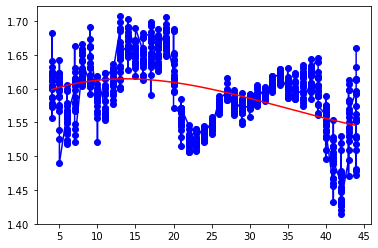

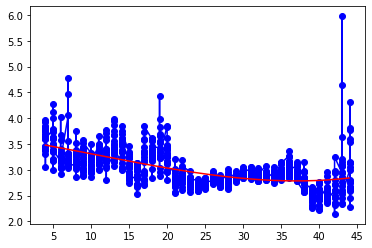

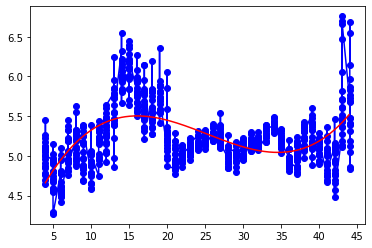

In [237]:
v_lwr = 4
v_upr = -7
fit_gx = fit_gamma_velocity(vels[v_lwr:v_upr].flatten(), Gx[v_lwr:v_upr].flatten())
fit_gy = fit_beta_velocity(vels[v_lwr:v_upr].flatten(), Gy[v_lwr:v_upr].flatten())
fit_bx = fit_beta_velocity(vels[v_lwr:v_upr].flatten(), Bx[v_lwr:v_upr].flatten())
fit_by = fit_beta_velocity(vels[v_lwr:v_upr].flatten(), By[v_lwr:v_upr].flatten())

In [218]:
fit_gx[0]

array([ 5.16670364e-04, -3.84524708e-02,  1.12345459e+00,  5.92099948e-01])

In [256]:
fit_bx[0]

array([ 1.40631360e-05, -4.61636551e-04, -2.36508315e-02,  3.57855533e+00])

In [257]:
fit_gy[0]

array([ 2.37805166e-06, -2.44774882e-04,  5.36180560e-03,  1.58097272e+00])

In [258]:
fit_by[0]

array([ 1.45599500e-04, -1.10464338e-02,  2.42067978e-01,  3.86165882e+00])

In [ ]:
plt.errorbar(vels[2:-3], gx_mean[2:-3],  )

(0.0, 40.0)

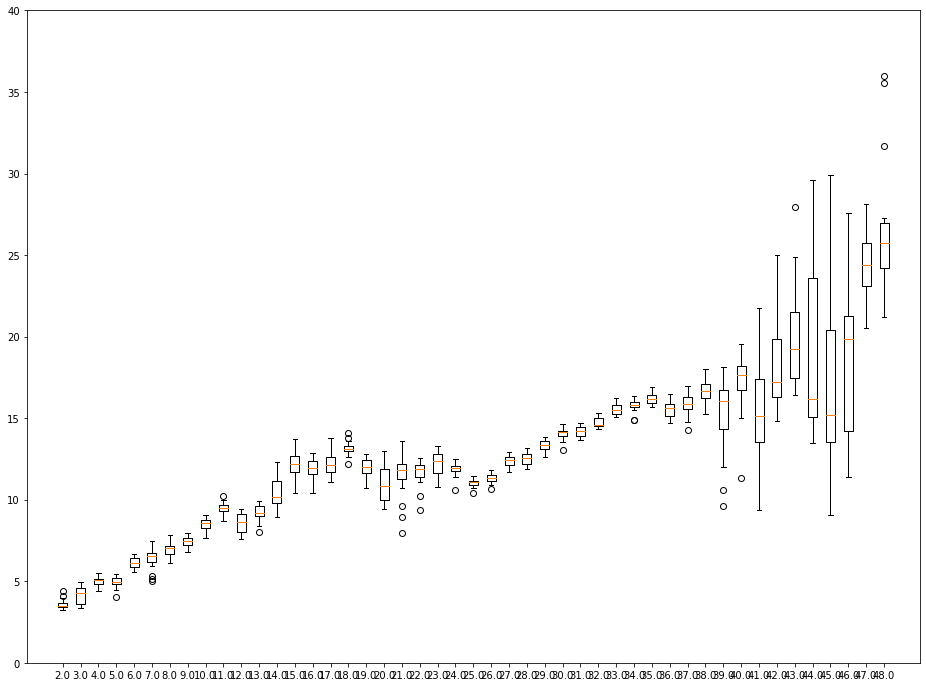

In [273]:
plt.figure(figsize=(16,12))
plt.boxplot(_est[2][2:-3].T, positions=vels[2:-3])
plt.xlim(0,50)
plt.ylim(0,40)

In [166]:
gx_std

array([4.46498240e+03, 3.52949036e+03, 2.88035449e-01, 4.83339099e-01,
       2.88096629e-01, 3.54887919e-01, 3.23942987e-01, 6.31736132e-01,
       4.42022545e-01, 2.77894101e-01, 3.58999134e-01, 3.32015274e-01,
       5.78786182e-01, 5.10644475e-01, 8.84956080e-01, 8.06494115e-01,
       6.40679059e-01, 6.65551398e-01, 4.05971952e-01, 5.94738298e-01,
       1.04284302e+00, 1.28450115e+00, 7.48485471e-01, 7.18353718e-01,
       3.79841651e-01, 2.38105068e-01, 2.72654522e-01, 3.53465338e-01,
       3.66133633e-01, 3.28786263e-01, 3.67799793e-01, 2.91419167e-01,
       2.80048370e-01, 3.52145057e-01, 3.73252271e-01, 3.28869694e-01,
       5.45417093e-01, 7.26657068e-01, 6.77026962e-01, 2.24601233e+00,
       1.76596167e+00, 3.22264296e+00, 2.88546094e+00, 3.08764354e+00,
       5.67039443e+00, 5.73095932e+00, 4.63929540e+00, 1.79213210e+00,
       3.75674462e+00, 1.40970274e+01, 1.60808467e+01, 2.07955036e+01])

In [171]:
est = np.load(r"D:\Productivity\Paper\RSS2024-Journal\results\ggd\Velocities_0_51_egolc_0_foelc_0_truck_0_ignore_1_vb_1.npy")

In [172]:
est.shape

(6, 52, 20)

In [173]:
vels = est[0][:,0]
gx_mean = np.mean(est[2], axis=1)
gy_mean = np.mean(est[3], axis=1)

In [174]:
gx_mean

array([1.02734644e+04, 3.23517904e+00, 3.69218574e+00, 4.03374992e+00,
       4.89898402e+00, 5.07721857e+00, 5.99609744e+00, 6.63574250e+00,
       6.92531770e+00, 7.49926934e+00, 8.50736359e+00, 9.28770752e+00,
       9.12394402e+00, 9.12049047e+00, 1.07329093e+01, 1.20205181e+01,
       1.16996351e+01, 1.23894920e+01, 1.28460263e+01, 1.19715842e+01,
       1.09978261e+01, 1.18433851e+01, 1.18493364e+01, 1.25354786e+01,
       1.18044045e+01, 1.09823653e+01, 1.13586627e+01, 1.23328638e+01,
       1.25261769e+01, 1.33666299e+01, 1.40670350e+01, 1.41917764e+01,
       1.46867926e+01, 1.53741370e+01, 1.59118061e+01, 1.61365342e+01,
       1.58797877e+01, 1.59513531e+01, 1.67477635e+01, 1.64027904e+01,
       1.70030112e+01, 1.55025909e+01, 1.74169195e+01, 1.87437658e+01,
       1.56428317e+01, 2.08672006e+01, 2.19315337e+01, 2.43340333e+01,
       2.44473479e+01, 3.66005777e+01, 4.02227476e+01, 6.35535654e+00])

In [175]:
est[2][5]

array([5.13906016, 5.04154805, 5.07502773, 5.08636992, 5.12024062,
       5.02573477, 5.05762891, 5.10976328, 5.09016719, 5.14337812,
       5.04740742, 5.07551875, 5.12728555, 5.10372734, 5.04452187,
       5.05628477, 5.04728672, 5.03407969, 5.08446094, 5.03487969])

In [176]:
est[2][1:-3].T.shape

(20, 48)

In [177]:
vels[1:-3].shape

(48,)

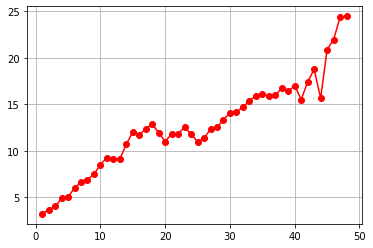

In [130]:
plt.grid()
plt.plot(vels[1:-3], gx_mean[1:-3], marker='o', color='red')

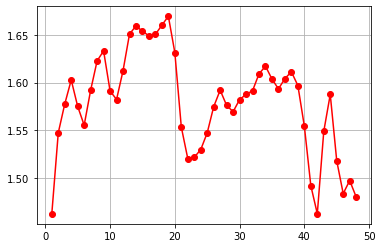

In [132]:
plt.grid()
plt.plot(vels[1:-3], gy_mean[1:-3], marker='o', color='red')

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\Lucas\AppData\Local\Temp/ipykernel_23784/3458030131.py:15: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(jlll_gx, gx, args=(gy,bx,by), n=2)
C:\Users\Lucas\AppData\Local\Temp/ipykernel_23784/3458030131.py:18: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(jlll_gy, gy, args=(gx,bx,by), n=2)
100%|██████████| 1/1 [00:08<00:00,  8.28s/it]

---gx:[9.86346953] gy:[1.10660117] bx:2.982447980097398 by:8.111216401017582---
[9.86346953] [1.10660117] 2.982447980097398 8.111216401017582


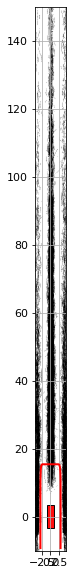

In [183]:
_data = spacings[(spacings.ego_lc==0)&(abs(spacings.ego_vel)-abs(spacings.foe_vel)>=0.5)&(abs(spacings.ego_vel)-abs(spacings.foe_vel)<1)]
_params = calibrate_subjective_field_1(_data, gx=10, gy=2, bx=2, by=2, outer_max_it=1)
plot_subjective_field(0, _data, plot_field=True, ignore_v=True, field_params=_params)

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\Lucas\AppData\Local\Temp/ipykernel_23784/3458030131.py:15: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(jlll_gx, gx, args=(gy,bx,by), n=2)
C:\Users\Lucas\AppData\Local\Temp/ipykernel_23784/3458030131.py:18: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(jlll_gy, gy, args=(gx,bx,by), n=2)
100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

---gx:[20.34138516] gy:[1.06928008] bx:2.8706763087088105 by:7.296853679419623---
[20.34138516] [1.06928008] 2.8706763087088105 7.296853679419623


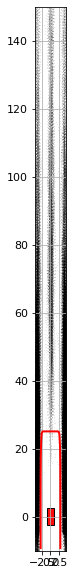

In [190]:
_data = spacings[(spacings.ego_lc==0)&(abs(spacings.ego_vel)-abs(spacings.foe_vel)>=4)&(abs(spacings.ego_vel)-abs(spacings.foe_vel)<5)]
_params = calibrate_subjective_field_1(_data, gx=10, gy=1, bx=2, by=2, outer_max_it=1)
plot_subjective_field(0, _data, plot_field=True, ignore_v=True, field_params=_params)

In [145]:
# input = _data[abs(_data.foe_y - _data.ego_y)<1]
# spac_ = abs(input.ego_x - input.foe_x) - (input.ego_length/2 + input.foe_length/2) 
# plt.hist(spac_, np.arange(-10, 150, 1), color='red' )

25.0 79.80000000000078
0.8 2.3


100%|██████████| 1/1 [00:16<00:00, 16.95s/it]

---gx:29.500000000000064 gy:1.0 bx:2.5000000000000004 by:6.700000000000005---
29.500000000000064 1.0 2.5000000000000004 6.700000000000005


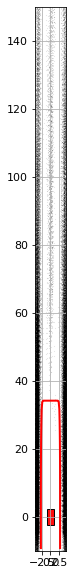

In [21]:
_data = spacings[(spacings.ego_lc==0)&(abs(spacings.ego_vel)-abs(spacings.foe_vel)>=7)&(abs(spacings.ego_vel)-abs(spacings.foe_vel)<8)]
_params = calibrate_subjective_field_3(_data, gx=20, gy=2, bx=2, by=2, outer_max_it=1)
plot_subjective_field(0, _data, plot_field=True, ignore_v=True, field_params=_params)

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\Lucas\AppData\Local\Temp/ipykernel_25124/3458030131.py:15: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(jlll_gx, gx, args=(gy,bx,by), n=2)
C:\Users\Lucas\AppData\Local\Temp/ipykernel_25124/3458030131.py:18: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(jlll_gy, gy, args=(gx,bx,by), n=2)
100%|██████████| 1/1 [00:01<00:00,  1.88s/it]

---gx:[26.92519297] gy:[1.05796133] bx:2.5475737827242053 by:7.305777044817263---


[26.92519297] [1.05796133] 2.5475737827242053 7.305777044817263


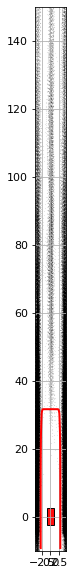

In [18]:
_data = spacings[(spacings.ego_lc==0)&(abs(spacings.ego_vel)-abs(spacings.foe_vel)>=5)&(abs(spacings.ego_vel)-abs(spacings.foe_vel)<6)]
_params = calibrate_subjective_field_1(_data, gx=20, gy=2, bx=2, by=2, outer_max_it=1)
plot_subjective_field(0, _data, plot_field=True, ignore_v=True, field_params=_params)

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\Lucas\AppData\Local\Temp/ipykernel_25124/3458030131.py:15: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(jlll_gx, gx, args=(gy,bx,by), n=2)
C:\Users\Lucas\AppData\Local\Temp/ipykernel_25124/3458030131.py:18: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(jlll_gy, gy, args=(gx,bx,by), n=2)
100%|██████████| 1/1 [00:07<00:00,  7.45s/it]

---gx:[17.4393207] gy:[1.07501875] bx:2.862810348251308 by:6.1270150809142585---
[17.4393207] [1.07501875] 2.862810348251308 6.1270150809142585


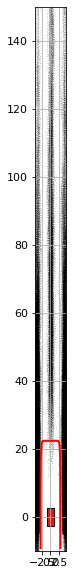

In [19]:
_data = spacings[(spacings.ego_lc==False)&(abs(spacings.ego_vel)-abs(spacings.foe_vel)>=3)&(abs(spacings.ego_vel)-abs(spacings.foe_vel)<4)]
_params = calibrate_subjective_field_1(_data, gx=20, gy=2, bx=2, by=2, outer_max_it=1)
plot_subjective_field(0, _data, plot_field=True, ignore_v=True, field_params=_params)

(array([248525., 193317., 152925., 125010., 107400.,  97506.,  88792.,
         81048.,  73970.,  69721.,  64350.,  60376.,  55700.,  50135.,
         46378.,  42006.,  38444.,  33744.,  28398.,  23041.,  19613.,
         15630.,  12664.,   9506.,   7589.,   5825.,   4685.,   3563.,
          2648.,   2042.,   1630.,   1335.,   1065.,    972.,    548.,
           400.,    438.,    334.,    321.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5]),
 <BarContainer object of 39 artists>)

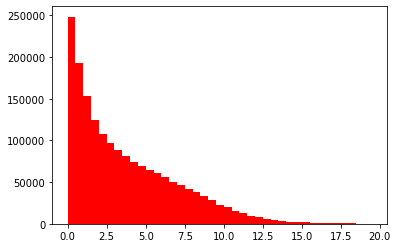

In [15]:
plt.hist(abs(spacings.ego_vel)-abs(spacings.foe_vel), np.arange(0, 20, 0.5), color='red')

4.59245855 1.63955982 2.89076305 5.09606816


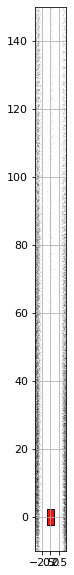

In [17]:
_data = spacings[(spacings.ego_lc==0)&(spacings.foe_lc==0)&(abs(spacings.ego_vel)-abs(spacings.foe_vel)>=11)&(abs(spacings.ego_vel)-abs(spacings.foe_vel)<12)]
_data
plot_subjective_field(0, _data, plot_field=False, ignore_v=True)

4.59245855 1.63955982 2.89076305 5.09606816


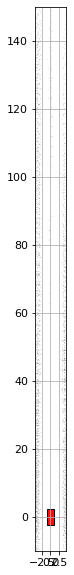

In [16]:
_data = spacings[(spacings.ego_lc==0)&(spacings.foe_lc==0)&(abs(spacings.ego_vel)-abs(spacings.foe_vel)>=14)&(abs(spacings.ego_vel)-abs(spacings.foe_vel)<15)]
_data
plot_subjective_field(0, _data, plot_field=False, ignore_v=True)

4.59245855 1.63955982 2.89076305 5.09606816


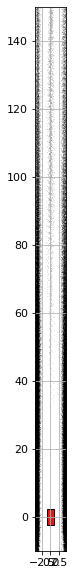

In [55]:
_data = spacings[(spacings.ego_lc==0)&(spacings.foe_lc==0)&(abs(spacings.ego_vel)-abs(spacings.foe_vel)>=8)&(abs(spacings.ego_vel)-abs(spacings.foe_vel)<10)]
_data
plot_subjective_field(0, _data, plot_field=False, ignore_v=True)

4.59245855 1.63955982 2.89076305 5.09606816


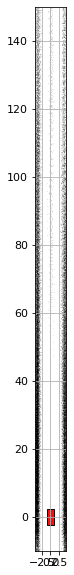

In [56]:
_data = spacings[(spacings.ego_lc==0)&(spacings.foe_lc==0)&(abs(spacings.ego_vel)-abs(spacings.foe_vel)>=10)&(abs(spacings.ego_vel)-abs(spacings.foe_vel)<12)]
_data
plot_subjective_field(0, _data, plot_field=False, ignore_v=True)

,ego_id,foe_id,recording_id,frame,ego_x,ego_y,foe_x,foe_y,ego_vel,ego_truck,...,foe_truck,foe_lc,ego_length,ego_width,foe_length,foe_width,y_marker1,y_marker2,y_bound1,y_bound2
129,10.0,6.0,1.0,8.0,212.330,26.92,254.10,26.91,23.26,1.0,...,1.0,0.0,9.20,2.50,11.82,2.50,0.0,0.0,0.0,0.0
130,10.0,6.0,1.0,13.0,217.010,26.92,258.72,26.91,23.29,1.0,...,1.0,0.0,9.20,2.50,11.82,2.50,0.0,0.0,0.0,0.0
131,10.0,6.0,1.0,18.0,221.620,26.91,263.39,26.90,23.32,1.0,...,1.0,0.0,9.20,2.50,11.82,2.50,0.0,0.0,0.0,0.0
132,10.0,6.0,1.0,23.0,226.290,26.89,268.03,26.90,23.35,1.0,...,1.0,0.0,9.20,2.50,11.82,2.50,0.0,0.0,0.0,0.0
133,10.0,6.0,1.0,28.0,231.000,26.86,272.68,26.89,23.37,1.0,...,1.0,0.0,9.20,2.50,11.82,2.50,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39300,1462.0,1458.0,60.0,24000.0,293.455,10.51,239.44,10.83,-28.98,0.0,...,0.0,0.0,2.93,1.82,3.44,1.82,0.0,0.0,0.0,0.0
39302,1462.0,1458.0,60.0,24005.0,287.665,10.51,233.84,10.81,-28.97,0.0,...,0.0,0.0,2.93,1.82,3.44,1.82,0.0,0.0,0.0,0.0
39304,1462.0,1458.0,60.0,24010.0,281.875,10.51,228.23,10.80,-28.96,0.0,...,0.0,0.0,2.93,1.82,3.44,1.82,0.0,0.0,0.0,0.0
39306,1462.0,1458.0,60.0,24015.0,276.095,10.51,222.59,10.78,-28.95,0.0,...,0.0,0.0,2.93,1.82,3.44,1.82,0.0,0.0,0.0,0.0


In [20]:
spacings[(spacings.ego_lc==0)&(spacings.foe_lc==0)&(abs(spacings.ego_vel)-abs(spacings.foe_vel)>=2)&(abs(spacings.ego_vel)-abs(spacings.foe_vel)<4)]

,ego_id,foe_id,recording_id,frame,ego_x,ego_y,foe_x,foe_y,ego_vel,ego_truck,...,foe_truck,foe_lc,ego_length,ego_width,foe_length,foe_width,y_marker1,y_marker2,y_bound1,y_bound2
399,36.0,34.0,1.0,656.0,402.800,14.46,376.340,10.41,-37.22,0.0,...,0.0,0.0,3.94,1.82,3.84,1.82,0.0,0.0,0.0,0.0
400,36.0,34.0,1.0,661.0,395.390,14.44,369.640,10.39,-37.25,0.0,...,0.0,0.0,3.94,1.82,3.84,1.82,0.0,0.0,0.0,0.0
401,36.0,34.0,1.0,666.0,387.960,14.42,362.970,10.37,-37.27,0.0,...,0.0,0.0,3.94,1.82,3.84,1.82,0.0,0.0,0.0,0.0
1223,69.0,66.0,1.0,1575.0,119.085,14.20,122.750,10.01,-28.64,0.0,...,0.0,0.0,4.65,2.02,3.54,1.92,0.0,0.0,0.0,0.0
1263,71.0,56.0,1.0,1431.0,108.285,27.11,401.280,26.98,29.82,0.0,...,0.0,0.0,4.95,2.12,5.96,2.32,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39247,1461.0,1455.0,60.0,23958.0,98.565,29.13,195.875,29.17,33.73,0.0,...,0.0,0.0,4.55,1.82,4.65,1.92,0.0,0.0,0.0,0.0
39248,1461.0,1455.0,60.0,23963.0,105.295,29.12,202.195,29.19,33.77,0.0,...,0.0,0.0,4.55,1.82,4.65,1.92,0.0,0.0,0.0,0.0
39249,1461.0,1455.0,60.0,23968.0,112.065,29.09,208.505,29.21,33.81,0.0,...,0.0,0.0,4.55,1.82,4.65,1.92,0.0,0.0,0.0,0.0
39250,1461.0,1455.0,60.0,23973.0,118.825,29.06,214.875,29.23,33.84,0.0,...,0.0,0.0,4.55,1.82,4.65,1.92,0.0,0.0,0.0,0.0


In [ ]:
plot_subjective_field(0, _data, plot_field=False, ignore_v=True)

In [163]:
recordingIDs = [28,29,30,31,32,33,34,35,36,37,38]

In [164]:
track01 = pd.concat( [ pd.read_csv(f"E:\Data\highd-dataset-v1.0\data\{rid:02}_tracks.csv") for rid in tqdm(recordingIDs) ]  )

100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


In [165]:
np.percentile(track01[track01.ttc>0].ttc, 5)

9.62

(array([5.0000e+01, 6.5800e+02, 2.7170e+03, 7.4130e+03, 1.3536e+04,
        2.0961e+04, 2.5637e+04, 3.2550e+04, 3.7853e+04, 4.3242e+04,
        4.7440e+04, 4.8661e+04, 5.1187e+04, 5.3813e+04, 5.6197e+04,
        5.6281e+04, 5.5347e+04, 5.5495e+04, 5.4653e+04, 5.5778e+04,
        5.4440e+04, 5.2950e+04, 5.2275e+04, 4.8646e+04, 4.8191e+04,
        4.5718e+04, 4.4587e+04, 4.1455e+04, 4.0718e+04, 3.9596e+04,
        3.7929e+04, 3.8412e+04, 3.7360e+04, 3.6379e+04, 3.5537e+04,
        3.3974e+04, 3.2449e+04, 3.2085e+04, 3.1722e+04, 3.0524e+04,
        2.9573e+04, 2.8633e+04, 2.7672e+04, 2.6885e+04, 2.5944e+04,
        2.5247e+04, 2.4650e+04, 2.3578e+04, 2.3378e+04, 2.3034e+04,
        2.2048e+04, 2.1910e+04, 2.0586e+04, 1.9894e+04, 1.9216e+04,
        1.9252e+04, 1.9017e+04, 1.8766e+04, 1.7954e+04, 1.7205e+04,
        1.7373e+04, 1.6885e+04, 1.6371e+04, 1.6099e+04, 1.5693e+04,
        1.5150e+04, 1.4843e+04, 1.4837e+04, 1.4219e+04, 1.3805e+04,
        1.3706e+04, 1.3370e+04, 1.2750e+04, 1.28

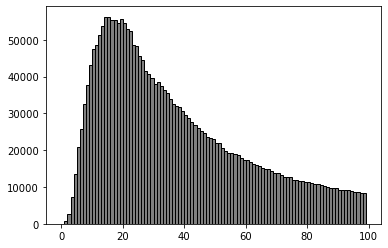

In [166]:
plt.hist(track01[track01.ttc>0].ttc, bins=np.arange(0, 100, 1), edgecolor='black', facecolor='grey')

In [428]:
angle = np.arcsin(track01.yVelocity/np.sqrt(track01.xVelocity**2+track01.yVelocity**2) )*180/np.pi
plt.hist(angle, bins=np.arange(-3, 3, 0.1), facecolor='red', edgecolor='grey', density=True)
# plt.grid()
plt.ylabel(r'Vehicle angle ($\degree$)')
plt.xlabel('Probability density')
plt.title('Distribution of vehicle moving angle in HighD')
plt.show()

RuntimeError: latex was not able to process the following string:
b'Vehicle angle ($\\\\degree$)'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.24 (MiKTeX 22.3) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(C:/Users/Lucas/.matplotlib/tex.cache/900865de58b1e5f4675eaee40d6184d3.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-02-24>
(C:\Program Files\MiKTeX\tex/latex/base\article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(C:\Program Files\MiKTeX\tex/latex/base\size10.clo))
(C:\Program Files\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Program Files\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Program Files\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Program Files\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Program Files\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Program Files\MiKTeX\tex/latex/graphics\keyval.sty)
(C:\Program Files\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Program Files\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Program Files\MiKTeX\tex/latex/geometry\geometry.cfg))
(C:\Program Files\MiKTeX\tex/latex/base\textcomp.sty)
(C:\Program Files\MiKTeX\tex/latex/l3backend\l3backend-dvips.def)
No file 900865de58b1e5f4675eaee40d6184d3.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
<recently read> \degree 
                        
l.19 {\rmfamily Vehicle angle ($\degree
                                       $)}
No pages of output.
Transcript written on 900865de58b1e5f4675eaee40d6184d3.log.




<Figure size 432x288 with 1 Axes>

'frame', frame ID (frames per second: 25)
'id', vehicle ID (no Re-ID across recordings)
'x', x-position (m) of the upper-left point of the vehicle's bounding box, (use 'x'-'width'/2 for the x-position of the vehicle's mass center); 
'y', y-position (m) of the upper-left point of the vehicle's bounding box, (use 'y'-'height'/2 for the y-position of the vehicle's mass center);
# position (0,0) represents the upper-left corner of the video 
'width', vehicle length (m)
'height', vehicle width (m)
'xVelocity', x-axis velocity of the vehicle (from left to right)
'yVelocity', y-axis velocity of the vehicle (from up to down)
'xAcceleration', x-axis velocity of the vehicle (from left to right)
'yAcceleration', y-axis velocity of the vehicle (from up to down)
'frontSightDistance', front sight distance
'backSightDistance', back sight distance
'dhw', space headway to preceding vehicle
'thw', time headway to preceding vehicle
'ttc', time-to-collision = ('preceding vehicle xvelocity' - 'ego vehicle xvelocity')/'space headway'
'precedingXVelocity', preceding vehicle x-axis velocity (from left to right)
'precedingId', preceding vehicle id
'followingId', following vehicle id
'leftPrecedingId', id of preceding vehicle in the left lane 
'leftAlongsideId', id of alongside vehicle in the left lane 
'leftFollowingId', id of following vehicle in the left lane 
'rightPrecedingId', id of preceding vehicle in the right lane 
'rightAlongsideId', id of alongside vehicle in the right lane 
'rightFollowingId', id of following vehicle in the right lane 
'laneId', id of vehicle's current lane 

In [104]:
us101 = pd.read_csv(r"E:\Data\trajectorydata-prep-11-19\ngsim us101\trajectories-0805am-0820am.csv")

In [105]:
us101.Frame_ID.max()/10/60

13.16

In [110]:
us101.Global_X.min()

6451063.948

In [111]:
us101.v_Class.unique()

array([3, 2, 1], dtype=int64)

'Vehicle_ID', vehicle id
'Frame_ID', frame id (frames per second 10)
'Total_Frames', vehicle total travel time in the recording in the number of frames
'Global_Time', UNIX time of the current frame
'Local_X', lateral (X) coordinate of the front center of the vehicle (ft) with respect to the left-most edge of the section in the direction of travel.
'Local_Y', longitudinal (Y) coordinate of the front center of the vehicle (ft) with respect to the entry edge of the section in the direction of travel.
'Global_X', lateral (X) coordinate of the front center of the vehicle in NAD83 CRS 
'Global_Y', longitudinal (Y) coordinate of the front center of the vehicle in NAD83 CRS 
'v_Length', vehicle length (ft)
'v_Width', vehicle width (ft)
'v_Class', vehicle type: 1 - motorcycle, 2 - auto, 3 - truck
'v_Vel', vehicle velocity in the direction of travel (ft/s) 
'v_Acc', vehicle acceleration in the direction of travel (ft/s^2) 
'Lane_ID', Current lane position of vehicle. Lane 1 is farthest left lane; lane 5 is farthest right lane. Lane 6 is the auxiliary lane between Ventura Boulevard on-ramp and the Cahuenga Boulevard off-ramp. Lane 7 is the on-ramp at Ventura Boulevard, and Lane 8 is the off-ramp at Cahuenga Boulevard.
'Preceeding', preceding vehicle id
'Following', following vehicle id
'Space_Hdwy', space headway to the preceding vehicle
'Time_Hdwy', time headway to the preceding vehicle
     

In [300]:
arr = np.random.sample((6))
arr.reshape((-1, 2))

array([[0.14487312, 0.15436827],
       [0.40761494, 0.66220014],
       [0.47906035, 0.55067212]])

(array([3.84000e+02, 0.00000e+00, 1.41070e+04, 1.80000e+01, 2.55781e+05,
        3.29400e+03, 7.91556e+05, 3.93500e+03, 8.30637e+05, 3.26300e+03,
        0.00000e+00, 4.37095e+05, 1.27700e+03, 1.66258e+05, 5.52000e+02,
        8.41380e+04, 2.08000e+02, 4.52010e+04, 1.99000e+02, 0.00000e+00,
        2.17560e+04, 7.42886e+05, 1.31720e+04, 1.86000e+02, 9.67800e+03,
        1.61000e+02, 7.05100e+03, 0.00000e+00, 6.54900e+03, 0.00000e+00,
        3.60000e+01, 3.53000e+03, 0.00000e+00, 1.48000e+03, 0.00000e+00,
        6.78000e+02, 0.00000e+00, 2.08000e+02, 0.00000e+00, 1.72000e+02]),
 array([1.52   , 1.56525, 1.6105 , 1.65575, 1.701  , 1.74625, 1.7915 ,
        1.83675, 1.882  , 1.92725, 1.9725 , 2.01775, 2.063  , 2.10825,
        2.1535 , 2.19875, 2.244  , 2.28925, 2.3345 , 2.37975, 2.425  ,
        2.47025, 2.5155 , 2.56075, 2.606  , 2.65125, 2.6965 , 2.74175,
        2.787  , 2.83225, 2.8775 , 2.92275, 2.968  , 3.01325, 3.0585 ,
        3.10375, 3.149  , 3.19425, 3.2395 , 3.28475, 3.33  

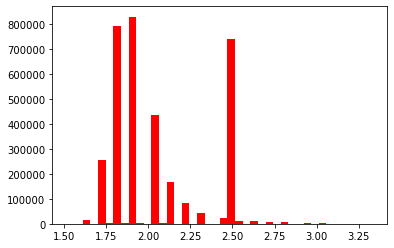

In [103]:
plt.hist(spacings.ego_width, bins=40, color='red')

In [347]:
plt.rcParams["font.family"] = "Times New Roman"

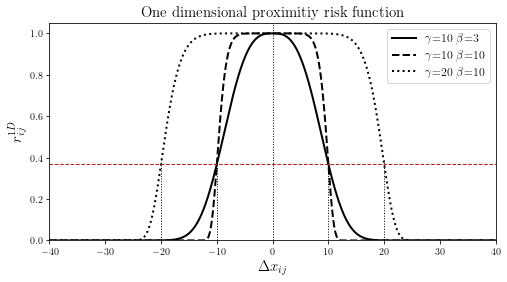

In [421]:
fig = plt.figure(figsize=(8,4))
xs = np.arange(-40, 40, 0.1)
g = [10, 10, 20]
b = [3, 10, 10] 
# cols = ['red','blue','green']
cols = ['black','black','black']
linestyles = ['solid','dashed','dotted']
for i in range(3):
    ys = np.exp( -np.abs(xs/g[i])**b[i] )
    plt.plot(xs, ys, color=cols[i], linewidth=2, linestyle=linestyles[i], label=fr"$\gamma$={g[i]} $\beta$={b[i]}")
plt.axvline(0, linestyle='dotted', color='black', linewidth=1.)
plt.axvline(10, linestyle='dotted', color='black', linewidth=1., ymax=np.exp(-1))
plt.axvline(-10, linestyle='dotted', color='black', linewidth=1., ymax=np.exp(-1))
plt.axvline(20, linestyle='dotted', color='black', linewidth=1., ymax=np.exp(-1))
plt.axvline(-20, linestyle='dotted', color='black', linewidth=1., ymax=np.exp(-1))
plt.axhline(np.exp(-1), linestyle='dashed', color='firebrick', linewidth=1., xmax=max(g))
# plt.annotate(np.exp(-1), [30, np.exp(-1)], color='black', fontsize=15)
plt.ylim(0,1.05)
plt.legend(fontsize=12)
plt.xlim(-40,40)
plt.xlabel(r"$\Delta x_{ij}$", fontsize=15)
plt.ylabel(r"$r_{ij}^{1D}$", fontsize=15, rotation=90)
plt.title('One dimensional proximitiy risk function', fontsize=15)
plt.savefig(r'..\results\aap-figures\ggd_1d.png', dpi=300)
# plt.grid()
